# Random Ensemble Orchestration - With get STATE


## RL test

Defining the Simulation enviroment

In [1]:
from config_manager import ConfigManager
import logging
import os
import numpy as np
from state_manager import StateManager 
from visualization_manager import VisualizationManager, DashApp
from objective import rl_reward_estimation

import gym
from gym import spaces


class SimulationEnv(gym.Env):

    def __init__(self):
        super(SimulationEnv, self).__init__()

        current_dir = os.getcwd()   
        

        parent_dir = os.path.dirname(current_dir)
        CONFIG_PATH = os.path.join(current_dir, "sim_config.yaml")
        PROFILE_PATH = os.path.join(current_dir, "profile/model_profile/model_profile.yaml")


        self.state_manager = StateManager(current_dir)
        self.config_manager = ConfigManager(PROFILE_PATH, CONFIG_PATH)
        self.visualization_manager = VisualizationManager()
        self.dash_app = DashApp(self.visualization_manager)

        self.dash_app.run()

        # Define constants
        self.state_size = self.state_manager.state_lenght # Change this to be dynamic based on the enviroment
        # Observation space: Fixed size of 55
        self.observation_space = spaces.Box(
            low=0.0, high=10.0, shape=(self.state_size,), dtype=np.float32
        )

        # Action space (example: add/remove/replace a model)
        self.action_space = spaces.Discrete(3)

        self.weights = {
            "accuracy": 1.0,
            "confidence": 0.0,
            "latency": 0.0,
            "energy": 0.0,
            "explainability": 0.0
        }

    def reset(self):
        # Reset the environment to an initial state
        # Define Init Data:
        
        self.current_state = self.state_manager.get_state()  # Get initial state
        
        return self.state_manager.flatten_structured_state(self.current_state)

    def step(self, action):
        
        if action == 0:
            self.apply_action("keep_ensemble")
        elif action == 1:
            self.apply_action("add_model")
        elif action == 2:
            self.apply_action("replace_model")
      
        state = self.state_manager.get_state()
        print("STATE: ", state)

        # Simulate a step in the environment
        self.current_state = state
        reward = self._calculate_reward(self.current_state)

        state["reward"] = reward

        self.visualization_manager.reward_list.append(reward)
        self.visualization_manager.add_state_to_csv(state)
        self.dash_app.update_graph()

        print("REWARD: ", reward)

        done = False  # Define termination condition if applicable
        
        return  self.state_manager.flatten_structured_state(self.current_state), reward, done, {}


    def _calculate_reward(self, state):
        model_states = state["model_states"]
        contract_file = {} # load it from the folder
        rl_reward_estimation(model_states, contract_file)
        reward = 0.0


        return reward
    
    def apply_action(self, action):
    
        weights = self.weights
        manager = self.config_manager
        if action == "keep_ensemble":
            logging.info("Action: Keeping the ensemble")
        
        elif action == "add_model":
            manager.add_best_model(weights)
            logging.info("Action: Adding a model")
            # Logic for adding a new model (Placeholder)
        elif action == "replace_model":
            logging.info("Action: Replacing a model")
            manager.remove_worst_model(weights)
            manager.add_best_model(weights)
            # Logic for replacing a model (Placeholder)
        elif action == "remove_model":
            manager.remove_worst_model(weights)

        elif action == "add_random_model":
            manager.add_random_model()
        elif action == "remove_random_model":
            manager.remove_random_model()
        elif action == "replace_random_model":
            manager.remove_random_model()
            manager.add_random_model()


        else:
            logging.warning("Unknown action")

Running the simulation

In [2]:
from stable_baselines3 import PPO

#setup_config()

# Create the environment
env = SimulationEnv()

# Train the agent
model = PPO("MlpPolicy", env, verbose=1, n_steps=1028)
model.learn(total_timesteps=1)

# Save the trained model
model.save("simulation_policy")


Contents of initial_sim_config.yaml have been dumped into c:\Documents\Aalto Semester 2\ResearchCloud\RL_simulation\sim_config.yaml.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Filippo\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.

c:\Users\Filippo\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning:

You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1028`, after every 16 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1028 and n_envs=1)

2025-01-24 16:37:54,982:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.00329458735984739, 'ensemble_size': 3}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.9087229172388712, 'avg_response_time': 2.091670247415987, 'max_response_time': 2.101726343428781, 'contribution': 0.9087229172388712}, 'MobileNetV2': {'accuracy': 1.0, 'confidence': 0.8077986637751261, 'avg_response_time': 0.03763396772187785, 'max_response_time': 0.04570103067149779, 'contribution': 0.8077986637751261}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9968352913856506, 'avg_response_time': 0.1142892278632953, 'max_response_time': 0.12286897397190412, 'contribution': 0.9968352913856506}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.9044522907998825, 'avg_response_time': 2.1006180818694564, 'max_response_time': 2.1109896694707655, 'contribution': 0.9968352913856506}, 'padding_model_5': {'accuracy': 0.0, 'confidence': 0.0, 'avg_response_time': 0.0, 'max_response_time': 0.0, 'contribution': 0.0}, 'padding

2025-01-24 16:37:55,621:INFO -- Action: Adding a model


REWARD:  1.0
Best model: EfficientNetV2S with score: 0.953925925925926
Model 'EfficientNetV2S' successfully added to the target YAML.


2025-01-24 16:37:55,811:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.003833157044692698, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.9127983450889587, 'avg_response_time': 2.0929729976292086, 'max_response_time': 2.101726343428781, 'contribution': 0.9127983450889587}, 'MobileNetV2': {'accuracy': 1.0, 'confidence': 0.8381791114807129, 'avg_response_time': 0.03796508656833962, 'max_response_time': 0.04570103067149779, 'contribution': 0.8381791114807129}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.9138971542318661, 'avg_response_time': 2.101885606582549, 'max_response_time': 2.1109896694707655, 'contribution': 0.9973743259906769}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9155904650688171, 'avg_response_time': 1.1289855051337703, 'max_response_time': 1.1

2025-01-24 16:37:56,204:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006499981282645277, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8, 'confidence': 0.730238676071167, 'avg_response_time': 2.089333021621231, 'max_response_time': 2.101726343428781, 'contribution': 0.730238676071167}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.6705432891845703, 'avg_response_time': 0.03565591134574379, 'max_response_time': 0.04570103067149779, 'contribution': 0.6705432891845703}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.9050085047880808, 'avg_response_time': 2.4485963681855747, 'max_response_time': 3.835439414597678, 'contribution': 0.9717902421951294}, 'EfficientNetV2S': {'accuracy': 0.5, 'confidence': 0.45779523253440857, 'avg_response_time': 1.139215149315158, 'max_response_time': 1.1494

2025-01-24 16:37:56,526:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006499981282645277, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.7479867935180664, 'avg_response_time': 2.083021110240075, 'max_response_time': 2.101726343428781, 'contribution': 0.7479867935180664}, 'MobileNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.7165173888206482, 'avg_response_time': 0.03606145638372208, 'max_response_time': 0.04570103067149779, 'contribution': 0.7165173888206482}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.9028950615061654, 'avg_response_time': 2.6766852135606776, 'max_response_time': 3.835439414597678, 'contribution': 0.9675565163294474}, 'EfficientNetV2S': {'accuracy': 0.6666666666666666, 'confidence': 0.6016159653663635, 'avg_response_time': 

2025-01-24 16:37:56,895:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.011042723686154656, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7758444547653198, 'avg_response_time': 2.0897519943742644, 'max_response_time': 2.130137299179403, 'contribution': 0.7758444547653198}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7467718379838126, 'avg_response_time': 0.035995357249036054, 'max_response_time': 0.04570103067149779, 'contribution': 0.7467718379838126}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.9029991987205687, 'avg_response_time': 3.3144431424392837, 'max_response_time': 7.1409907157109185, 'contribution': 0.9640470743179321}, 'EfficientNetV2S': {'accuracy': 0.75, 'confidence': 0.6788769662380219, 'avg_response_time': 1.150978289

2025-01-24 16:37:57,190:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.011354318386132727, 'ensemble_size': 6}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.875, 'confidence': 0.7237327322363853, 'avg_response_time': 2.085060811529752, 'max_response_time': 2.130137299179403, 'contribution': 0.7237327322363853}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8664030170689027, 'avg_response_time': 3.7932952583752177, 'max_response_time': 7.145260069926755, 'contribution': 0.9510951563715935}, 'EfficientNetV2S': {'accuracy': 0.8, 'confidence': 0.7117706418037415, 'avg_response_time': 1.1448671386004987, 'max_response_time': 

2025-01-24 16:37:57,657:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.016804851811249164, 'ensemble_size': 6}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.7463638120227389, 'avg_response_time': 2.0834600772053875, 'max_response_time': 2.130137299179403, 'contribution': 0.7463638120227389}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8721182477694971, 'avg_response_time': 4.168860222408756, 'max_response_time': 7.173379934677056, 'contribution': 0.9547778434223599}, 'EfficientNetV2S': {'accuracy': 0.8333333333333334, 'confidence': 0.7504109640916189, 'avg_response_time': 1.14832559771

2025-01-24 16:37:57,949:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.016804851811249164, 'ensemble_size': 6}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.7659171521663666, 'avg_response_time': 2.0831169001133563, 'max_response_time': 2.130137299179403, 'contribution': 0.7659171521663666}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8735152412454287, 'avg_response_time': 4.465279280267015, 'max_response_time': 7.173379934677056, 'contribution': 0.9586893916130066}, 'EfficientNetV2S': {'accuracy': 0.8571428571428571, 'confidence': 0.7725123422486442, 'avg_response_time': 1.1542110429932078, 'max_res

2025-01-24 16:37:58,422:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.016804851811249164, 'ensemble_size': 6}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9090909090909091, 'confidence': 0.782048377123746, 'avg_response_time': 2.0881310808306788, 'max_response_time': 2.1382728880039026, 'contribution': 0.782048377123746}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8793440947930017, 'avg_response_time': 4.707868073495996, 'max_response_time': 7.173379934677056, 'contribution': 0.9623690193349664}, 'EfficientNetV2S': {'accuracy': 0.875, 'confidence': 0.7923047691583633, 'avg_response_time': 1.1549149676865822, 'max_re

2025-01-24 16:37:58,982:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.016804851811249164, 'ensemble_size': 6}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9166666666666666, 'confidence': 0.7976582199335098, 'avg_response_time': 2.088951434461207, 'max_response_time': 2.1382728880039026, 'contribution': 0.7976582199335098}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8819440925286876, 'avg_response_time': 4.909421719104345, 'max_response_time': 7.173379934677056, 'contribution': 0.9654721965392431}, 'EfficientNetV2S': {'accuracy': 0.8888888888888888, 'confidence': 0.8067012164327834, 'avg_response_time': 1.15438739155

2025-01-24 16:37:59,418:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017675754738927185, 'ensemble_size': 7}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9230769230769231, 'confidence': 0.7626956976377047, 'avg_response_time': 2.085187463044451, 'max_response_time': 2.1382728880039026, 'contribution': 0.7626956976377047}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8460086090442461, 'avg_response_time': 5.080481358154625, 'max_response_time': 7.173379934677056, 'contribution': 0.9286220417572901}, 'EfficientNetV2S': {'accuracy': 0.8, 'confidence': 0.726031094789505, 'avg_response_time': 1.1542377587860073, 'max_resp

2025-01-24 16:37:59,791:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017675754738927185, 'ensemble_size': 7}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9285714285714286, 'confidence': 0.7713931543486459, 'avg_response_time': 2.085322526368332, 'max_response_time': 2.1382728880039026, 'contribution': 0.7713931543486459}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8500431530532382, 'avg_response_time': 5.22896351850242, 'max_response_time': 7.173379934677056, 'contribution': 0.9321736246347427}, 'EfficientNetV2S': {'accuracy': 0.8181818181818182, 'confidence': 0.742570774121718, 'avg_response_time': 1.1541391114236

2025-01-24 16:38:00,265:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017675754738927185, 'ensemble_size': 7}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9333333333333333, 'confidence': 0.7749027768770854, 'avg_response_time': 2.0837769841080984, 'max_response_time': 2.1382728880039026, 'contribution': 0.7749027768770854}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8476529194249046, 'avg_response_time': 5.357239753354219, 'max_response_time': 7.173379934677056, 'contribution': 0.9305881400903065}, 'EfficientNetV2S': {'accuracy': 0.8333333333333334, 'confidence': 0.7545082370440165, 'avg_response_time': 1.1518386890

2025-01-24 16:38:00,649:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017825260597325844, 'ensemble_size': 8}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9375, 'confidence': 0.7845166958868504, 'avg_response_time': 2.082689795860754, 'max_response_time': 2.1382728880039026, 'contribution': 0.7845166958868504}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8537666688983638, 'avg_response_time': 5.46857008322675, 'max_response_time': 7.173379934677056, 'contribution': 0.9348880480974913}, 'EfficientNetV2S': {'accuracy': 0.8461538461538461, 'confidence': 0.7677831649780273, 'avg_response_time': 1.151116548843612, 'max_re

2025-01-24 16:38:01,478:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017825260597325844, 'ensemble_size': 8}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8823529411764706, 'confidence': 0.7383686549523297, 'avg_response_time': 2.0719560697329085, 'max_response_time': 2.1382728880039026, 'contribution': 0.7383686549523297}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8395289986991749, 'avg_response_time': 5.568771319709042, 'max_response_time': 7.173379934677056, 'contribution': 0.9264139164896572}, 'EfficientNetV2S': {'accuracy': 0.8571428571428571, 'confidence': 0.7694292111056191, 'avg_response_time': 1.1528163435

2025-01-24 16:38:01,885:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017859681623383035, 'ensemble_size': 9}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.7416218519210815, 'avg_response_time': 2.0749248771551194, 'max_response_time': 2.1382728880039026, 'contribution': 0.7416218519210815}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8309439518070094, 'avg_response_time': 5.6557868350795415, 'max_response_time': 7.173379934677056, 'contribution': 0.9263436943292618}, 'EfficientNetV2S': {'accuracy': 0.8666666666666667, 'confidence': 0.7780374407768249, 'avg_response_time': 1.152624775

2025-01-24 16:38:02,402:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017859681623383035, 'ensemble_size': 9}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8421052631578947, 'confidence': 0.7025891228726036, 'avg_response_time': 2.076848749753186, 'max_response_time': 2.1382728880039026, 'contribution': 0.7414728999137878}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.9473684210526315, 'confidence': 0.7872100596066405, 'avg_response_time': 5.730307293185205, 'max_response_time': 7.173379934677056, 'contribution': 0.9250460157268926}, 'EfficientNetV2S': {'accuracy': 0.875, 'confidence': 0.7647466734051704, 'avg_response_time': 1.153585539

2025-01-24 16:38:02,972:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018470515036970083, 'ensemble_size': 10}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8, 'confidence': 0.6674596667289734, 'avg_response_time': 2.0764985943178496, 'max_response_time': 2.1382728880039026, 'contribution': 0.7043992549180984}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.9, 'confidence': 0.7478495566263085, 'avg_response_time': 5.799763747431296, 'max_response_time': 7.173379934677056, 'contribution': 0.8787937149405479}, 'EfficientNetV2S': {'accuracy': 0.8235294117647058, 'confidence': 0.7197615749695722, 'avg_response_time': 1.152647407443897, 'max_re

2025-01-24 16:38:03,476:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018556997220561713, 'ensemble_size': 11}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8095238095238095, 'confidence': 0.6799647779691786, 'avg_response_time': 2.074727808840599, 'max_response_time': 2.1382728880039026, 'contribution': 0.7151453381492978}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.9047619047619048, 'confidence': 0.7572679311540833, 'avg_response_time': 5.861159211513451, 'max_response_time': 7.173379934677056, 'contribution': 0.8845556818303608}, 'EfficientNetV2S': {'accuracy': 0.8333333333333334, 'confidence': 0.7311580015553368, 'avg_response_time

2025-01-24 16:38:03,976:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018556997220561713, 'ensemble_size': 11}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.6904400370337747, 'avg_response_time': 2.074877301333987, 'max_response_time': 2.1382728880039026, 'contribution': 0.7240214808420702}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.9090909090909091, 'confidence': 0.7654416798425209, 'avg_response_time': 5.919808652689046, 'max_response_time': 7.173379934677056, 'contribution': 0.8897850012237375}, 'EfficientNetV2S': {'accuracy': 0.8421052631578947, 'confidence': 0.7402465751296595, 'avg_response_time

2025-01-24 16:38:04,474:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018556997220561713, 'ensemble_size': 11}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8260869565217391, 'confidence': 0.6999173579008683, 'avg_response_time': 2.07473227295504, 'max_response_time': 2.1382728880039026, 'contribution': 0.7320387389348901}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.9130434782608695, 'confidence': 0.7719704910100303, 'avg_response_time': 5.97596487567221, 'max_response_time': 7.211401781301823, 'contribution': 0.8933990273786627}, 'EfficientNetV2S': {'accuracy': 0.85, 'confidence': 0.7490469425916672, 'avg_response_time': 1.14717985844

2025-01-24 16:38:05,139:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018556997220561713, 'ensemble_size': 11}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.7916666666666666, 'confidence': 0.6707541346549988, 'avg_response_time': 2.077079445493472, 'max_response_time': 2.1382728880039026, 'contribution': 0.701537124812603}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.9166666666666666, 'confidence': 0.7663639978052776, 'avg_response_time': 6.0255914246579065, 'max_response_time': 7.211401781301823, 'contribution': 0.892500426620245}, 'EfficientNetV2S': {'accuracy': 0.8095238095238095, 'confidence': 0.7133780405634925, 'avg_response_time'

2025-01-24 16:38:05,830:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018556997220561713, 'ensemble_size': 11}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8, 'confidence': 0.6810529375076294, 'avg_response_time': 2.0788085133717598, 'max_response_time': 2.1382728880039026, 'contribution': 0.7106046080589294}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6934397853910923, 'avg_response_time': 0.03533945077594443, 'max_response_time': 0.04570103067149779, 'contribution': 0.6934397853910923}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.92, 'confidence': 0.7636595223674182, 'avg_response_time': 6.069444815141038, 'max_response_time': 7.211401781301823, 'contribution': 0.8939293777942657}, 'EfficientNetV2S': {'accuracy': 0.8181818181818182, 'confidence': 0.722683150659908, 'avg_response_time': 1.1466980583316764, 'max_r

2025-01-24 16:38:06,607:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018591318869234208, 'ensemble_size': 12}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8076923076923077, 'confidence': 0.6846209374757913, 'avg_response_time': 2.078837801982801, 'max_response_time': 2.1382728880039026, 'contribution': 0.7130360053135798}, 'MobileNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.6538042624791464, 'avg_response_time': 0.0431495637912494, 'max_response_time': 0.1056304679136892, 'contribution': 0.6538042624791464}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.9230769230769231, 'confidence': 0.7636251288469981, 'avg_response_time': 6.110936573703741, 'max_response_time': 7.211401781301823, 'contribution': 0.8951130773012455}, 'EfficientNetV2S': {'accuracy': 0.8260869565217391, 'confidence': 0.731007544890694, 'avg_res

2025-01-24 16:38:07,340:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018591318869234208, 'ensemble_size': 12}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8148148148148148, 'confidence': 0.6929380143130267, 'avg_response_time': 2.0802519775031736, 'max_response_time': 2.1382728880039026, 'contribution': 0.7203006722308971}, 'MobileNetV2': {'accuracy': 0.9, 'confidence': 0.6694361686706543, 'avg_response_time': 0.048388223581506976, 'max_response_time': 0.1056304679136892, 'contribution': 0.6694361686706543}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.9259259259259259, 'confidence': 0.7687583237637161, 'avg_response_time': 6.149120926604843, 'max_response_time': 7.211401781301823, 'contribution': 0.8988590980017627}, 'EfficientNetV2S': {'accuracy': 0.8333333333333334, 'confidence': 0.7372041394313177, 'avg_response_time'

2025-01-24 16:38:08,035:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018591318869234208, 'ensemble_size': 12}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8214285714285714, 'confidence': 0.6960104533604213, 'avg_response_time': 2.077924788105393, 'max_response_time': 2.1382728880039026, 'contribution': 0.6945756482226508}, 'MobileNetV2': {'accuracy': 0.9090909090909091, 'confidence': 0.666110943664204, 'avg_response_time': 0.05310461135404994, 'max_response_time': 0.1056304679136892, 'contribution': 0.6085783351551403}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.8928571428571429, 'confidence': 0.7413026693435834, 'avg_response_time': 6.183607586269052, 'max_response_time': 7.211401781301823, 'contribution': 0.8667569873588425}, 'EfficientNetV2S': {'accuracy': 0.84, 'confidence': 0.7405449604988098, 'avg_response_time': 

2025-01-24 16:38:08,710:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018591318869234208, 'ensemble_size': 12}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8275862068965517, 'confidence': 0.7037136821911253, 'avg_response_time': 2.0789384038813385, 'max_response_time': 2.1382728880039026, 'contribution': 0.7023283530925882}, 'MobileNetV2': {'accuracy': 0.9166666666666666, 'confidence': 0.6661982387304306, 'avg_response_time': 0.05763024336414029, 'max_response_time': 0.10741219547513417, 'contribution': 0.6134600142637888}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.896551724137931, 'confidence': 0.7442965406735228, 'avg_response_time': 6.22031120779865, 'max_response_time': 7.248012610627401, 'contribution': 0.8704343859491677}, 'EfficientNetV2S': {'accuracy': 0.8461538461538461, 'confidence': 0.7443046982471759, 'avg_r

2025-01-24 16:38:09,709:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018591318869234208, 'ensemble_size': 12}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.7108795126279195, 'avg_response_time': 2.0795580846613393, 'max_response_time': 2.1382728880039026, 'contribution': 0.7095403611660004}, 'MobileNetV2': {'accuracy': 0.9230769230769231, 'confidence': 0.6558246704248282, 'avg_response_time': 0.060642480935602476, 'max_response_time': 0.10741219547513417, 'contribution': 0.6071432324556204}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.9, 'confidence': 0.747147283783006, 'avg_response_time': 6.251142182003444, 'max_response_time': 7.248012610627401, 'contribution': 0.8737082252899806}, 'EfficientNetV2S': {'accuracy': 0.8518518518518519, 'confidence': 0.7499949291900352, 'avg_response_time'

2025-01-24 16:38:10,488:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018654365737329086, 'ensemble_size': 13}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8064516129032258, 'confidence': 0.6879479154463737, 'avg_response_time': 2.0775132732639756, 'max_response_time': 2.1382728880039026, 'contribution': 0.7084486157663407}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.608980051108769, 'avg_response_time': 0.06362719783214382, 'max_response_time': 0.10741219547513417, 'contribution': 0.5999631796564374}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.8709677419354839, 'confidence': 0.7230457584996832, 'avg_response_time': 6.278164098917378, 'max_response_time': 7.248012610627401, 'contribution': 0.874058174510156}, 'EfficientNetV2S': {'accuracy': 0.8214285714285714, 'confidence': 0.7232093960046768, 'avg_r

2025-01-24 16:38:11,186:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01894598299398171, 'ensemble_size': 14}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8125, 'confidence': 0.6961353309452534, 'avg_response_time': 2.0773511556741475, 'max_response_time': 2.1382728880039026, 'contribution': 0.7159953843802214}, 'MobileNetV2': {'accuracy': 0.8666666666666667, 'confidence': 0.6299733678499858, 'avg_response_time': 0.0661445489661273, 'max_response_time': 0.10741219547513417, 'contribution': 0.621557621161143}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.7273141798048588, 'avg_response_time': 6.305362592782025, 'max_response_time': 7.248012610627401, 'contribution': 0.8776862369850278}, 'EfficientNetV2S': {'accuracy': 0.8275862068965517, 'confidence': 0.7299939537870472, 'avg_response_time': 1.144317314

2025-01-24 16:38:11,946:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01894598299398171, 'ensemble_size': 14}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.7040207873691212, 'avg_response_time': 2.077294498066572, 'max_response_time': 2.1382728880039026, 'contribution': 0.7232790210030295}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6491066440939903, 'avg_response_time': 0.06842018878255568, 'max_response_time': 0.10741219547513417, 'contribution': 0.6412168815732002}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9973743259906769, 'avg_response_time': 0.11628307826802525, 'max_response_time': 0.12286897397190412, 'contribution': 0.9973743259906769}, 'ensemble': {'accuracy': 0.8787878787878788, 'confidence': 0.7333323211526885, 'avg_response_time': 6.330078762529151, 'max_response_time': 7.248012610627401, 'contribution': 0.8813130828467283}, 'EfficientNetV2S': {'accuracy': 0.8333333333333334, 'confidence': 0.736203012863795, 'avg_response_time':

2025-01-24 16:38:13,108:INFO -- Action: Adding a model


Model 'ResNet50V2' successfully added to the target YAML.


2025-01-24 16:38:13,821:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01944298437078823, 'ensemble_size': 15}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8285714285714286, 'confidence': 0.7163553987230573, 'avg_response_time': 2.0787688297019864, 'max_response_time': 2.1382728880039026, 'contribution': 0.7345131618635995}, 'MobileNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.6770291129748026, 'avg_response_time': 0.07191513117695776, 'max_response_time': 0.10741219547513417, 'contribution': 0.6700159907341003}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9978464722633362, 'avg_response_time': 0.1726461008431687, 'max_response_time': 0.3980981911437425, 'contribution': 0.9978464722633362}, 'ensemble': {'accuracy': 0.8857142857142857, 'confidence': 0.742434785655542, 'avg_response_time': 6.373032919432345, 'max_response_time': 7.248012610627401, 'contribution': 0.8877982216221946}, 'EfficientNetV2S': {'accuracy': 0.84375, 'confidence': 0.7466956805437803, 'avg_response_time'

2025-01-24 16:38:14,533:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01944298437078823, 'ensemble_size': 15}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.7222906831238005, 'avg_response_time': 2.0798860906103194, 'max_response_time': 2.1382728880039026, 'contribution': 0.7399440639548831}, 'MobileNetV2': {'accuracy': 0.8947368421052632, 'confidence': 0.6908974208329853, 'avg_response_time': 0.07354009586867814, 'max_response_time': 0.10741219547513417, 'contribution': 0.6842534102891621}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9981864194075266, 'avg_response_time': 0.21358631705291362, 'max_response_time': 0.4182873981016382, 'contribution': 0.9981864194075266}, 'ensemble': {'accuracy': 0.8888888888888888, 'confidence': 0.7480013727644841, 'avg_response_time': 6.394451379986911, 'max_response_time': 7.248012610627401, 'contribution': 0.8909117753307024}, 'EfficientNetV2S': {'accuracy': 0.8484848484848485, 'confidence': 0.7527186581582734, 'avg_r

2025-01-24 16:38:15,485:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01944298437078823, 'ensemble_size': 15}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8378378378378378, 'confidence': 0.7247443247485805, 'avg_response_time': 2.0799993632342924, 'max_response_time': 2.1382728880039026, 'contribution': 0.7419205871788231}, 'MobileNetV2': {'accuracy': 0.9, 'confidence': 0.6789516940712929, 'avg_response_time': 0.07534145268573762, 'max_response_time': 0.10956723220986778, 'contribution': 0.6726398840546608}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9408753599439349, 'avg_response_time': 0.2367726222284609, 'max_response_time': 0.4182873981016382, 'contribution': 0.9408753599439349}, 'ensemble': {'accuracy': 0.8918918918918919, 'confidence': 0.7448778114470503, 'avg_response_time': 6.413864142387802, 'max_response_time': 7.248012610627401, 'contribution': 0.889358648577252}, 'EfficientNetV2S': {'accuracy': 0.8529411764705882, 'confidence': 0.7550929942551781, 'avg_response_time': 1.

2025-01-24 16:38:16,323:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01944298437078823, 'ensemble_size': 15}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8421052631578947, 'confidence': 0.7307725799711127, 'avg_response_time': 2.0789672242950927, 'max_response_time': 2.1382728880039026, 'contribution': 0.7474968354952963}, 'MobileNetV2': {'accuracy': 0.9047619047619048, 'confidence': 0.6918124003069741, 'avg_response_time': 0.07664629339448376, 'max_response_time': 0.10956723220986778, 'contribution': 0.6858011526720864}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.9482617527246475, 'avg_response_time': 0.25678662563714444, 'max_response_time': 0.4182873981016382, 'contribution': 0.9482617527246475}, 'ensemble': {'accuracy': 0.8947368421052632, 'confidence': 0.7499561022897784, 'avg_response_time': 6.433967212757649, 'max_response_time': 7.248012610627401, 'contribution': 0.8922693815670515}, 'EfficientNetV2S': {'accuracy': 0.8571428571428571, 'confidence': 0.7604350737162999, 'avg_r

2025-01-24 16:38:17,164:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01944298437078823, 'ensemble_size': 15}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8205128205128205, 'confidence': 0.7120348215103149, 'avg_response_time': 2.0761074209509287, 'max_response_time': 2.1382728880039026, 'contribution': 0.7456557949384054}, 'MobileNetV2': {'accuracy': 0.8636363636363636, 'confidence': 0.6603663821112026, 'avg_response_time': 0.07838552772953995, 'max_response_time': 0.11490944876572, 'contribution': 0.6776566681536761}, 'ResNet50V2': {'accuracy': 0.8888888888888888, 'confidence': 0.8428993357552422, 'avg_response_time': 0.27292126129287547, 'max_response_time': 0.4182873981016382, 'contribution': 0.9112239082654318}, 'ensemble': {'accuracy': 0.8717948717948718, 'confidence': 0.7307264586413225, 'avg_response_time': 6.450959374806064, 'max_response_time': 7.248012610627401, 'contribution': 0.8920716192477789}, 'EfficientNetV2S': {'accuracy': 0.8333333333333334, 'confidence': 0.739311877224

2025-01-24 16:38:17,995:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01944298437078823, 'ensemble_size': 15}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.825, 'confidence': 0.7174158379435539, 'avg_response_time': 2.076181778112855, 'max_response_time': 2.1382728880039026, 'contribution': 0.7501962870359421}, 'MobileNetV2': {'accuracy': 0.8695652173913043, 'confidence': 0.6720350242179373, 'avg_response_time': 0.07981905040634601, 'max_response_time': 0.11490944876572, 'contribution': 0.6885735586933468}, 'ResNet50V2': {'accuracy': 0.9, 'confidence': 0.8586091876029969, 'avg_response_time': 0.2759095389205643, 'max_response_time': 0.4182873981016382, 'contribution': 0.9201013028621674}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.7362204815567744, 'avg_response_time': 6.468189603031327, 'max_response_time': 7.248012610627401, 'contribution': 0.8947697751224041}, 'EfficientNetV2S': {'accuracy': 0.8378378378378378, 'confidence': 0.744843257440103, 'avg_response_time': 1.146419850502658

2025-01-24 16:38:18,971:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01944298437078823, 'ensemble_size': 15}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8292682926829268, 'confidence': 0.722525772525043, 'avg_response_time': 2.07599631413471, 'max_response_time': 2.1382728880039026, 'contribution': 0.7545066984688363}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6813623470564684, 'avg_response_time': 0.08101062826875803, 'max_response_time': 0.11490944876572, 'contribution': 0.6972117759287357}, 'ResNet50V2': {'accuracy': 0.9090909090909091, 'confidence': 0.8714626919139515, 'avg_response_time': 0.28733280934337346, 'max_response_time': 0.4182873981016382, 'contribution': 0.9273646148768339}, 'ensemble': {'accuracy': 0.8780487804878049, 'confidence': 0.7413655507488185, 'avg_response_time': 6.484216586620938, 'max_response_time': 7.248012610627401, 'contribution': 0.8973363107297478}, 'EfficientNetV2S': {'accuracy': 0.8421052631578947, 'confidence': 0.7497771366646415, 'avg_respo

2025-01-24 16:38:19,643:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.7267743859972272, 'avg_response_time': 2.0751993685162304, 'max_response_time': 2.1382728880039026, 'contribution': 0.7579938613233113}, 'MobileNetV2': {'accuracy': 0.88, 'confidence': 0.6858106791973114, 'avg_response_time': 0.08155909562715681, 'max_response_time': 0.11490944876572, 'contribution': 0.7010261309146881}, 'ResNet50V2': {'accuracy': 0.9166666666666666, 'confidence': 0.8820235878229141, 'avg_response_time': 0.29854943061655037, 'max_response_time': 0.42193226462149624, 'contribution': 0.9332670172055563}, 'ensemble': {'accuracy': 0.8809523809523809, 'confidence': 0.7453905772236805, 'avg_response_time': 6.500545279148647, 'max_response_time': 7.248012610627401, 'contribution': 0.8997667651800882}, 'EfficientNetV2S': {'accuracy': 0.8461538461538461, 'confidence': 0.7541596537981278, 'avg_r

2025-01-24 16:38:20,519:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8372093023255814, 'confidence': 0.7309941524683043, 'avg_response_time': 2.0752804537997873, 'max_response_time': 2.1382728880039026, 'contribution': 0.7614875934844794}, 'MobileNetV2': {'accuracy': 0.8846153846153846, 'confidence': 0.6964281602547719, 'avg_response_time': 0.08219992050929054, 'max_response_time': 0.11490944876572, 'contribution': 0.711058402290711}, 'ResNet50V2': {'accuracy': 0.9230769230769231, 'confidence': 0.8910986322623032, 'avg_response_time': 0.30788465879390947, 'max_response_time': 0.42193226462149624, 'contribution': 0.9384002593847421}, 'ensemble': {'accuracy': 0.8837209302325582, 'confidence': 0.7500823561012017, 'avg_response_time': 6.515703041305802, 'max_response_time': 7.248012610627401, 'contribution': 0.902097751234853}, 'EfficientNetV2S': {'accuracy': 0.85, 'confidence': 0.7587906152009964, 'avg_res

2025-01-24 16:38:21,407:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8409090909090909, 'confidence': 0.732288970188661, 'avg_response_time': 2.0728574775073314, 'max_response_time': 2.1382728880039026, 'contribution': 0.7620893784544684}, 'MobileNetV2': {'accuracy': 0.8518518518518519, 'confidence': 0.6706345246897804, 'avg_response_time': 0.08266820860136093, 'max_response_time': 0.11490944876572, 'contribution': 0.6847229059095736}, 'ResNet50V2': {'accuracy': 0.8571428571428571, 'confidence': 0.827448729957853, 'avg_response_time': 0.31537682812544976, 'max_response_time': 0.42193226462149624, 'contribution': 0.8713716694286892}, 'ensemble': {'accuracy': 0.8863636363636364, 'confidence': 0.7492638651302365, 'avg_response_time': 6.528457802774648, 'max_response_time': 7.248012610627401, 'contribution': 0.9027892168272625}, 'EfficientNetV2S': {'accuracy': 0.8536585365853658, 'confidence': 0.760343356830

2025-01-24 16:38:22,153:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8444444444444444, 'confidence': 0.7361867295371162, 'avg_response_time': 2.0731705281068122, 'max_response_time': 2.1382728880039026, 'contribution': 0.7653249065081279}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.6668523007205555, 'avg_response_time': 0.08343224747263568, 'max_response_time': 0.11490944876572, 'contribution': 0.6804375254682132}, 'ResNet50V2': {'accuracy': 0.8666666666666667, 'confidence': 0.8384078661600749, 'avg_response_time': 0.32020371300714584, 'max_response_time': 0.42193226462149624, 'contribution': 0.8794026096661886}, 'ensemble': {'accuracy': 0.8888888888888888, 'confidence': 0.7515037981358279, 'avg_response_time': 6.5416933967961715, 'max_response_time': 7.248012610627401, 'contribution': 0.904859514368905}, 'EfficientNetV2S': {'accuracy': 0.8571428571428571, 'confidence': 0.7630703860

2025-01-24 16:38:22,861:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8478260869565217, 'confidence': 0.7396290120871171, 'avg_response_time': 2.0722311974409187, 'max_response_time': 2.1382728880039026, 'contribution': 0.7681337504283242}, 'MobileNetV2': {'accuracy': 0.8620689655172413, 'confidence': 0.6753838545289533, 'avg_response_time': 0.08421450240814768, 'max_response_time': 0.11490944876572, 'contribution': 0.6885006232508297}, 'ResNet50V2': {'accuracy': 0.875, 'confidence': 0.8475251644849777, 'avg_response_time': 0.3251265441642386, 'max_response_time': 0.42193226462149624, 'contribution': 0.8859577365219593}, 'ensemble': {'accuracy': 0.8913043478260869, 'confidence': 0.753985115547586, 'avg_response_time': 6.55449451548881, 'max_response_time': 7.248012610627401, 'contribution': 0.9065861475208531}, 'EfficientNetV2S': {'accuracy': 0.8604651162790697, 'confidence': 0.7658454651056334, 'avg_res

2025-01-24 16:38:23,557:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.851063829787234, 'confidence': 0.743652102795053, 'avg_response_time': 2.0732898170900365, 'max_response_time': 2.1382728880039026, 'contribution': 0.7715503573417664}, 'MobileNetV2': {'accuracy': 0.8666666666666667, 'confidence': 0.673932334780693, 'avg_response_time': 0.08464810711331834, 'max_response_time': 0.11490944876572, 'contribution': 0.686611877878507}, 'ResNet50V2': {'accuracy': 0.8823529411764706, 'confidence': 0.8562123389805064, 'avg_response_time': 0.3306149022981395, 'max_response_time': 0.42193226462149624, 'contribution': 0.8923841714859009}, 'ensemble': {'accuracy': 0.8936170212765957, 'confidence': 0.7548361297161442, 'avg_response_time': 6.567322428926486, 'max_response_time': 7.248012610627401, 'contribution': 0.9084717003588981}, 'EfficientNetV2S': {'accuracy': 0.8636363636363636, 'confidence': 0.769367262721061

2025-01-24 16:38:24,598:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8541666666666666, 'confidence': 0.747425007323424, 'avg_response_time': 2.073855254686605, 'max_response_time': 2.1382728880039026, 'contribution': 0.7747420482337475}, 'MobileNetV2': {'accuracy': 0.8709677419354839, 'confidence': 0.6843798920031516, 'avg_response_time': 0.08523306190802006, 'max_response_time': 0.11490944876572, 'contribution': 0.6966504175816813}, 'ResNet50V2': {'accuracy': 0.8888888888888888, 'confidence': 0.8640910916858249, 'avg_response_time': 0.33383225296167046, 'max_response_time': 0.42193226462149624, 'contribution': 0.8982533779409196}, 'ensemble': {'accuracy': 0.8958333333333334, 'confidence': 0.7584798628017718, 'avg_response_time': 6.579154458984988, 'max_response_time': 7.248012610627401, 'contribution': 0.9103782294938961}, 'EfficientNetV2S': {'accuracy': 0.8666666666666667, 'confidence': 0.772240877151

2025-01-24 16:38:25,480:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7425998729102465, 'avg_response_time': 2.0737818690404857, 'max_response_time': 2.1382728880039026, 'contribution': 0.769359423189747}, 'MobileNetV2': {'accuracy': 0.875, 'confidence': 0.6802262691780925, 'avg_response_time': 0.08533539528037895, 'max_response_time': 0.11490944876572, 'contribution': 0.692113340832293}, 'ResNet50V2': {'accuracy': 0.8421052631578947, 'confidence': 0.8186126131760446, 'avg_response_time': 0.33751645325166724, 'max_response_time': 0.42193226462149624, 'contribution': 0.8509768843650818}, 'ensemble': {'accuracy': 0.8979591836734694, 'confidence': 0.7547285265698589, 'avg_response_time': 6.589873304611766, 'max_response_time': 7.248012610627401, 'contribution': 0.8917990819532045}, 'EfficientNetV2S': {'accuracy': 0.8695652173913043, 'confidence': 0.7704868096372356, 'avg_re

2025-01-24 16:38:26,373:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.86, 'confidence': 0.7457689130306244, 'avg_response_time': 2.0743502454927714, 'max_response_time': 2.1382728880039026, 'contribution': 0.771993272304535}, 'MobileNetV2': {'accuracy': 0.8787878787878788, 'confidence': 0.6888964383891134, 'avg_response_time': 0.0856073740962215, 'max_response_time': 0.11490944876572, 'contribution': 0.7004232957507625}, 'ResNet50V2': {'accuracy': 0.85, 'confidence': 0.8276515781879425, 'avg_response_time': 0.34030396631287146, 'max_response_time': 0.42193226462149624, 'contribution': 0.8583976358175278}, 'ensemble': {'accuracy': 0.9, 'confidence': 0.7581004049713478, 'avg_response_time': 6.601354189312538, 'max_response_time': 7.248012610627401, 'contribution': 0.8939630001783371}, 'EfficientNetV2S': {'accuracy': 0.8723404255319149, 'confidence': 0.7738685886910621, 'avg_response_time': 1.14624683485593

2025-01-24 16:38:27,263:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8627450980392157, 'confidence': 0.7467627899319518, 'avg_response_time': 2.0735588678527055, 'max_response_time': 2.1382728880039026, 'contribution': 0.7568561493181715}, 'MobileNetV2': {'accuracy': 0.8529411764705882, 'confidence': 0.6686347784364924, 'avg_response_time': 0.08588474727731071, 'max_response_time': 0.11490944876572, 'contribution': 0.6798226105816224}, 'ResNet50V2': {'accuracy': 0.8095238095238095, 'confidence': 0.788239598274231, 'avg_response_time': 0.34271031382777484, 'max_response_time': 0.42193226462149624, 'contribution': 0.8480539804413205}, 'ensemble': {'accuracy': 0.8823529411764706, 'confidence': 0.7432356911483802, 'avg_response_time': 6.612479613343669, 'max_response_time': 7.248012610627401, 'contribution': 0.8764343139003304}, 'EfficientNetV2S': {'accuracy': 0.875, 'confidence': 0.7734615330894788, 'avg_r

2025-01-24 16:38:28,152:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8653846153846154, 'confidence': 0.7502870834790744, 'avg_response_time': 2.074329403279026, 'max_response_time': 2.1382728880039026, 'contribution': 0.7601863398001745}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.6741265032972609, 'avg_response_time': 0.08620341924682097, 'max_response_time': 0.11490944876572, 'contribution': 0.684994683095387}, 'ResNet50V2': {'accuracy': 0.8181818181818182, 'confidence': 0.7932144132527438, 'avg_response_time': 0.3440905245181916, 'max_response_time': 0.42193226462149624, 'contribution': 0.8503099598667838}, 'ensemble': {'accuracy': 0.8846153846153846, 'confidence': 0.7461824677249431, 'avg_response_time': 6.622724564531794, 'max_response_time': 7.248012610627401, 'contribution': 0.878594815157927}, 'EfficientNetV2S': {'accuracy': 0.8775510204081632, 'confidence': 0.77640491602372

2025-01-24 16:38:28,837:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8490566037735849, 'confidence': 0.7361307234134314, 'avg_response_time': 2.073895812292956, 'max_response_time': 2.1382728880039026, 'contribution': 0.7458432013133787}, 'MobileNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.6554007670945592, 'avg_response_time': 0.08642398729614979, 'max_response_time': 0.11490944876572, 'contribution': 0.6659670530094041}, 'ResNet50V2': {'accuracy': 0.782608695652174, 'confidence': 0.7587268300678419, 'avg_response_time': 0.34689358547789106, 'max_response_time': 0.42193226462149624, 'contribution': 0.8476886878842893}, 'ensemble': {'accuracy': 0.8679245283018868, 'confidence': 0.7321035532395669, 'avg_response_time': 6.632809105752683, 'max_response_time': 7.248012610627401, 'contribution': 0.8620175544945698}, 'EfficientNetV2S': {'accuracy': 0.86, 'confidence': 0.7608768177032471, 'avg_res

2025-01-24 16:38:29,581:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8518518518518519, 'confidence': 0.7387967595347652, 'avg_response_time': 2.073647819499724, 'max_response_time': 2.1382728880039026, 'contribution': 0.7483293767328616}, 'MobileNetV2': {'accuracy': 0.8378378378378378, 'confidence': 0.6615938665093603, 'avg_response_time': 0.08657808296015272, 'max_response_time': 0.11490944876572, 'contribution': 0.6718745771292094}, 'ResNet50V2': {'accuracy': 0.7916666666666666, 'confidence': 0.768777792652448, 'avg_response_time': 0.34953813092623776, 'max_response_time': 0.42193226462149624, 'contribution': 0.8540329063932101}, 'ensemble': {'accuracy': 0.8703703703703703, 'confidence': 0.735300852821479, 'avg_response_time': 6.642320328033249, 'max_response_time': 7.248012610627401, 'contribution': 0.8645718577835295}, 'EfficientNetV2S': {'accuracy': 0.8627450980392157, 'confidence': 0.7640413910734

2025-01-24 16:38:30,311:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8545454545454545, 'confidence': 0.7425485318357294, 'avg_response_time': 2.0733392683626373, 'max_response_time': 2.1382728880039026, 'contribution': 0.7519078287211332}, 'MobileNetV2': {'accuracy': 0.8421052631578947, 'confidence': 0.6697458209175813, 'avg_response_time': 0.08647535892530017, 'max_response_time': 0.11490944876572, 'contribution': 0.6797559865211186}, 'ResNet50V2': {'accuracy': 0.8, 'confidence': 0.7780266761779785, 'avg_response_time': 0.3513866251500975, 'max_response_time': 0.42193226462149624, 'contribution': 0.8598715853691101}, 'ensemble': {'accuracy': 0.8727272727272727, 'confidence': 0.7393934129616587, 'avg_response_time': 6.650583318511995, 'max_response_time': 7.248012610627401, 'contribution': 0.8670341876420108}, 'EfficientNetV2S': {'accuracy': 0.8653846153846154, 'confidence': 0.7670198931143835, 'avg_res

2025-01-24 16:38:31,001:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7457971338714872, 'avg_response_time': 2.0735770440055985, 'max_response_time': 2.1382728880039026, 'contribution': 0.7549893004553658}, 'MobileNetV2': {'accuracy': 0.8461538461538461, 'confidence': 0.6774677137533823, 'avg_response_time': 0.08688748297834763, 'max_response_time': 0.11490944876572, 'contribution': 0.6872212084440085}, 'ResNet50V2': {'accuracy': 0.8076923076923077, 'confidence': 0.7865640200101413, 'avg_response_time': 0.3531588133084123, 'max_response_time': 0.42193226462149624, 'contribution': 0.865261048078537}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.7431758724893723, 'avg_response_time': 6.658834572405099, 'max_response_time': 7.248012610627401, 'contribution': 0.8694085707621915}, 'EfficientNetV2S': {'accuracy': 0.8679245283018868, 'confidence': 0.7701651903818238, 'avg_re

2025-01-24 16:38:31,891:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8596491228070176, 'confidence': 0.7489815668055886, 'avg_response_time': 2.0740622279638985, 'max_response_time': 2.1382728880039026, 'contribution': 0.7580124673090483}, 'MobileNetV2': {'accuracy': 0.85, 'confidence': 0.6849525935947895, 'avg_response_time': 0.08697160533987539, 'max_response_time': 0.11490944876572, 'contribution': 0.69446225091815}, 'ResNet50V2': {'accuracy': 0.8148148148148148, 'confidence': 0.7944675463217276, 'avg_response_time': 0.3543023025758951, 'max_response_time': 0.42193226462149624, 'contribution': 0.8702498696468495}, 'ensemble': {'accuracy': 0.8771929824561403, 'confidence': 0.7463410306077137, 'avg_response_time': 6.666595433190172, 'max_response_time': 7.248012610627401, 'contribution': 0.8716989332123807}, 'EfficientNetV2S': {'accuracy': 0.8703703703703703, 'confidence': 0.7725342026463261, 'avg_resp

2025-01-24 16:38:32,582:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8620689655172413, 'confidence': 0.7522958660947865, 'avg_response_time': 2.0739442401337174, 'max_response_time': 2.1382728880039026, 'contribution': 0.7611710614171522}, 'MobileNetV2': {'accuracy': 0.8536585365853658, 'confidence': 0.6830967890053261, 'avg_response_time': 0.08730617342989297, 'max_response_time': 0.11490944876572, 'contribution': 0.6923745034671411}, 'ResNet50V2': {'accuracy': 0.8214285714285714, 'confidence': 0.8007097457136426, 'avg_response_time': 0.3549002157640719, 'max_response_time': 0.42193226462149624, 'contribution': 0.8737855574914387}, 'ensemble': {'accuracy': 0.8793103448275862, 'confidence': 0.749094704755684, 'avg_response_time': 6.6749938266936315, 'max_response_time': 7.248012610627401, 'contribution': 0.8739056952040771}, 'EfficientNetV2S': {'accuracy': 0.8727272727272727, 'confidence': 0.77558919191

2025-01-24 16:38:33,348:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.864406779661017, 'confidence': 0.7548676850432057, 'avg_response_time': 2.073475126499001, 'max_response_time': 2.1382728880039026, 'contribution': 0.7635924533262091}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.6902701691502616, 'avg_response_time': 0.0875138594944258, 'max_response_time': 0.11490944876572, 'contribution': 0.6993269856487002}, 'ResNet50V2': {'accuracy': 0.8275862068965517, 'confidence': 0.804813105484535, 'avg_response_time': 0.3559677951822776, 'max_response_time': 0.42193226462149624, 'contribution': 0.8753690616837864}, 'ensemble': {'accuracy': 0.8813559322033898, 'confidence': 0.7514156595743869, 'avg_response_time': 6.682797423300076, 'max_response_time': 7.248012610627401, 'contribution': 0.8758985021356809}, 'EfficientNetV2S': {'accuracy': 0.875, 'confidence': 0.7776102413024221, 'avg_respo

2025-01-24 16:38:34,034:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8666666666666667, 'confidence': 0.7574654887119929, 'avg_response_time': 2.0739969883796308, 'max_response_time': 2.1382728880039026, 'contribution': 0.7660448441902796}, 'MobileNetV2': {'accuracy': 0.8604651162790697, 'confidence': 0.6957437416841817, 'avg_response_time': 0.0877968176502608, 'max_response_time': 0.11490944876572, 'contribution': 0.7045899345431217}, 'ResNet50V2': {'accuracy': 0.8333333333333334, 'confidence': 0.8113192200660706, 'avg_response_time': 0.3579150646639451, 'max_response_time': 0.42193226462149624, 'contribution': 0.8795233110586802}, 'ensemble': {'accuracy': 0.8833333333333333, 'confidence': 0.7538815617983594, 'avg_response_time': 6.690970777979517, 'max_response_time': 7.248012610627401, 'contribution': 0.8779668028155962}, 'EfficientNetV2S': {'accuracy': 0.8771929824561403, 'confidence': 0.780346690562

2025-01-24 16:38:34,928:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8688524590163934, 'confidence': 0.7602666020393372, 'avg_response_time': 2.0734459266514556, 'max_response_time': 2.1382728880039026, 'contribution': 0.7687053123458487}, 'MobileNetV2': {'accuracy': 0.8636363636363636, 'confidence': 0.7021900977600705, 'avg_response_time': 0.08834799459762395, 'max_response_time': 0.11490944876572, 'contribution': 0.7108352407813072}, 'ResNet50V2': {'accuracy': 0.8387096774193549, 'confidence': 0.8174044124541744, 'avg_response_time': 0.35912324962426934, 'max_response_time': 0.42193226462149624, 'contribution': 0.8834083714792805}, 'ensemble': {'accuracy': 0.8852459016393442, 'confidence': 0.7568129252630232, 'avg_response_time': 6.697735211806763, 'max_response_time': 7.248012610627401, 'contribution': 0.8799666943120175}, 'EfficientNetV2S': {'accuracy': 0.8793103448275862, 'confidence': 0.7825554054

2025-01-24 16:38:35,826:INFO -- Action: Adding a model


No eligible models to score.


2025-01-24 16:38:36,578:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.873015873015873, 'confidence': 0.7657583441053119, 'avg_response_time': 2.070093561023686, 'max_response_time': 2.1382728880039026, 'contribution': 0.7739291588465372}, 'MobileNetV2': {'accuracy': 0.8695652173913043, 'confidence': 0.7076884048140567, 'avg_response_time': 0.08870434195622462, 'max_response_time': 0.11490944876572, 'contribution': 0.7159576720517614}, 'ResNet50V2': {'accuracy': 0.8181818181818182, 'confidence': 0.7964582985097711, 'avg_response_time': 0.35885748417431607, 'max_response_time': 0.42193226462149624, 'contribution': 0.8584620175939618}, 'ensemble': {'accuracy': 0.8888888888888888, 'confidence': 0.7576000436314927, 'avg_response_time': 6.710607111614192, 'max_response_time': 7.248012610627401, 'contribution': 0.8830757174226973}, 'EfficientNetV2S': {'accuracy': 0.8833333333333333, 'confidence': 0.786286234855

2025-01-24 16:38:37,269:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.875, 'confidence': 0.7682755086570978, 'avg_response_time': 2.0694814321063286, 'max_response_time': 2.1382728880039026, 'contribution': 0.7763186544179916}, 'MobileNetV2': {'accuracy': 0.8723404255319149, 'confidence': 0.7123721235610069, 'avg_response_time': 0.08911153554578882, 'max_response_time': 0.11490944876572, 'contribution': 0.7204654489425902}, 'ResNet50V2': {'accuracy': 0.8235294117647058, 'confidence': 0.8024448191418367, 'avg_response_time': 0.3605504108254182, 'max_response_time': 0.42193226462149624, 'contribution': 0.8626248994294334}, 'ensemble': {'accuracy': 0.890625, 'confidence': 0.7603538434023444, 'avg_response_time': 6.717514813815727, 'max_response_time': 7.248012610627401, 'contribution': 0.8849026593379676}, 'EfficientNetV2S': {'accuracy': 0.8852459016393442, 'confidence': 0.7883678420645291, 'avg_response_ti

2025-01-24 16:38:37,987:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8769230769230769, 'confidence': 0.7701541561346787, 'avg_response_time': 2.0694078878248146, 'max_response_time': 2.1382728880039026, 'contribution': 0.7643752905038687}, 'MobileNetV2': {'accuracy': 0.8541666666666666, 'confidence': 0.6975310376534859, 'avg_response_time': 0.08931775852400485, 'max_response_time': 0.11490944876572, 'contribution': 0.7153579027702411}, 'ResNet50V2': {'accuracy': 0.8285714285714286, 'confidence': 0.7953075579234532, 'avg_response_time': 0.36066765217234364, 'max_response_time': 0.42193226462149624, 'contribution': 0.8379784737314496}, 'ensemble': {'accuracy': 0.8769230769230769, 'confidence': 0.7486560919653852, 'avg_response_time': 6.724235093192533, 'max_response_time': 7.248012610627401, 'contribution': 0.8859920001946963}, 'EfficientNetV2S': {'accuracy': 0.8870967741935484, 'confidence': 0.7860363500

2025-01-24 16:38:38,677:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8787878787878788, 'confidence': 0.7723755402998491, 'avg_response_time': 2.0694421796003484, 'max_response_time': 2.1382728880039026, 'contribution': 0.7666842332392028}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7033795525833052, 'avg_response_time': 0.09047783219225201, 'max_response_time': 0.14616136826811602, 'contribution': 0.720842604126249}, 'ResNet50V2': {'accuracy': 0.8333333333333334, 'confidence': 0.8009924193223318, 'avg_response_time': 0.36207219994408785, 'max_response_time': 0.42193226462149624, 'contribution': 0.8424780319134394}, 'ensemble': {'accuracy': 0.8787878787878788, 'confidence': 0.7517436263840399, 'avg_response_time': 6.730370879165904, 'max_response_time': 7.248012610627401, 'contribution': 0.8877188269839142}, 'EfficientNetV2S': {'accuracy': 0.8888888888888888, 'confidence': 0.78813884

2025-01-24 16:38:39,628:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8805970149253731, 'confidence': 0.774706246247932, 'avg_response_time': 2.0691195158411784, 'max_response_time': 2.1382728880039026, 'contribution': 0.769099884068788}, 'MobileNetV2': {'accuracy': 0.86, 'confidence': 0.7005209225416184, 'avg_response_time': 0.09064975839510238, 'max_response_time': 0.14616136826811602, 'contribution': 0.7176347130537033}, 'ResNet50V2': {'accuracy': 0.8108108108108109, 'confidence': 0.7793439755568633, 'avg_response_time': 0.36316007520087507, 'max_response_time': 0.42193226462149624, 'contribution': 0.8197083553752383}, 'ensemble': {'accuracy': 0.8805970149253731, 'confidence': 0.751039336911105, 'avg_response_time': 6.736539538343082, 'max_response_time': 7.248012610627401, 'contribution': 0.8883279913396978}, 'EfficientNetV2S': {'accuracy': 0.890625, 'confidence': 0.7900257967412472, 'avg_response_ti

2025-01-24 16:38:40,315:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8823529411764706, 'confidence': 0.7775373713058584, 'avg_response_time': 2.0695839214727805, 'max_response_time': 2.1382728880039026, 'contribution': 0.7720134556293488}, 'MobileNetV2': {'accuracy': 0.8627450980392157, 'confidence': 0.7046035300282871, 'avg_response_time': 0.09163607269263012, 'max_response_time': 0.14616136826811602, 'contribution': 0.7213817560205272}, 'ResNet50V2': {'accuracy': 0.8157894736842105, 'confidence': 0.7845393121242523, 'avg_response_time': 0.36413807969556816, 'max_response_time': 0.42193226462149624, 'contribution': 0.8238414714210912}, 'ensemble': {'accuracy': 0.8823529411764706, 'confidence': 0.7530731884107376, 'avg_response_time': 6.743000356485874, 'max_response_time': 7.248012610627401, 'contribution': 0.8899331991286838}, 'EfficientNetV2S': {'accuracy': 0.8923076923076924, 'confidence': 0.7920252

2025-01-24 16:38:41,218:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8840579710144928, 'confidence': 0.779606781144073, 'avg_response_time': 2.0700702616404456, 'max_response_time': 2.1382728880039026, 'contribution': 0.7741629222164983}, 'MobileNetV2': {'accuracy': 0.8653846153846154, 'confidence': 0.7087265545359025, 'avg_response_time': 0.09173101191779966, 'max_response_time': 0.14616136826811602, 'contribution': 0.7251821223359841}, 'ResNet50V2': {'accuracy': 0.8205128205128205, 'confidence': 0.7900637678610973, 'avg_response_time': 0.3649560462356464, 'max_response_time': 0.42193226462149624, 'contribution': 0.8283581794836582}, 'ensemble': {'accuracy': 0.8840579710144928, 'confidence': 0.7558900178164765, 'avg_response_time': 6.748670247171388, 'max_response_time': 7.248012610627401, 'contribution': 0.8915282699508943}, 'EfficientNetV2S': {'accuracy': 0.8939393939393939, 'confidence': 0.793988342

2025-01-24 16:38:42,106:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8857142857142857, 'confidence': 0.781767554794039, 'avg_response_time': 2.0704893482837314, 'max_response_time': 2.1382728880039026, 'contribution': 0.7764014652797154}, 'MobileNetV2': {'accuracy': 0.8679245283018868, 'confidence': 0.7141424962934458, 'avg_response_time': 0.09192820805754498, 'max_response_time': 0.14616136826811602, 'contribution': 0.7302875816822052}, 'ResNet50V2': {'accuracy': 0.825, 'confidence': 0.7953120991587639, 'avg_response_time': 0.36529827088240097, 'max_response_time': 0.42193226462149624, 'contribution': 0.8326491504907608}, 'ensemble': {'accuracy': 0.8857142857142857, 'confidence': 0.7587218663063023, 'avg_response_time': 6.753781737863419, 'max_response_time': 7.248012610627401, 'contribution': 0.8930778235197068}, 'EfficientNetV2S': {'accuracy': 0.8955223880597015, 'confidence': 0.7958668763957807, 'av

2025-01-24 16:38:42,798:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8873239436619719, 'confidence': 0.7840053690990931, 'avg_response_time': 2.0704664004899653, 'max_response_time': 2.1382728880039026, 'contribution': 0.7787148583103234}, 'MobileNetV2': {'accuracy': 0.8703703703703703, 'confidence': 0.7129296919813862, 'avg_response_time': 0.09202391155604832, 'max_response_time': 0.14616136826811602, 'contribution': 0.7287757943073908}, 'ResNet50V2': {'accuracy': 0.8292682926829268, 'confidence': 0.7995691895484924, 'avg_response_time': 0.3659403592116898, 'max_response_time': 0.42193226462149624, 'contribution': 0.8359955810919041}, 'ensemble': {'accuracy': 0.8873239436619719, 'confidence': 0.7596395361258637, 'avg_response_time': 6.758484754440727, 'max_response_time': 7.248012610627401, 'contribution': 0.8941591612889733}, 'EfficientNetV2S': {'accuracy': 0.8970588235294118, 'confidence': 0.79702465

2025-01-24 16:38:43,549:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.875, 'confidence': 0.7731164056393836, 'avg_response_time': 2.070618056027727, 'max_response_time': 2.1382728880039026, 'contribution': 0.7678993741671244}, 'MobileNetV2': {'accuracy': 0.8545454545454545, 'confidence': 0.699967333945361, 'avg_response_time': 0.09212247659298842, 'max_response_time': 0.14616136826811602, 'contribution': 0.7155253253199837}, 'ResNet50V2': {'accuracy': 0.8095238095238095, 'confidence': 0.7805318278925759, 'avg_response_time': 0.3674988319093529, 'max_response_time': 0.4313962125135385, 'contribution': 0.8160909243992397}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.7490889870130045, 'avg_response_time': 6.763937183826622, 'max_response_time': 7.248012610627401, 'contribution': 0.8817402840488486}, 'EfficientNetV2S': {'accuracy': 0.8985507246376812, 'confidence': 0.7931495213854141, 'avg_response_time'

2025-01-24 16:38:44,239:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.863013698630137, 'confidence': 0.7625257699456933, 'avg_response_time': 2.070670714540673, 'max_response_time': 2.1382728880039026, 'contribution': 0.7573802046579857}, 'MobileNetV2': {'accuracy': 0.8392857142857143, 'confidence': 0.6874679172677653, 'avg_response_time': 0.09236579867764429, 'max_response_time': 0.14616136826811602, 'contribution': 0.7177114385579314}, 'ResNet50V2': {'accuracy': 0.7906976744186046, 'confidence': 0.76237992491833, 'avg_response_time': 0.36825782336189383, 'max_response_time': 0.4313962125135385, 'contribution': 0.7971120656922807}, 'ensemble': {'accuracy': 0.863013698630137, 'confidence': 0.7388274940402236, 'avg_response_time': 6.7686291911014145, 'max_response_time': 7.248012610627401, 'contribution': 0.8811403851803035}, 'EfficientNetV2S': {'accuracy': 0.9, 'confidence': 0.788652446440288, 'avg_respo

2025-01-24 16:38:44,958:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8648648648648649, 'confidence': 0.764887543948921, 'avg_response_time': 2.0699900562975175, 'max_response_time': 2.1382728880039026, 'contribution': 0.7598115133272635}, 'MobileNetV2': {'accuracy': 0.8421052631578947, 'confidence': 0.6921025446632452, 'avg_response_time': 0.09216524392515939, 'max_response_time': 0.14616136826811602, 'contribution': 0.7218154778606013}, 'ResNet50V2': {'accuracy': 0.7954545454545454, 'confidence': 0.7677803811701861, 'avg_response_time': 0.36936409996676506, 'max_response_time': 0.4313962125135385, 'contribution': 0.8017231551083651}, 'ensemble': {'accuracy': 0.8648648648648649, 'confidence': 0.7415813916219752, 'avg_response_time': 6.7737318740448895, 'max_response_time': 7.248012610627401, 'contribution': 0.8827465961913805}, 'EfficientNetV2S': {'accuracy': 0.9014084507042254, 'confidence': 0.79069901

2025-01-24 16:38:45,671:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8533333333333334, 'confidence': 0.7546890433629354, 'avg_response_time': 2.0701280465593133, 'max_response_time': 2.1382728880039026, 'contribution': 0.7593858718872071}, 'MobileNetV2': {'accuracy': 0.8275862068965517, 'confidence': 0.6801697421690514, 'avg_response_time': 0.09246054297632421, 'max_response_time': 0.14616136826811602, 'contribution': 0.7200732431535063}, 'ResNet50V2': {'accuracy': 0.8, 'confidence': 0.7716149038738674, 'avg_response_time': 0.37012015743636023, 'max_response_time': 0.4313962125135385, 'contribution': 0.783907084994846}, 'ensemble': {'accuracy': 0.8533333333333334, 'confidence': 0.7316936397336823, 'avg_response_time': 6.7786097936194984, 'max_response_time': 7.248012610627401, 'contribution': 0.8840692675113678}, 'EfficientNetV2S': {'accuracy': 0.9027777777777778, 'confidence': 0.7866082870297961, 'avg_

2025-01-24 16:38:46,629:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8552631578947368, 'confidence': 0.7569270847659362, 'avg_response_time': 2.0686499630371626, 'max_response_time': 2.1382728880039026, 'contribution': 0.7615621129148885}, 'MobileNetV2': {'accuracy': 0.8305084745762712, 'confidence': 0.6797328293323517, 'avg_response_time': 0.09175125954202179, 'max_response_time': 0.14616136826811602, 'contribution': 0.7189599997916464}, 'ResNet50V2': {'accuracy': 0.8043478260869565, 'confidence': 0.7663450577984685, 'avg_response_time': 0.37123571932660526, 'max_response_time': 0.4313962125135385, 'contribution': 0.7783700175907301}, 'ensemble': {'accuracy': 0.8552631578947368, 'confidence': 0.7325784595176286, 'avg_response_time': 6.78320148628964, 'max_response_time': 7.248012610627401, 'contribution': 0.885019300407485}, 'EfficientNetV2S': {'accuracy': 0.9041095890410958, 'confidence': 0.7880140142

2025-01-24 16:38:47,322:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7591394015720913, 'avg_response_time': 2.068874514048107, 'max_response_time': 2.1382728880039026, 'contribution': 0.7637142345502779}, 'MobileNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.6838830346862476, 'avg_response_time': 0.09203134619806766, 'max_response_time': 0.14616136826811602, 'contribution': 0.7224564189712207}, 'ResNet50V2': {'accuracy': 0.8085106382978723, 'confidence': 0.7713163938928158, 'avg_response_time': 0.37159535360210433, 'max_response_time': 0.4313962125135385, 'contribution': 0.7830855034767313}, 'ensemble': {'accuracy': 0.8571428571428571, 'confidence': 0.7352494333551787, 'avg_response_time': 6.787612939537473, 'max_response_time': 7.248012610627401, 'contribution': 0.8865125283792421}, 'EfficientNetV2S': {'accuracy': 0.9054054054054054, 'confidence': 0.790121567

2025-01-24 16:38:48,015:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8589743589743589, 'confidence': 0.7612940921233251, 'avg_response_time': 2.0694730673472304, 'max_response_time': 2.1382728880039026, 'contribution': 0.7658102733966632}, 'MobileNetV2': {'accuracy': 0.8360655737704918, 'confidence': 0.6882355872724877, 'avg_response_time': 0.0921986598934155, 'max_response_time': 0.14616136826811602, 'contribution': 0.7261766209954121}, 'ResNet50V2': {'accuracy': 0.8125, 'confidence': 0.7739722430706024, 'avg_response_time': 0.372393441893051, 'max_response_time': 0.4313962125135385, 'contribution': 0.7854961628715197}, 'ensemble': {'accuracy': 0.8589743589743589, 'confidence': 0.7366694213662871, 'avg_response_time': 6.791930908891912, 'max_response_time': 7.248012610627401, 'contribution': 0.8878462410125977}, 'EfficientNetV2S': {'accuracy': 0.9066666666666666, 'confidence': 0.7917258270581563, 'avg_

2025-01-24 16:38:48,709:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8607594936708861, 'confidence': 0.7636111703100084, 'avg_response_time': 2.0697957781448104, 'max_response_time': 2.1382728880039026, 'contribution': 0.7680701847317852}, 'MobileNetV2': {'accuracy': 0.8387096774193549, 'confidence': 0.690497473843636, 'avg_response_time': 0.0924135401183378, 'max_response_time': 0.14616136826811602, 'contribution': 0.7278265554097391}, 'ResNet50V2': {'accuracy': 0.8163265306122449, 'confidence': 0.7784452061263882, 'avg_response_time': 0.37246564631372925, 'max_response_time': 0.4313962125135385, 'contribution': 0.7897339438905522}, 'ensemble': {'accuracy': 0.8607594936708861, 'confidence': 0.7384308036919355, 'avg_response_time': 6.796347164396697, 'max_response_time': 7.248012610627401, 'contribution': 0.8892371288583248}, 'EfficientNetV2S': {'accuracy': 0.9078947368421053, 'confidence': 0.7926358753

2025-01-24 16:38:49,667:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8625, 'confidence': 0.7657952420413494, 'avg_response_time': 2.06999468043886, 'max_response_time': 2.1382728880039026, 'contribution': 0.7701985187828541}, 'MobileNetV2': {'accuracy': 0.8412698412698413, 'confidence': 0.6951917348399995, 'avg_response_time': 0.09237756869328081, 'max_response_time': 0.14616136826811602, 'contribution': 0.7319282913018786}, 'ResNet50V2': {'accuracy': 0.82, 'confidence': 0.7828644692897797, 'avg_response_time': 0.37286859916743836, 'max_response_time': 0.4313962125135385, 'contribution': 0.7939274322986603}, 'ensemble': {'accuracy': 0.8625, 'confidence': 0.7408313721216192, 'avg_response_time': 6.800221628847664, 'max_response_time': 7.248012610627401, 'contribution': 0.8906149793416261}, 'EfficientNetV2S': {'accuracy': 0.9090909090909091, 'confidence': 0.7938743883913214, 'avg_response_time': 1.1445259

2025-01-24 16:38:50,356:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8641975308641975, 'confidence': 0.76796492897434, 'avg_response_time': 2.0694943211825376, 'max_response_time': 2.1382728880039026, 'contribution': 0.7723138442745915}, 'MobileNetV2': {'accuracy': 0.84375, 'confidence': 0.6994960564188659, 'avg_response_time': 0.09242166659997052, 'max_response_time': 0.14616136826811602, 'contribution': 0.7356586041860282}, 'ResNet50V2': {'accuracy': 0.8235294117647058, 'confidence': 0.787122014690848, 'avg_response_time': 0.37320773520804945, 'max_response_time': 0.4313962125135385, 'contribution': 0.7979680568564171}, 'ensemble': {'accuracy': 0.8641975308641975, 'confidence': 0.7435566646372311, 'avg_response_time': 6.804606490274612, 'max_response_time': 7.248012610627401, 'contribution': 0.8919654116954332}, 'EfficientNetV2S': {'accuracy': 0.9102564102564102, 'confidence': 0.7956676689478067, 'avg

2025-01-24 16:38:51,114:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8658536585365854, 'confidence': 0.7696274271825465, 'avg_response_time': 2.069448468429986, 'max_response_time': 2.1382728880039026, 'contribution': 0.7739233069303559}, 'MobileNetV2': {'accuracy': 0.8461538461538461, 'confidence': 0.7023319762486678, 'avg_response_time': 0.09259198635622137, 'max_response_time': 0.14616136826811602, 'contribution': 0.7379381771271045}, 'ResNet50V2': {'accuracy': 0.8269230769230769, 'confidence': 0.7912075771735265, 'avg_response_time': 0.37362047688481975, 'max_response_time': 0.4313962125135385, 'contribution': 0.8018450416051425}, 'ensemble': {'accuracy': 0.8658536585365854, 'confidence': 0.7459754719769539, 'avg_response_time': 6.809105532087042, 'max_response_time': 7.248012610627401, 'contribution': 0.893277678184393}, 'EfficientNetV2S': {'accuracy': 0.9113924050632911, 'confidence': 0.7969783816

2025-01-24 16:38:52,016:INFO -- Action: Adding a model
2025-01-24 16:38:52,738:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8690476190476191, 'confidence': 0.7720599720875422, 'avg_response_time': 2.0685410624843152, 'max_response_time': 2.1382728880039026, 'contribution': 0.7762535689842134}, 'MobileNetV2': {'accuracy': 0.8507462686567164, 'confidence': 0.7075171590741001, 'avg_response_time': 0.09291481310856592, 'max_response_time': 0.14616136826811602, 'contribution': 0.7420604882845238}, 'ResNet50V2': {'accuracy': 0.8148148148148148, 'confidence': 0.7784214704125015, 'avg_response_time': 0.37409237021158015, 'max_response_time': 0.4313962125135385, 'contribution': 0.7886649546799837}, 'ensemble': {'accuracy': 0.8690476190476191, 'confidence': 0.748078724824568, 'avg_response_time': 6.816537543420127, 'max_response_time': 7.248012610627401, 'contribution': 0.8950008576114973}, 'EfficientNetV2S': {'accuracy': 0.9135802469135802, 'confidence': 0.796811932

2025-01-24 16:38:53,440:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8705882352941177, 'confidence': 0.7741840173216427, 'avg_response_time': 2.069454874018186, 'max_response_time': 2.1462150428633615, 'contribution': 0.7783282777842353}, 'MobileNetV2': {'accuracy': 0.8529411764705882, 'confidence': 0.7044991714989438, 'avg_response_time': 0.0932306604336911, 'max_response_time': 0.14616136826811602, 'contribution': 0.7385345105739201}, 'ResNet50V2': {'accuracy': 0.8181818181818182, 'confidence': 0.7718498322096738, 'avg_response_time': 0.37485155598181635, 'max_response_time': 0.4313962125135385, 'contribution': 0.7819070713086562}, 'ensemble': {'accuracy': 0.8705882352941177, 'confidence': 0.748274510834915, 'avg_response_time': 6.8199428605467265, 'max_response_time': 7.248012610627401, 'contribution': 0.8958488271516912}, 'EfficientNetV2S': {'accuracy': 0.9146341463414634, 'confidence': 0.7981095314

2025-01-24 16:38:54,209:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.872093023255814, 'confidence': 0.7720139338526615, 'avg_response_time': 2.0691751696983887, 'max_response_time': 2.1462150428633615, 'contribution': 0.7761100052401076}, 'MobileNetV2': {'accuracy': 0.8405797101449275, 'confidence': 0.6942890385786692, 'avg_response_time': 0.09317685453416498, 'max_response_time': 0.14616136826811602, 'contribution': 0.7278311118699502}, 'ResNet50V2': {'accuracy': 0.8035714285714286, 'confidence': 0.7580667994916439, 'avg_response_time': 0.37504610994337945, 'max_response_time': 0.4313962125135385, 'contribution': 0.7679444450352874}, 'ensemble': {'accuracy': 0.872093023255814, 'confidence': 0.7477223904028387, 'avg_response_time': 6.823332806029222, 'max_response_time': 7.248012610627401, 'contribution': 0.8953868064076401}, 'EfficientNetV2S': {'accuracy': 0.9156626506024096, 'confidence': 0.7988083929

2025-01-24 16:38:55,078:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8735632183908046, 'confidence': 0.7737577345179415, 'avg_response_time': 2.0691763695961027, 'max_response_time': 2.1462150428633615, 'contribution': 0.7778067246250723}, 'MobileNetV2': {'accuracy': 0.8428571428571429, 'confidence': 0.6971247566597802, 'avg_response_time': 0.09319409347703146, 'max_response_time': 0.14616136826811602, 'contribution': 0.7301876574754715}, 'ResNet50V2': {'accuracy': 0.8070175438596491, 'confidence': 0.7619022449903321, 'avg_response_time': 0.3755753806069584, 'max_response_time': 0.4313962125135385, 'contribution': 0.7716065985068941}, 'ensemble': {'accuracy': 0.8735632183908046, 'confidence': 0.7498013521452941, 'avg_response_time': 6.8270394630433335, 'max_response_time': 7.248012610627401, 'contribution': 0.8965821166833242}, 'EfficientNetV2S': {'accuracy': 0.9166666666666666, 'confidence': 0.80047397

2025-01-24 16:38:55,945:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.875, 'confidence': 0.7741331268440593, 'avg_response_time': 2.068948650712304, 'max_response_time': 2.1462150428633615, 'contribution': 0.7781361056999727}, 'MobileNetV2': {'accuracy': 0.8450704225352113, 'confidence': 0.6947442599585358, 'avg_response_time': 0.09329799654063296, 'max_response_time': 0.14616136826811602, 'contribution': 0.7273414861148512}, 'ResNet50V2': {'accuracy': 0.8103448275862069, 'confidence': 0.7658868046670124, 'avg_response_time': 0.37627193291429645, 'max_response_time': 0.4313962125135385, 'contribution': 0.7754238417436337}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.7492844590020742, 'avg_response_time': 6.830038496446105, 'max_response_time': 7.248012610627401, 'contribution': 0.8976778506555341}, 'EfficientNetV2S': {'accuracy': 0.9176470588235294, 'confidence': 0.7984370098394507, 'avg_response_tim

2025-01-24 16:38:56,791:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8764044943820225, 'confidence': 0.7757555574513553, 'avg_response_time': 2.068813466631626, 'max_response_time': 2.1462150428633615, 'contribution': 0.7797135590167528}, 'MobileNetV2': {'accuracy': 0.8472222222222222, 'confidence': 0.6983136290477382, 'avg_response_time': 0.09337186930278062, 'max_response_time': 0.14616136826811602, 'contribution': 0.7304581159518825}, 'ResNet50V2': {'accuracy': 0.8135593220338984, 'confidence': 0.7649906868651762, 'avg_response_time': 0.37662860527160436, 'max_response_time': 0.4313962125135385, 'contribution': 0.7743660792455835}, 'ensemble': {'accuracy': 0.8764044943820225, 'confidence': 0.7509735998261129, 'avg_response_time': 6.833419699429029, 'max_response_time': 7.248012610627401, 'contribution': 0.8987510341606783}, 'EfficientNetV2S': {'accuracy': 0.9186046511627907, 'confidence': 0.799682521

2025-01-24 16:38:57,856:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8777777777777778, 'confidence': 0.7773025035858154, 'avg_response_time': 2.0684942819883805, 'max_response_time': 2.1462150428633615, 'contribution': 0.7812165273560419}, 'MobileNetV2': {'accuracy': 0.8493150684931506, 'confidence': 0.7008484695872216, 'avg_response_time': 0.09343969992475443, 'max_response_time': 0.14616136826811602, 'contribution': 0.7325526210543227}, 'ResNet50V2': {'accuracy': 0.8166666666666667, 'confidence': 0.7689075087507565, 'avg_response_time': 0.37646203885784196, 'max_response_time': 0.4313962125135385, 'contribution': 0.7781266445914904}, 'ensemble': {'accuracy': 0.8777777777777778, 'confidence': 0.7525502975236329, 'avg_response_time': 6.836476932830385, 'max_response_time': 7.248012610627401, 'contribution': 0.8998760226700041}, 'EfficientNetV2S': {'accuracy': 0.9195402298850575, 'confidence': 0.80081032

2025-01-24 16:38:58,894:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8791208791208791, 'confidence': 0.7787392106685009, 'avg_response_time': 2.0679887099130103, 'max_response_time': 2.1462150428633615, 'contribution': 0.782610223188505}, 'MobileNetV2': {'accuracy': 0.8513513513513513, 'confidence': 0.6989436403319642, 'avg_response_time': 0.09356405846984636, 'max_response_time': 0.14616136826811602, 'contribution': 0.7302193573197803}, 'ResNet50V2': {'accuracy': 0.8032786885245902, 'confidence': 0.756302467623695, 'avg_response_time': 0.37674089636687613, 'max_response_time': 0.4313962125135385, 'contribution': 0.7653704700899906}, 'ensemble': {'accuracy': 0.8791208791208791, 'confidence': 0.7519164102332105, 'avg_response_time': 6.839426432476183, 'max_response_time': 7.248012610627401, 'contribution': 0.8999657680045118}, 'EfficientNetV2S': {'accuracy': 0.9204545454545454, 'confidence': 0.8018836934

2025-01-24 16:38:59,697:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8804347826086957, 'confidence': 0.7775141590315363, 'avg_response_time': 2.0681559025118834, 'max_response_time': 2.1462150428633615, 'contribution': 0.7813430953284969}, 'MobileNetV2': {'accuracy': 0.84, 'confidence': 0.6896243917942048, 'avg_response_time': 0.09356111797949697, 'max_response_time': 0.14616136826811602, 'contribution': 0.7204830992221832}, 'ResNet50V2': {'accuracy': 0.7903225806451613, 'confidence': 0.7441040407265386, 'avg_response_time': 0.3773492439727316, 'max_response_time': 0.4313962125135385, 'contribution': 0.7530257850885391}, 'ensemble': {'accuracy': 0.8804347826086957, 'confidence': 0.7520144876421552, 'avg_response_time': 6.842670787856005, 'max_response_time': 7.248012610627401, 'contribution': 0.9004157551604769}, 'EfficientNetV2S': {'accuracy': 0.9213483146067416, 'confidence': 0.803450894489717, 'avg_r

2025-01-24 16:39:00,752:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8817204301075269, 'confidence': 0.7795462121245682, 'avg_response_time': 2.0671176875371304, 'max_response_time': 2.1462150428633615, 'contribution': 0.783333977063497}, 'MobileNetV2': {'accuracy': 0.8421052631578947, 'confidence': 0.6905852889544085, 'avg_response_time': 0.09351353476648701, 'max_response_time': 0.14616136826811602, 'contribution': 0.7210379607583347}, 'ResNet50V2': {'accuracy': 0.7777777777777778, 'confidence': 0.7322928654769111, 'avg_response_time': 0.3780035725480147, 'max_response_time': 0.4313962125135385, 'contribution': 0.7410729948490385}, 'ensemble': {'accuracy': 0.8817204301075269, 'confidence': 0.7528111804105959, 'avg_response_time': 6.845052933464812, 'max_response_time': 7.248012610627401, 'contribution': 0.9011262857144878}, 'EfficientNetV2S': {'accuracy': 0.9222222222222223, 'confidence': 0.8044210222

2025-01-24 16:39:01,563:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8829787234042553, 'confidence': 0.7811394745999194, 'avg_response_time': 2.067099234878806, 'max_response_time': 2.1462150428633615, 'contribution': 0.7848869441671574}, 'MobileNetV2': {'accuracy': 0.8441558441558441, 'confidence': 0.6944129455399204, 'avg_response_time': 0.09362269190195265, 'max_response_time': 0.14616136826811602, 'contribution': 0.7244701280996397}, 'ResNet50V2': {'accuracy': 0.78125, 'confidence': 0.7364721414633095, 'avg_response_time': 0.3786614125967624, 'max_response_time': 0.4313962125135385, 'contribution': 0.7451150813139975}, 'ensemble': {'accuracy': 0.8829787234042553, 'confidence': 0.7544110321488843, 'avg_response_time': 6.848177975556995, 'max_response_time': 7.248012610627401, 'contribution': 0.9021756500005722}, 'EfficientNetV2S': {'accuracy': 0.9230769230769231, 'confidence': 0.8053678385504, 'avg_r

2025-01-24 16:39:02,401:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8842105263157894, 'confidence': 0.7826015190074318, 'avg_response_time': 2.0667406718139927, 'max_response_time': 2.1462150428633615, 'contribution': 0.7863095415265937}, 'MobileNetV2': {'accuracy': 0.8461538461538461, 'confidence': 0.6975217534181399, 'avg_response_time': 0.09353744490262801, 'max_response_time': 0.14616136826811602, 'contribution': 0.7271935874835039}, 'ResNet50V2': {'accuracy': 0.7846153846153846, 'confidence': 0.7405264143760387, 'avg_response_time': 0.3793834993510856, 'max_response_time': 0.4313962125135385, 'contribution': 0.7490363859213316}, 'ensemble': {'accuracy': 0.8842105263157894, 'confidence': 0.756500821958263, 'avg_response_time': 6.8510503628657995, 'max_response_time': 7.248012610627401, 'contribution': 0.9032053787457316}, 'EfficientNetV2S': {'accuracy': 0.9239130434782609, 'confidence': 0.806657923

2025-01-24 16:39:03,441:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8854166666666666, 'confidence': 0.7777482454354564, 'avg_response_time': 2.066881291421486, 'max_response_time': 2.1462150428633615, 'contribution': 0.7814176427200437}, 'MobileNetV2': {'accuracy': 0.8481012658227848, 'confidence': 0.6969347426408454, 'avg_response_time': 0.09357794981445575, 'max_response_time': 0.14616136826811602, 'contribution': 0.7262309838699389}, 'ResNet50V2': {'accuracy': 0.7727272727272727, 'confidence': 0.729306317188523, 'avg_response_time': 0.3795786058541967, 'max_response_time': 0.4313962125135385, 'contribution': 0.7376873497710084}, 'ensemble': {'accuracy': 0.8854166666666666, 'confidence': 0.7560005196524454, 'avg_response_time': 6.853845904189721, 'max_response_time': 7.248012610627401, 'contribution': 0.9030974845712384}, 'EfficientNetV2S': {'accuracy': 0.9247311827956989, 'confidence': 0.80582005362

2025-01-24 16:39:04,537:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8865979381443299, 'confidence': 0.77933439182252, 'avg_response_time': 2.0680542921287857, 'max_response_time': 2.180662360029575, 'contribution': 0.7829659602691218}, 'MobileNetV2': {'accuracy': 0.85, 'confidence': 0.6999797273427248, 'avg_response_time': 0.0937754335379807, 'max_response_time': 0.14616136826811602, 'contribution': 0.7289097655564547}, 'ResNet50V2': {'accuracy': 0.7761194029850746, 'confidence': 0.7333314307590029, 'avg_response_time': 0.3801111167523199, 'max_response_time': 0.4313962125135385, 'contribution': 0.7415873733029437}, 'ensemble': {'accuracy': 0.8865979381443299, 'confidence': 0.7574621628892158, 'avg_response_time': 6.856905982177346, 'max_response_time': 7.248012610627401, 'contribution': 0.9040860561365934}, 'EfficientNetV2S': {'accuracy': 0.925531914893617, 'confidence': 0.8067148803396428, 'avg_respo

2025-01-24 16:39:05,392:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8877551020408163, 'confidence': 0.7809435107878276, 'avg_response_time': 2.0680443095916967, 'max_response_time': 2.180662360029575, 'contribution': 0.7845380224135458}, 'MobileNetV2': {'accuracy': 0.8518518518518519, 'confidence': 0.7027692960368263, 'avg_response_time': 0.09383322475540735, 'max_response_time': 0.14616136826811602, 'contribution': 0.7313421732849545}, 'ResNet50V2': {'accuracy': 0.7794117647058824, 'confidence': 0.7372160233995494, 'avg_response_time': 0.38014538788853053, 'max_response_time': 0.4313962125135385, 'contribution': 0.7453505550237263}, 'ensemble': {'accuracy': 0.8877551020408163, 'confidence': 0.7593202733098023, 'avg_response_time': 6.859928517655871, 'max_response_time': 7.248012610627401, 'contribution': 0.905046710250329}, 'EfficientNetV2S': {'accuracy': 0.9263157894736842, 'confidence': 0.8077776651

2025-01-24 16:39:06,408:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.7825580489153814, 'avg_response_time': 2.0678665087298476, 'max_response_time': 2.180662360029575, 'contribution': 0.7861162523428599}, 'MobileNetV2': {'accuracy': 0.8536585365853658, 'confidence': 0.7044533167670413, 'avg_response_time': 0.0939731037147305, 'max_response_time': 0.14616136826811602, 'contribution': 0.7326777442926313}, 'ResNet50V2': {'accuracy': 0.782608695652174, 'confidence': 0.7400480141674263, 'avg_response_time': 0.3805638980667122, 'max_response_time': 0.4313962125135385, 'contribution': 0.748064654028934}, 'ensemble': {'accuracy': 0.8888888888888888, 'confidence': 0.7606339050499861, 'avg_response_time': 6.862642708262741, 'max_response_time': 7.248012610627401, 'contribution': 0.9059155429854537}, 'EfficientNetV2S': {'accuracy': 0.9270833333333334, 'confidence': 0.8087489195168

2025-01-24 16:39:07,238:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.89, 'confidence': 0.7840197232365608, 'avg_response_time': 2.068302627325457, 'max_response_time': 2.180662360029575, 'contribution': 0.7782550898194313}, 'MobileNetV2': {'accuracy': 0.8554216867469879, 'confidence': 0.7076025881681097, 'avg_response_time': 0.09390795929904731, 'max_response_time': 0.14616136826811602, 'contribution': 0.7238503015903105}, 'ResNet50V2': {'accuracy': 0.7714285714285715, 'confidence': 0.7294758996793202, 'avg_response_time': 0.3812505572925213, 'max_response_time': 0.4313962125135385, 'contribution': 0.7509878426790237}, 'ensemble': {'accuracy': 0.88, 'confidence': 0.7530275659994863, 'avg_response_time': 6.864737211803672, 'max_response_time': 7.248012610627401, 'contribution': 0.8968563875555993}, 'EfficientNetV2S': {'accuracy': 0.9278350515463918, 'confidence': 0.8099688512762797, 'avg_response_time': 

2025-01-24 16:39:08,092:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8910891089108911, 'confidence': 0.7854903951139733, 'avg_response_time': 2.066342084841427, 'max_response_time': 2.180662360029575, 'contribution': 0.7797828372752312}, 'MobileNetV2': {'accuracy': 0.8571428571428571, 'confidence': 0.7038345741374152, 'avg_response_time': 0.09411246924162187, 'max_response_time': 0.14616136826811602, 'contribution': 0.7198888623998279}, 'ResNet50V2': {'accuracy': 0.7746478873239436, 'confidence': 0.7323334951635817, 'avg_response_time': 0.3814136332400192, 'max_response_time': 0.4313962125135385, 'contribution': 0.7535424530506134}, 'ensemble': {'accuracy': 0.8811881188118812, 'confidence': 0.7521274843815652, 'avg_response_time': 6.867486474506031, 'max_response_time': 7.248012610627401, 'contribution': 0.8972098647367837}, 'EfficientNetV2S': {'accuracy': 0.9285714285714286, 'confidence': 0.80680718105

2025-01-24 16:39:09,260:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8921568627450981, 'confidence': 0.7864997144423279, 'avg_response_time': 2.0663106450730355, 'max_response_time': 2.180662360029575, 'contribution': 0.7808481130529853}, 'MobileNetV2': {'accuracy': 0.8470588235294118, 'confidence': 0.6955541673828574, 'avg_response_time': 0.09409453274816404, 'max_response_time': 0.14616136826811602, 'contribution': 0.7114195816657123}, 'ResNet50V2': {'accuracy': 0.7638888888888888, 'confidence': 0.7221621966196431, 'avg_response_time': 0.38211839404124226, 'max_response_time': 0.43215641092808105, 'contribution': 0.7430765856471326}, 'ensemble': {'accuracy': 0.8823529411764706, 'confidence': 0.750944224171891, 'avg_response_time': 6.87013289700165, 'max_response_time': 7.248012610627401, 'contribution': 0.8972237966224259}, 'EfficientNetV2S': {'accuracy': 0.9292929292929293, 'confidence': 0.8077346935

2025-01-24 16:39:10,098:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8932038834951457, 'confidence': 0.788135966340315, 'avg_response_time': 2.066292869440155, 'max_response_time': 2.180662360029575, 'contribution': 0.7825392348673738}, 'MobileNetV2': {'accuracy': 0.8488372093023255, 'confidence': 0.6986728830392971, 'avg_response_time': 0.09427669471866496, 'max_response_time': 0.14616136826811602, 'contribution': 0.7143538157607234}, 'ResNet50V2': {'accuracy': 0.7671232876712328, 'confidence': 0.7228591095094812, 'avg_response_time': 0.3825573060693111, 'max_response_time': 0.43215641092808105, 'contribution': 0.7434870000571421}, 'ensemble': {'accuracy': 0.883495145631068, 'confidence': 0.7522001648450894, 'avg_response_time': 6.872741705722774, 'max_response_time': 7.248012610627401, 'contribution': 0.8981887585329777}, 'EfficientNetV2S': {'accuracy': 0.93, 'confidence': 0.8087719458341599, 'avg_res

2025-01-24 16:39:10,957:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8942307692307693, 'confidence': 0.7894051593656723, 'avg_response_time': 2.0666695239290456, 'max_response_time': 2.180662360029575, 'contribution': 0.7838622426184324}, 'MobileNetV2': {'accuracy': 0.8505747126436781, 'confidence': 0.7012503941853842, 'avg_response_time': 0.0943733640035053, 'max_response_time': 0.14616136826811602, 'contribution': 0.7167510863008171}, 'ResNet50V2': {'accuracy': 0.7702702702702703, 'confidence': 0.7266032466211835, 'avg_response_time': 0.38259050648323056, 'max_response_time': 0.43215641092808105, 'contribution': 0.7469523818911733}, 'ensemble': {'accuracy': 0.8846153846153846, 'confidence': 0.7539228691686186, 'avg_response_time': 6.875403371277622, 'max_response_time': 7.248012610627401, 'contribution': 0.8991669940833862}, 'EfficientNetV2S': {'accuracy': 0.9306930693069307, 'confidence': 0.810032534

2025-01-24 16:39:12,078:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8952380952380953, 'confidence': 0.7906839878786178, 'avg_response_time': 2.0666685801101945, 'max_response_time': 2.180662360029575, 'contribution': 0.7851938608146849}, 'MobileNetV2': {'accuracy': 0.8522727272727273, 'confidence': 0.7011122432622042, 'avg_response_time': 0.0945233228009354, 'max_response_time': 0.14616136826811602, 'contribution': 0.7164367911490527}, 'ResNet50V2': {'accuracy': 0.7733333333333333, 'confidence': 0.7260782015323639, 'avg_response_time': 0.38284973783066345, 'max_response_time': 0.43215641092808105, 'contribution': 0.7461560149987538}, 'ensemble': {'accuracy': 0.8857142857142857, 'confidence': 0.7543454875282564, 'avg_response_time': 6.878072516594353, 'max_response_time': 7.248012610627401, 'contribution': 0.8995556510630108}, 'EfficientNetV2S': {'accuracy': 0.9313725490196079, 'confidence': 0.811102480

2025-01-24 16:39:12,934:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8962264150943396, 'confidence': 0.7918849309098046, 'avg_response_time': 2.067148887932759, 'max_response_time': 2.180662360029575, 'contribution': 0.7864465974974182}, 'MobileNetV2': {'accuracy': 0.8539325842696629, 'confidence': 0.7037919826721877, 'avg_response_time': 0.09448471229584966, 'max_response_time': 0.14616136826811602, 'contribution': 0.7189443446277233}, 'ResNet50V2': {'accuracy': 0.7763157894736842, 'confidence': 0.7296788210147306, 'avg_response_time': 0.3831994162685916, 'max_response_time': 0.43215641092808105, 'contribution': 0.7494924527249838}, 'ensemble': {'accuracy': 0.8867924528301887, 'confidence': 0.7559414793877786, 'avg_response_time': 6.881171016276726, 'max_response_time': 7.248012610627401, 'contribution': 0.9005017491444102}, 'EfficientNetV2S': {'accuracy': 0.9320388349514563, 'confidence': 0.8120484415

2025-01-24 16:39:13,739:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8878504672897196, 'confidence': 0.7844841371629839, 'avg_response_time': 2.0669061731604677, 'max_response_time': 2.180662360029575, 'contribution': 0.7857616279169778}, 'MobileNetV2': {'accuracy': 0.8444444444444444, 'confidence': 0.6959720717536079, 'avg_response_time': 0.09452661762113745, 'max_response_time': 0.14616136826811602, 'contribution': 0.7170326252778371}, 'ResNet50V2': {'accuracy': 0.7662337662337663, 'confidence': 0.7202024726898639, 'avg_response_time': 0.3832300546066024, 'max_response_time': 0.43215641092808105, 'contribution': 0.7458534310390423}, 'ensemble': {'accuracy': 0.8785046728971962, 'confidence': 0.7488766057486405, 'avg_response_time': 6.883469753817192, 'max_response_time': 7.248012610627401, 'contribution': 0.8996070498060957}, 'EfficientNetV2S': {'accuracy': 0.9326923076923077, 'confidence': 0.807213646

2025-01-24 16:39:14,679:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.782939368100078, 'avg_response_time': 2.066700148186729, 'max_response_time': 2.180662360029575, 'contribution': 0.7842050302359793}, 'MobileNetV2': {'accuracy': 0.8461538461538461, 'confidence': 0.6959438468073751, 'avg_response_time': 0.09442905851690186, 'max_response_time': 0.14616136826811602, 'contribution': 0.7167729656774919}, 'ResNet50V2': {'accuracy': 0.7692307692307693, 'confidence': 0.7236569955562934, 'avg_response_time': 0.3837081018231455, 'max_response_time': 0.43215641092808105, 'contribution': 0.7489790954650977}, 'ensemble': {'accuracy': 0.8796296296296297, 'confidence': 0.7487141538750541, 'avg_response_time': 6.885605653997515, 'max_response_time': 7.248012610627401, 'contribution': 0.9004642850270977}, 'EfficientNetV2S': {'accuracy': 0.9333333333333333, 'confidence': 0.80828529284

2025-01-24 16:39:15,518:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8899082568807339, 'confidence': 0.7804551482747454, 'avg_response_time': 2.066624708010493, 'max_response_time': 2.180662360029575, 'contribution': 0.7817091988314182}, 'MobileNetV2': {'accuracy': 0.8369565217391305, 'confidence': 0.6883792397768601, 'avg_response_time': 0.09455065149273709, 'max_response_time': 0.14616136826811602, 'contribution': 0.7089819551809974}, 'ResNet50V2': {'accuracy': 0.7721518987341772, 'confidence': 0.7235568275180044, 'avg_response_time': 0.383982431794285, 'max_response_time': 0.43215641092808105, 'contribution': 0.7485583945165707}, 'ensemble': {'accuracy': 0.8807339449541285, 'confidence': 0.7485068317091778, 'avg_response_time': 6.888044368613408, 'max_response_time': 7.248012610627401, 'contribution': 0.9005507107721556}, 'EfficientNetV2S': {'accuracy': 0.9339622641509434, 'confidence': 0.80889777951

2025-01-24 16:39:16,361:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8909090909090909, 'confidence': 0.7815414550629529, 'avg_response_time': 2.066222741529516, 'max_response_time': 2.180662360029575, 'contribution': 0.7827841051600196}, 'MobileNetV2': {'accuracy': 0.8387096774193549, 'confidence': 0.6895012259483337, 'avg_response_time': 0.0947674439786978, 'max_response_time': 0.14616136826811602, 'contribution': 0.709882406778233}, 'ResNet50V2': {'accuracy': 0.775, 'confidence': 0.7256346073001623, 'avg_response_time': 0.38412480431488644, 'max_response_time': 0.43215641092808105, 'contribution': 0.7503236547112465}, 'ensemble': {'accuracy': 0.8818181818181818, 'confidence': 0.7494293310506916, 'avg_response_time': 6.8899444401688585, 'max_response_time': 7.248012610627401, 'contribution': 0.9014437938278371}, 'EfficientNetV2S': {'accuracy': 0.9345794392523364, 'confidence': 0.8092996597847092, 'avg_

2025-01-24 16:39:17,223:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8918918918918919, 'confidence': 0.7827580337588852, 'avg_response_time': 2.065793660479264, 'max_response_time': 2.180662360029575, 'contribution': 0.7839894888100324}, 'MobileNetV2': {'accuracy': 0.8404255319148937, 'confidence': 0.6924005290295215, 'avg_response_time': 0.09478381952276044, 'max_response_time': 0.14616136826811602, 'contribution': 0.7125648887867623}, 'ResNet50V2': {'accuracy': 0.7777777777777778, 'confidence': 0.7290000426180568, 'avg_response_time': 0.3843503390254297, 'max_response_time': 0.43215641092808105, 'contribution': 0.7533842869746832}, 'ensemble': {'accuracy': 0.8828828828828829, 'confidence': 0.7511975860891179, 'avg_response_time': 6.892096696794528, 'max_response_time': 7.248012610627401, 'contribution': 0.9023234610621994}, 'EfficientNetV2S': {'accuracy': 0.9351851851851852, 'confidence': 0.8103528185

2025-01-24 16:39:18,332:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8839285714285714, 'confidence': 0.7757691227431808, 'avg_response_time': 2.0654045069579814, 'max_response_time': 2.180662360029575, 'contribution': 0.7851068694144487}, 'MobileNetV2': {'accuracy': 0.8315789473684211, 'confidence': 0.6851121024081581, 'avg_response_time': 0.09476638216943362, 'max_response_time': 0.14616136826811602, 'contribution': 0.7133490436955502}, 'ResNet50V2': {'accuracy': 0.7682926829268293, 'confidence': 0.7201097981958855, 'avg_response_time': 0.384734708146206, 'max_response_time': 0.43215641092808105, 'contribution': 0.7561935019202348}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.7444904647847508, 'avg_response_time': 6.89401372868201, 'max_response_time': 7.248012610627401, 'contribution': 0.9030650106391737}, 'EfficientNetV2S': {'accuracy': 0.926605504587156, 'confidence': 0.8029183890294591, 'avg_re

2025-01-24 16:39:19,194:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8849557522123894, 'confidence': 0.7772476327630271, 'avg_response_time': 2.0654670153287467, 'max_response_time': 2.180662360029575, 'contribution': 0.7865027445080006}, 'MobileNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.687411035100619, 'avg_response_time': 0.09485228350040198, 'max_response_time': 0.14616136826811602, 'contribution': 0.715353841582934}, 'ResNet50V2': {'accuracy': 0.7710843373493976, 'confidence': 0.7191113517226944, 'avg_response_time': 0.38505358656100075, 'max_response_time': 0.43215641092808105, 'contribution': 0.7547603120286781}, 'ensemble': {'accuracy': 0.8761061946902655, 'confidence': 0.7453604798810279, 'avg_response_time': 6.895899924679068, 'max_response_time': 7.248012610627401, 'contribution': 0.9038011571474834}, 'EfficientNetV2S': {'accuracy': 0.9272727272727272, 'confidence': 0.8037800656

2025-01-24 16:39:20,106:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8859649122807017, 'confidence': 0.7785451587354928, 'avg_response_time': 2.0656556652621627, 'max_response_time': 2.180662360029575, 'contribution': 0.7877190852897209}, 'MobileNetV2': {'accuracy': 0.8350515463917526, 'confidence': 0.6899507850715795, 'avg_response_time': 0.09492037385847335, 'max_response_time': 0.14616136826811602, 'contribution': 0.7176055213839737}, 'ResNet50V2': {'accuracy': 0.7738095238095238, 'confidence': 0.721766753920487, 'avg_response_time': 0.3848839803831996, 'max_response_time': 0.43215641092808105, 'contribution': 0.7569913218418757}, 'ensemble': {'accuracy': 0.8771929824561403, 'confidence': 0.7467365495939138, 'avg_response_time': 6.897804824031834, 'max_response_time': 7.248012610627401, 'contribution': 0.9046431238714018}, 'EfficientNetV2S': {'accuracy': 0.9279279279279279, 'confidence': 0.8049637645

2025-01-24 16:39:21,017:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8782608695652174, 'confidence': 0.771775200833445, 'avg_response_time': 2.0655699150730276, 'max_response_time': 2.180662360029575, 'contribution': 0.7890410145987635}, 'MobileNetV2': {'accuracy': 0.826530612244898, 'confidence': 0.682910470938196, 'avg_response_time': 0.09506094879857552, 'max_response_time': 0.14616136826811602, 'contribution': 0.7102830160637291}, 'ResNet50V2': {'accuracy': 0.7647058823529411, 'confidence': 0.7132753803449519, 'avg_response_time': 0.38495313480732823, 'max_response_time': 0.43215641092808105, 'contribution': 0.7480855415849125}, 'ensemble': {'accuracy': 0.8695652173913043, 'confidence': 0.7402431882930971, 'avg_response_time': 6.899712979455794, 'max_response_time': 7.248012610627401, 'contribution': 0.905405015271643}, 'EfficientNetV2S': {'accuracy': 0.9196428571428571, 'confidence': 0.797776588105

2025-01-24 16:39:21,934:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8706896551724138, 'confidence': 0.7651219663435015, 'avg_response_time': 2.065679173955009, 'max_response_time': 2.180662360029575, 'contribution': 0.7822389368867052}, 'MobileNetV2': {'accuracy': 0.8282828282828283, 'confidence': 0.6840205740446996, 'avg_response_time': 0.095070424946042, 'max_response_time': 0.14616136826811602, 'contribution': 0.7111166288154294}, 'ResNet50V2': {'accuracy': 0.7674418604651163, 'confidence': 0.715578536308089, 'avg_response_time': 0.3850521804036039, 'max_response_time': 0.43215641092808105, 'contribution': 0.7499839282313059}, 'ensemble': {'accuracy': 0.8706896551724138, 'confidence': 0.7401491000830084, 'avg_response_time': 6.901702910385216, 'max_response_time': 7.248012610627401, 'contribution': 0.9054562374949455}, 'EfficientNetV2S': {'accuracy': 0.9203539823008849, 'confidence': 0.7985629225726

2025-01-24 16:39:22,742:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8717948717948718, 'confidence': 0.7665518234428178, 'avg_response_time': 2.0656261262156987, 'max_response_time': 2.180662360029575, 'contribution': 0.7835224950924898}, 'MobileNetV2': {'accuracy': 0.83, 'confidence': 0.6830828750133514, 'avg_response_time': 0.09504523601866958, 'max_response_time': 0.14616136826811602, 'contribution': 0.7099079692363739}, 'ResNet50V2': {'accuracy': 0.7586206896551724, 'confidence': 0.7073534956608696, 'avg_response_time': 0.38542908093185074, 'max_response_time': 0.43215641092808105, 'contribution': 0.741363423309107}, 'ensemble': {'accuracy': 0.8717948717948718, 'confidence': 0.739551942574271, 'avg_response_time': 6.90365175809335, 'max_response_time': 7.248012610627401, 'contribution': 0.9056866563792921}, 'EfficientNetV2S': {'accuracy': 0.9210526315789473, 'confidence': 0.7992215216682669, 'avg_re

2025-01-24 16:39:23,613:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8728813559322034, 'confidence': 0.767818364804074, 'avg_response_time': 2.0652498458905044, 'max_response_time': 2.180662360029575, 'contribution': 0.7846452172024775}, 'MobileNetV2': {'accuracy': 0.8316831683168316, 'confidence': 0.6858009631090826, 'avg_response_time': 0.09516409682851988, 'max_response_time': 0.14616136826811602, 'contribution': 0.7123604623397978}, 'ResNet50V2': {'accuracy': 0.7613636363636364, 'confidence': 0.7106787030669776, 'avg_response_time': 0.3856595302712416, 'max_response_time': 0.43215641092808105, 'contribution': 0.7443021542646668}, 'ensemble': {'accuracy': 0.8728813559322034, 'confidence': 0.7412513067172809, 'avg_response_time': 6.905415615019034, 'max_response_time': 7.248012610627401, 'contribution': 0.9064857462200068}, 'EfficientNetV2S': {'accuracy': 0.9217391304347826, 'confidence': 0.8002227676

2025-01-24 16:39:24,476:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8739495798319328, 'confidence': 0.7685238926851449, 'avg_response_time': 2.065446576021641, 'max_response_time': 2.180662360029575, 'contribution': 0.7852093429625535}, 'MobileNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.6859305822381786, 'avg_response_time': 0.09516140525638998, 'max_response_time': 0.14616136826811602, 'contribution': 0.7122296942215339}, 'ResNet50V2': {'accuracy': 0.7640449438202247, 'confidence': 0.7138913290554219, 'avg_response_time': 0.3860196615225856, 'max_response_time': 0.43215641092808105, 'contribution': 0.7471369886666201}, 'ensemble': {'accuracy': 0.8739495798319328, 'confidence': 0.7421021440799894, 'avg_response_time': 6.907228572903172, 'max_response_time': 7.248012610627401, 'contribution': 0.907243029159658}, 'EfficientNetV2S': {'accuracy': 0.9224137931034483, 'confidence': 0.80052938260

2025-01-24 16:39:25,514:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.875, 'confidence': 0.7695171562333901, 'avg_response_time': 2.065251582591657, 'max_response_time': 2.180662360029575, 'contribution': 0.7860635610918204}, 'MobileNetV2': {'accuracy': 0.8349514563106796, 'confidence': 0.6887876941162405, 'avg_response_time': 0.09516606185952793, 'max_response_time': 0.14616136826811602, 'contribution': 0.7148314749152915}, 'ResNet50V2': {'accuracy': 0.7666666666666667, 'confidence': 0.716969613565339, 'avg_response_time': 0.38609170170488893, 'max_response_time': 0.43215641092808105, 'contribution': 0.7498458769586351}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.7435284766343133, 'avg_response_time': 6.90918914517244, 'max_response_time': 7.248012610627401, 'contribution': 0.908011648307244}, 'EfficientNetV2S': {'accuracy': 0.9230769230769231, 'confidence': 0.801404741839466, 'avg_response_time': 

2025-01-24 16:39:26,653:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8760330578512396, 'confidence': 0.7697420477374526, 'avg_response_time': 2.0651157658507344, 'max_response_time': 2.180662360029575, 'contribution': 0.7861517054482925}, 'MobileNetV2': {'accuracy': 0.8365384615384616, 'confidence': 0.6854076015834625, 'avg_response_time': 0.09510146775090583, 'max_response_time': 0.14616136826811602, 'contribution': 0.7112009614132918}, 'ResNet50V2': {'accuracy': 0.7582417582417582, 'confidence': 0.7090908266030825, 'avg_response_time': 0.38649922819787713, 'max_response_time': 0.43215641092808105, 'contribution': 0.7416058123766721}, 'ensemble': {'accuracy': 0.8760330578512396, 'confidence': 0.7421270923041434, 'avg_response_time': 6.910633777259018, 'max_response_time': 7.248012610627401, 'contribution': 0.9078901752460101}, 'EfficientNetV2S': {'accuracy': 0.9152542372881356, 'confidence': 0.79461317

2025-01-24 16:39:27,745:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8770491803278688, 'confidence': 0.7709185659396843, 'avg_response_time': 2.0652366872144756, 'max_response_time': 2.180662360029575, 'contribution': 0.7871937182594518}, 'MobileNetV2': {'accuracy': 0.8380952380952381, 'confidence': 0.6877464774109069, 'avg_response_time': 0.09520636279684337, 'max_response_time': 0.14616136826811602, 'contribution': 0.7132941861947377}, 'ResNet50V2': {'accuracy': 0.7608695652173914, 'confidence': 0.7118555582735849, 'avg_response_time': 0.38670814241168766, 'max_response_time': 0.43215641092808105, 'contribution': 0.744017120288766}, 'ensemble': {'accuracy': 0.8770491803278688, 'confidence': 0.7432699120846756, 'avg_response_time': 6.912427711760877, 'max_response_time': 7.248012610627401, 'contribution': 0.90858963205189}, 'EfficientNetV2S': {'accuracy': 0.9159663865546218, 'confidence': 0.79549241992

2025-01-24 16:39:28,635:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8780487804878049, 'confidence': 0.7723260277170476, 'avg_response_time': 2.0652034324605855, 'max_response_time': 2.180662360029575, 'contribution': 0.7884688617252722}, 'MobileNetV2': {'accuracy': 0.839622641509434, 'confidence': 0.6894018635997232, 'avg_response_time': 0.09527443996625846, 'max_response_time': 0.14616136826811602, 'contribution': 0.7147085562629519}, 'ResNet50V2': {'accuracy': 0.7634408602150538, 'confidence': 0.7149504939074157, 'avg_response_time': 0.38714142199473944, 'max_response_time': 0.43215641092808105, 'contribution': 0.7467662326751217}, 'ensemble': {'accuracy': 0.8780487804878049, 'confidence': 0.7448141944767813, 'avg_response_time': 6.914336428927729, 'max_response_time': 7.248012610627401, 'contribution': 0.9093302413215482}, 'EfficientNetV2S': {'accuracy': 0.9166666666666666, 'confidence': 0.796561626

2025-01-24 16:39:29,378:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8790322580645161, 'confidence': 0.7732233200823108, 'avg_response_time': 2.065358106080857, 'max_response_time': 2.180662360029575, 'contribution': 0.7892359699453076}, 'MobileNetV2': {'accuracy': 0.8411214953271028, 'confidence': 0.6888939663071498, 'avg_response_time': 0.09526208568765039, 'max_response_time': 0.14616136826811602, 'contribution': 0.7139641478239933}, 'ResNet50V2': {'accuracy': 0.7659574468085106, 'confidence': 0.7178686238983845, 'avg_response_time': 0.3873418658448738, 'max_response_time': 0.43215641092808105, 'contribution': 0.749345897360051}, 'ensemble': {'accuracy': 0.8790322580645161, 'confidence': 0.745592850305185, 'avg_response_time': 6.916076997749827, 'max_response_time': 7.248012610627401, 'contribution': 0.9100141825695192}, 'EfficientNetV2S': {'accuracy': 0.9173553719008265, 'confidence': 0.797201373114

2025-01-24 16:39:30,198:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.88, 'confidence': 0.773998678445816, 'avg_response_time': 2.0654753719955585, 'max_response_time': 2.180662360029575, 'contribution': 0.7829220821857452}, 'MobileNetV2': {'accuracy': 0.8425925925925926, 'confidence': 0.6894049895582376, 'avg_response_time': 0.09535072324962324, 'max_response_time': 0.14616136826811602, 'contribution': 0.7073533686774748}, 'ResNet50V2': {'accuracy': 0.7578947368421053, 'confidence': 0.7103121120678751, 'avg_response_time': 0.387368713299968, 'max_response_time': 0.43215641092808105, 'contribution': 0.7414580458088925}, 'ensemble': {'accuracy': 0.872, 'confidence': 0.7396281075027434, 'avg_response_time': 6.917775705120227, 'max_response_time': 7.248012610627401, 'contribution': 0.902734069108963}, 'EfficientNetV2S': {'accuracy': 0.9180327868852459, 'confidence': 0.7980620780440627, 'avg_response_time': 

2025-01-24 16:39:31,246:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8809523809523809, 'confidence': 0.7752931148759903, 'avg_response_time': 2.0654422579039973, 'max_response_time': 2.180662360029575, 'contribution': 0.7841456979513168}, 'MobileNetV2': {'accuracy': 0.8440366972477065, 'confidence': 0.6918960949149701, 'avg_response_time': 0.09536995046349263, 'max_response_time': 0.14616136826811602, 'contribution': 0.7096798100055904}, 'ResNet50V2': {'accuracy': 0.7604166666666666, 'confidence': 0.7133188660567006, 'avg_response_time': 0.3875870999844882, 'max_response_time': 0.43215641092808105, 'contribution': 0.7441403629879156}, 'ensemble': {'accuracy': 0.873015873015873, 'confidence': 0.741273538534411, 'avg_response_time': 6.920528755246146, 'max_response_time': 7.2646600209859935, 'contribution': 0.9035041339340664}, 'EfficientNetV2S': {'accuracy': 0.9186991869918699, 'confidence': 0.7990260029

2025-01-24 16:39:32,283:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8818897637795275, 'confidence': 0.7763821560097491, 'avg_response_time': 2.0651803081835935, 'max_response_time': 2.180662360029575, 'contribution': 0.7851650337065299}, 'MobileNetV2': {'accuracy': 0.8454545454545455, 'confidence': 0.6944343477487565, 'avg_response_time': 0.09533584984461149, 'max_response_time': 0.14616136826811602, 'contribution': 0.7120563927021893}, 'ResNet50V2': {'accuracy': 0.7628865979381443, 'confidence': 0.7134133672591337, 'avg_response_time': 0.38794676107839055, 'max_response_time': 0.43215641092808105, 'contribution': 0.7439171167993054}, 'ensemble': {'accuracy': 0.8740157480314961, 'confidence': 0.7424670581182126, 'avg_response_time': 6.922333727791751, 'max_response_time': 7.2646600209859935, 'contribution': 0.9042201710967567}, 'EfficientNetV2S': {'accuracy': 0.9193548387096774, 'confidence': 0.7997277

2025-01-24 16:39:33,138:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8828125, 'confidence': 0.7774798523169011, 'avg_response_time': 2.0650770287846547, 'max_response_time': 2.180662360029575, 'contribution': 0.7861941137816757}, 'MobileNetV2': {'accuracy': 0.8468468468468469, 'confidence': 0.6969941083912377, 'avg_response_time': 0.09534204211117107, 'max_response_time': 0.14616136826811602, 'contribution': 0.714457396182928}, 'ResNet50V2': {'accuracy': 0.7653061224489796, 'confidence': 0.7163377170051847, 'avg_response_time': 0.38795470945644717, 'max_response_time': 0.43215641092808105, 'contribution': 0.7465302037949465}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.7440791141927522, 'avg_response_time': 6.924016255895194, 'max_response_time': 7.2646600209859935, 'contribution': 0.9049684482160956}, 'EfficientNetV2S': {'accuracy': 0.92, 'confidence': 0.8008109900951386, 'avg_response_time': 1.145

2025-01-24 16:39:34,038:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8837209302325582, 'confidence': 0.7779377137505731, 'avg_response_time': 2.0655793629738426, 'max_response_time': 2.180662360029575, 'contribution': 0.7865844228008921}, 'MobileNetV2': {'accuracy': 0.8482142857142857, 'confidence': 0.6991889889218977, 'avg_response_time': 0.09540781840100794, 'max_response_time': 0.14616136826811602, 'contribution': 0.7164963545011622}, 'ResNet50V2': {'accuracy': 0.7676767676767676, 'confidence': 0.7191985403046464, 'avg_response_time': 0.38810198553391306, 'max_response_time': 0.43215641092808105, 'contribution': 0.7490860524803701}, 'ensemble': {'accuracy': 0.875968992248062, 'confidence': 0.7449437197545056, 'avg_response_time': 6.925257231002889, 'max_response_time': 7.2646600209859935, 'contribution': 0.9057017100411792}, 'EfficientNetV2S': {'accuracy': 0.9206349206349206, 'confidence': 0.80153004

2025-01-24 16:39:34,988:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8846153846153846, 'confidence': 0.7782442970917776, 'avg_response_time': 2.065850945107847, 'max_response_time': 2.180662360029575, 'contribution': 0.7868244929955556}, 'MobileNetV2': {'accuracy': 0.8495575221238938, 'confidence': 0.7001733460785013, 'avg_response_time': 0.09547208666028616, 'max_response_time': 0.14616136826811602, 'contribution': 0.7173275491305157}, 'ResNet50V2': {'accuracy': 0.77, 'confidence': 0.7204502514004707, 'avg_response_time': 0.3881916718423678, 'max_response_time': 0.43215641092808105, 'contribution': 0.7500388884544372}, 'ensemble': {'accuracy': 0.8769230769230769, 'confidence': 0.7455257112724978, 'avg_response_time': 6.926573245156545, 'max_response_time': 7.2646600209859935, 'contribution': 0.9063956084159704}, 'EfficientNetV2S': {'accuracy': 0.9212598425196851, 'confidence': 0.8021933804816148, 'avg_

2025-01-24 16:39:35,898:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8854961832061069, 'confidence': 0.7792198250766929, 'avg_response_time': 2.065670685005997, 'max_response_time': 2.180662360029575, 'contribution': 0.7877345233018161}, 'MobileNetV2': {'accuracy': 0.8508771929824561, 'confidence': 0.7022963456417385, 'avg_response_time': 0.09547381229913096, 'max_response_time': 0.14616136826811602, 'contribution': 0.7193000732283843}, 'ResNet50V2': {'accuracy': 0.7722772277227723, 'confidence': 0.7232165481194411, 'avg_response_time': 0.3883060259622345, 'max_response_time': 0.43215641092808105, 'contribution': 0.7525122283708932}, 'ensemble': {'accuracy': 0.8778625954198473, 'confidence': 0.7469994181156778, 'avg_response_time': 6.928127679110295, 'max_response_time': 7.2646600209859935, 'contribution': 0.9071089718633025}, 'EfficientNetV2S': {'accuracy': 0.921875, 'confidence': 0.8032410938758403, '

2025-01-24 16:39:36,802:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8787878787878788, 'confidence': 0.7733166445836877, 'avg_response_time': 2.065388720551503, 'max_response_time': 2.180662360029575, 'contribution': 0.7881763281695771}, 'MobileNetV2': {'accuracy': 0.8434782608695652, 'confidence': 0.6961894208970277, 'avg_response_time': 0.09560467913669284, 'max_response_time': 0.14616136826811602, 'contribution': 0.7204862037430639}, 'ResNet50V2': {'accuracy': 0.7647058823529411, 'confidence': 0.7161261898045447, 'avg_response_time': 0.38822842259914175, 'max_response_time': 0.43215641092808105, 'contribution': 0.7509124875068665}, 'ensemble': {'accuracy': 0.8712121212121212, 'confidence': 0.7413403316148015, 'avg_response_time': 6.929963671003885, 'max_response_time': 7.2646600209859935, 'contribution': 0.9071648330851034}, 'EfficientNetV2S': {'accuracy': 0.9147286821705426, 'confidence': 0.79701441

2025-01-24 16:39:37,631:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8721804511278195, 'confidence': 0.7675022337221562, 'avg_response_time': 2.0655796510733806, 'max_response_time': 2.180662360029575, 'contribution': 0.7868086644133231}, 'MobileNetV2': {'accuracy': 0.8362068965517241, 'confidence': 0.6901877879582602, 'avg_response_time': 0.09561003731167515, 'max_response_time': 0.14616136826811602, 'contribution': 0.7215194329619408}, 'ResNet50V2': {'accuracy': 0.7572815533980582, 'confidence': 0.7091735083501316, 'avg_response_time': 0.38855522281153393, 'max_response_time': 0.43215641092808105, 'contribution': 0.7489270469517384}, 'ensemble': {'accuracy': 0.8646616541353384, 'confidence': 0.7357663441590511, 'avg_response_time': 6.931414172397114, 'max_response_time': 7.2646600209859935, 'contribution': 0.9066623966944846}, 'EfficientNetV2S': {'accuracy': 0.9076923076923077, 'confidence': 0.7908835

2025-01-24 16:39:38,527:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8731343283582089, 'confidence': 0.7691043315093908, 'avg_response_time': 2.0656368367563185, 'max_response_time': 2.180662360029575, 'contribution': 0.7882666843595789}, 'MobileNetV2': {'accuracy': 0.8376068376068376, 'confidence': 0.6887116134166718, 'avg_response_time': 0.09565828682078634, 'max_response_time': 0.14616136826811602, 'contribution': 0.719775466582714}, 'ResNet50V2': {'accuracy': 0.7596153846153846, 'confidence': 0.7093090429328955, 'avg_response_time': 0.388786476284329, 'max_response_time': 0.43215641092808105, 'contribution': 0.7486803359710253}, 'ensemble': {'accuracy': 0.8656716417910447, 'confidence': 0.7354151522361829, 'avg_response_time': 6.932842867411114, 'max_response_time': 7.2646600209859935, 'contribution': 0.9072259858028212}, 'EfficientNetV2S': {'accuracy': 0.9083969465648855, 'confidence': 0.7918434650

2025-01-24 16:39:39,592:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8740740740740741, 'confidence': 0.7701306508647071, 'avg_response_time': 2.0654346723554915, 'max_response_time': 2.180662360029575, 'contribution': 0.7891510603604494}, 'MobileNetV2': {'accuracy': 0.8389830508474576, 'confidence': 0.6906823422444068, 'avg_response_time': 0.09565601809678469, 'max_response_time': 0.14616136826811602, 'contribution': 0.7214829424175165}, 'ResNet50V2': {'accuracy': 0.7619047619047619, 'confidence': 0.7120763543106261, 'avg_response_time': 0.3889417877488155, 'max_response_time': 0.43215641092808105, 'contribution': 0.7510726826531546}, 'ensemble': {'accuracy': 0.8666666666666667, 'confidence': 0.7369918322288267, 'avg_response_time': 6.934566295940742, 'max_response_time': 7.2646600209859935, 'contribution': 0.9079131927755144}, 'EfficientNetV2S': {'accuracy': 0.9090909090909091, 'confidence': 0.79286478

2025-01-24 16:39:40,476:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.875, 'confidence': 0.7713731989702758, 'avg_response_time': 2.065681981674091, 'max_response_time': 2.180662360029575, 'contribution': 0.7902537525138434}, 'MobileNetV2': {'accuracy': 0.8403361344537815, 'confidence': 0.6929332200719529, 'avg_response_time': 0.09572185948911648, 'max_response_time': 0.14616136826811602, 'contribution': 0.7234749916721793}, 'ResNet50V2': {'accuracy': 0.7641509433962265, 'confidence': 0.7139926623061018, 'avg_response_time': 0.3888125232095632, 'max_response_time': 0.43215641092808105, 'contribution': 0.7526211007586066}, 'ensemble': {'accuracy': 0.8676470588235294, 'confidence': 0.7379149135696258, 'avg_response_time': 6.936309887319182, 'max_response_time': 7.2646600209859935, 'contribution': 0.9084529006744132}, 'EfficientNetV2S': {'accuracy': 0.9097744360902256, 'confidence': 0.7933204633400852, 'avg

2025-01-24 16:39:41,270:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8759124087591241, 'confidence': 0.7725753768952224, 'avg_response_time': 2.0657523307863936, 'max_response_time': 2.180662360029575, 'contribution': 0.7913181161793479}, 'MobileNetV2': {'accuracy': 0.8416666666666667, 'confidence': 0.6948385102053484, 'avg_response_time': 0.09575367904796647, 'max_response_time': 0.14616136826811602, 'contribution': 0.7251257670422395}, 'ResNet50V2': {'accuracy': 0.7663551401869159, 'confidence': 0.7166536057663855, 'avg_response_time': 0.3889798236940629, 'max_response_time': 0.43215641092808105, 'contribution': 0.7549210307754088}, 'ensemble': {'accuracy': 0.8686131386861314, 'confidence': 0.7393214431667138, 'avg_response_time': 6.937940240894561, 'max_response_time': 7.2646600209859935, 'contribution': 0.9091117379874208}, 'EfficientNetV2S': {'accuracy': 0.9104477611940298, 'confidence': 0.79409256

2025-01-24 16:39:42,127:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8768115942028986, 'confidence': 0.7737219862747884, 'avg_response_time': 2.0656603432516096, 'max_response_time': 2.180662360029575, 'contribution': 0.7923289086075797}, 'MobileNetV2': {'accuracy': 0.8429752066115702, 'confidence': 0.6964083424777039, 'avg_response_time': 0.09585332562596652, 'max_response_time': 0.14616136826811602, 'contribution': 0.7264452914068521}, 'ResNet50V2': {'accuracy': 0.7685185185185185, 'confidence': 0.7192744300873192, 'avg_response_time': 0.3891867418232699, 'max_response_time': 0.43215641092808105, 'contribution': 0.7571875270869997}, 'ensemble': {'accuracy': 0.8695652173913043, 'confidence': 0.740645949445443, 'avg_response_time': 6.939204418431017, 'max_response_time': 7.2646600209859935, 'contribution': 0.909768193744231}, 'EfficientNetV2S': {'accuracy': 0.9111111111111111, 'confidence': 0.7950508468

2025-01-24 16:39:43,207:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8776978417266187, 'confidence': 0.7716471846583935, 'avg_response_time': 2.06604145505314, 'max_response_time': 2.180662360029575, 'contribution': 0.7901202442405892}, 'MobileNetV2': {'accuracy': 0.8442622950819673, 'confidence': 0.6963315891926406, 'avg_response_time': 0.09595377545954828, 'max_response_time': 0.14616136826811602, 'contribution': 0.7261223336223697}, 'ResNet50V2': {'accuracy': 0.7614678899082569, 'confidence': 0.7126755821048667, 'avg_response_time': 0.3892622311708517, 'max_response_time': 0.43215641092808105, 'contribution': 0.7502408525265685}, 'ensemble': {'accuracy': 0.8705035971223022, 'confidence': 0.7403143027025603, 'avg_response_time': 6.940576365900885, 'max_response_time': 7.2646600209859935, 'contribution': 0.9095291699008118}, 'EfficientNetV2S': {'accuracy': 0.9117647058823529, 'confidence': 0.7956242296

2025-01-24 16:39:44,158:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8785714285714286, 'confidence': 0.7728137307933398, 'avg_response_time': 2.0660237903681966, 'max_response_time': 2.180662360029575, 'contribution': 0.7911548399499484}, 'MobileNetV2': {'accuracy': 0.8455284552845529, 'confidence': 0.6964796769425152, 'avg_response_time': 0.0959537838961942, 'max_response_time': 0.14616136826811602, 'contribution': 0.7260282201980187}, 'ResNet50V2': {'accuracy': 0.7636363636363637, 'confidence': 0.7152875106443058, 'avg_response_time': 0.38953695197718363, 'max_response_time': 0.43215641092808105, 'contribution': 0.7525112786076286}, 'ensemble': {'accuracy': 0.8714285714285714, 'confidence': 0.7415328914389311, 'avg_response_time': 6.941754745606188, 'max_response_time': 7.2646600209859935, 'contribution': 0.9101753024118288}, 'EfficientNetV2S': {'accuracy': 0.9124087591240876, 'confidence': 0.79657615

2025-01-24 16:39:45,000:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8794326241134752, 'confidence': 0.7740076017295215, 'avg_response_time': 2.065795956846153, 'max_response_time': 2.180662360029575, 'contribution': 0.7922186320977853}, 'MobileNetV2': {'accuracy': 0.8467741935483871, 'confidence': 0.6987939729325233, 'avg_response_time': 0.0959131638541104, 'max_response_time': 0.14616136826811602, 'contribution': 0.7281042214843535}, 'ResNet50V2': {'accuracy': 0.7657657657657657, 'confidence': 0.7178523258582966, 'avg_response_time': 0.3894450482037442, 'max_response_time': 0.43215641092808105, 'contribution': 0.7547407445606885}, 'ensemble': {'accuracy': 0.8723404255319149, 'confidence': 0.7430548373302541, 'avg_response_time': 6.943145435680416, 'max_response_time': 7.2646600209859935, 'contribution': 0.9108123358682538}, 'EfficientNetV2S': {'accuracy': 0.9130434782608695, 'confidence': 0.7975566864

2025-01-24 16:39:45,870:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8802816901408451, 'confidence': 0.77497129394135, 'avg_response_time': 2.065697232536013, 'max_response_time': 2.180662360029575, 'contribution': 0.7930540776168796}, 'MobileNetV2': {'accuracy': 0.848, 'confidence': 0.7011121098995209, 'avg_response_time': 0.09598561074635684, 'max_response_time': 0.14616136826811602, 'contribution': 0.7301878764629364}, 'ResNet50V2': {'accuracy': 0.7678571428571429, 'confidence': 0.7203343715518713, 'avg_response_time': 0.38930111768578773, 'max_response_time': 0.43215641092808105, 'contribution': 0.7568934293729919}, 'ensemble': {'accuracy': 0.8732394366197183, 'confidence': 0.7443961741674826, 'avg_response_time': 6.9446453568216, 'max_response_time': 7.2646600209859935, 'contribution': 0.9114377492330443}, 'EfficientNetV2S': {'accuracy': 0.9136690647482014, 'confidence': 0.7984441984042847, 'avg_re

2025-01-24 16:39:47,088:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8811188811188811, 'confidence': 0.7761293497535732, 'avg_response_time': 2.0657309797558616, 'max_response_time': 2.180662360029575, 'contribution': 0.7940856803964068}, 'MobileNetV2': {'accuracy': 0.8492063492063492, 'confidence': 0.6990298335514371, 'avg_response_time': 0.09592766829875259, 'max_response_time': 0.14616136826811602, 'contribution': 0.727874840062762}, 'ResNet50V2': {'accuracy': 0.7699115044247787, 'confidence': 0.7227777720025156, 'avg_response_time': 0.3895136745972159, 'max_response_time': 0.43215641092808105, 'contribution': 0.7590132983384934}, 'ensemble': {'accuracy': 0.8741258741258742, 'confidence': 0.7447435594696694, 'avg_response_time': 6.946093300411057, 'max_response_time': 7.2646600209859935, 'contribution': 0.9120321609340347}, 'EfficientNetV2S': {'accuracy': 0.9142857142857143, 'confidence': 0.798291965

2025-01-24 16:39:48,143:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8819444444444444, 'confidence': 0.7773131386687359, 'avg_response_time': 2.066120721578387, 'max_response_time': 2.180662360029575, 'contribution': 0.7951447725709941}, 'MobileNetV2': {'accuracy': 0.8503937007874016, 'confidence': 0.7012204804758387, 'avg_response_time': 0.09594200551609616, 'max_response_time': 0.14616136826811602, 'contribution': 0.7298383609516415}, 'ResNet50V2': {'accuracy': 0.7719298245614035, 'confidence': 0.7252063628351479, 'avg_response_time': 0.389517228900316, 'max_response_time': 0.43215641092808105, 'contribution': 0.7611240336769506}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.745828318318312, 'avg_response_time': 6.947284056891712, 'max_response_time': 7.2646600209859935, 'contribution': 0.9126405287533998}, 'EfficientNetV2S': {'accuracy': 0.9148936170212766, 'confidence': 0.7986469034184801, 'avg_r

2025-01-24 16:39:49,239:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8827586206896552, 'confidence': 0.7784905863219294, 'avg_response_time': 2.0662692227854014, 'max_response_time': 2.180662360029575, 'contribution': 0.7961992434386549}, 'MobileNetV2': {'accuracy': 0.84375, 'confidence': 0.6957421954721212, 'avg_response_time': 0.09602127514224422, 'max_response_time': 0.14616136826811602, 'contribution': 0.7241364987567067}, 'ResNet50V2': {'accuracy': 0.7652173913043478, 'confidence': 0.7189002205496249, 'avg_response_time': 0.3894106025965024, 'max_response_time': 0.43215641092808105, 'contribution': 0.7545055638188901}, 'ensemble': {'accuracy': 0.8758620689655172, 'confidence': 0.7462846364561455, 'avg_response_time': 6.948484979410939, 'max_response_time': 7.2646600209859935, 'contribution': 0.912884684061182}, 'EfficientNetV2S': {'accuracy': 0.9154929577464789, 'confidence': 0.7994567535712686, 'a

2025-01-24 16:39:50,187:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8835616438356164, 'confidence': 0.7794134969988914, 'avg_response_time': 2.0665498164298515, 'max_response_time': 2.180662360029575, 'contribution': 0.7970008619435845}, 'MobileNetV2': {'accuracy': 0.8372093023255814, 'confidence': 0.6903488451196241, 'avg_response_time': 0.09606716050614776, 'max_response_time': 0.14616136826811602, 'contribution': 0.7185230375260345}, 'ResNet50V2': {'accuracy': 0.7586206896551724, 'confidence': 0.7127028048552316, 'avg_response_time': 0.389332304369986, 'max_response_time': 0.43215641092808105, 'contribution': 0.7480012055101066}, 'ensemble': {'accuracy': 0.8767123287671232, 'confidence': 0.7456343294299264, 'avg_response_time': 6.949749027811243, 'max_response_time': 7.2646600209859935, 'contribution': 0.9128870872193819}, 'EfficientNetV2S': {'accuracy': 0.916083916083916, 'confidence': 0.8001811643

2025-01-24 16:39:51,124:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8843537414965986, 'confidence': 0.7804514187939313, 'avg_response_time': 2.066294629459437, 'max_response_time': 2.180662360029575, 'contribution': 0.7979191418002252}, 'MobileNetV2': {'accuracy': 0.8384615384615385, 'confidence': 0.6910282263389, 'avg_response_time': 0.09603924316027794, 'max_response_time': 0.14616136826811602, 'contribution': 0.718985694188338}, 'ResNet50V2': {'accuracy': 0.7606837606837606, 'confidence': 0.7151187151415735, 'avg_response_time': 0.38949492087648774, 'max_response_time': 0.43215641092808105, 'contribution': 0.7501154200643556}, 'ensemble': {'accuracy': 0.8775510204081632, 'confidence': 0.7467742185223849, 'avg_response_time': 6.950857656346928, 'max_response_time': 7.2646600209859935, 'contribution': 0.913448156750932}, 'EfficientNetV2S': {'accuracy': 0.9166666666666666, 'confidence': 0.8009129652960

2025-01-24 16:39:51,959:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8851351351351351, 'confidence': 0.7813532797468675, 'avg_response_time': 2.0660510777314918, 'max_response_time': 2.180662360029575, 'contribution': 0.7987029775977135}, 'MobileNetV2': {'accuracy': 0.8396946564885496, 'confidence': 0.6922008754642865, 'avg_response_time': 0.09611534272196731, 'max_response_time': 0.14616136826811602, 'contribution': 0.7199449275286143}, 'ResNet50V2': {'accuracy': 0.7627118644067796, 'confidence': 0.7175311787148654, 'avg_response_time': 0.38980890949004876, 'max_response_time': 0.43215641092808105, 'contribution': 0.752231301392539}, 'ensemble': {'accuracy': 0.8783783783783784, 'confidence': 0.7477506784289447, 'avg_response_time': 6.951939311745642, 'max_response_time': 7.2646600209859935, 'contribution': 0.9140315436430879}, 'EfficientNetV2S': {'accuracy': 0.9172413793103448, 'confidence': 0.80165893

2025-01-24 16:39:52,825:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8859060402684564, 'confidence': 0.782271522603579, 'avg_response_time': 2.0661528951621944, 'max_response_time': 2.180662360029575, 'contribution': 0.7995047795292515}, 'MobileNetV2': {'accuracy': 0.8409090909090909, 'confidence': 0.6919062823960276, 'avg_response_time': 0.09616664261883427, 'max_response_time': 0.14616136826811602, 'contribution': 0.7194401522477468}, 'ResNet50V2': {'accuracy': 0.7647058823529411, 'confidence': 0.7199048602781376, 'avg_response_time': 0.38998284256345717, 'max_response_time': 0.43215641092808105, 'contribution': 0.754313385286251}, 'ensemble': {'accuracy': 0.8791946308724832, 'confidence': 0.7488711642609123, 'avg_response_time': 6.953599566285855, 'max_response_time': 7.2646600209859935, 'contribution': 0.914608508348465}, 'EfficientNetV2S': {'accuracy': 0.9178082191780822, 'confidence': 0.8024404271

2025-01-24 16:39:53,905:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.88, 'confidence': 0.7770563791195552, 'avg_response_time': 2.066506302063749, 'max_response_time': 2.180662360029575, 'contribution': 0.7941747476657232}, 'MobileNetV2': {'accuracy': 0.8345864661654135, 'confidence': 0.6867039795208695, 'avg_response_time': 0.0961171151675521, 'max_response_time': 0.14616136826811602, 'contribution': 0.7168876887264108}, 'ResNet50V2': {'accuracy': 0.7666666666666667, 'confidence': 0.717790857454141, 'avg_response_time': 0.3899617048144601, 'max_response_time': 0.43215641092808105, 'contribution': 0.7514914132654666}, 'ensemble': {'accuracy': 0.8733333333333333, 'confidence': 0.7438786898325062, 'avg_response_time': 6.954806410548563, 'max_response_time': 7.2646600209859935, 'contribution': 0.913915983637174}, 'EfficientNetV2S': {'accuracy': 0.9183673469387755, 'confidence': 0.7996121936914872, 'avg_res

2025-01-24 16:39:54,774:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8807947019867549, 'confidence': 0.7778474094457184, 'avg_response_time': 2.066316996690199, 'max_response_time': 2.180662360029575, 'contribution': 0.7948524113127727}, 'MobileNetV2': {'accuracy': 0.835820895522388, 'confidence': 0.6888175660104894, 'avg_response_time': 0.09619137998790905, 'max_response_time': 0.14616136826811602, 'contribution': 0.7187760236547954}, 'ResNet50V2': {'accuracy': 0.768595041322314, 'confidence': 0.7143883510562014, 'avg_response_time': 0.3901075856314535, 'max_response_time': 0.43215641092808105, 'contribution': 0.7478103898773508}, 'ensemble': {'accuracy': 0.8741721854304636, 'confidence': 0.744613374566911, 'avg_response_time': 6.9560681855293405, 'max_response_time': 7.2646600209859935, 'contribution': 0.9144371027583318}, 'EfficientNetV2S': {'accuracy': 0.918918918918919, 'confidence': 0.800257927259

2025-01-24 16:39:55,668:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.881578947368421, 'confidence': 0.7789502381102035, 'avg_response_time': 2.066331313682217, 'max_response_time': 2.180662360029575, 'contribution': 0.7958433649649745}, 'MobileNetV2': {'accuracy': 0.837037037037037, 'confidence': 0.6896318744730067, 'avg_response_time': 0.09621309224259703, 'max_response_time': 0.14616136826811602, 'contribution': 0.7193684176162437}, 'ResNet50V2': {'accuracy': 0.7704918032786885, 'confidence': 0.7167043732326539, 'avg_response_time': 0.3901110235436159, 'max_response_time': 0.43215641092808105, 'contribution': 0.7498524609159251}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.7455249249979438, 'avg_response_time': 6.9570533403612345, 'max_response_time': 7.2646600209859935, 'contribution': 0.9149799050861284}, 'EfficientNetV2S': {'accuracy': 0.9194630872483222, 'confidence': 0.8008171571981186, 'avg_

2025-01-24 16:39:56,761:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8823529411764706, 'confidence': 0.7798748680579117, 'avg_response_time': 2.066333437988713, 'max_response_time': 2.180662360029575, 'contribution': 0.7966575823188607}, 'MobileNetV2': {'accuracy': 0.8382352941176471, 'confidence': 0.69180688875563, 'avg_response_time': 0.09635567933773112, 'max_response_time': 0.14616136826811602, 'contribution': 0.7213247808463433}, 'ResNet50V2': {'accuracy': 0.7723577235772358, 'confidence': 0.71900241864406, 'avg_response_time': 0.39030180198233366, 'max_response_time': 0.43215641092808105, 'contribution': 0.7518810096794997}, 'ensemble': {'accuracy': 0.8758169934640523, 'confidence': 0.7466541756012837, 'avg_response_time': 6.9583868320334785, 'max_response_time': 7.2646600209859935, 'contribution': 0.9155314348491967}, 'EfficientNetV2S': {'accuracy': 0.92, 'confidence': 0.8015816577275594, 'avg_re

2025-01-24 16:39:57,609:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8831168831168831, 'confidence': 0.7794220286917377, 'avg_response_time': 2.0662291397523904, 'max_response_time': 2.180662360029575, 'contribution': 0.7960957642886546}, 'MobileNetV2': {'accuracy': 0.8394160583941606, 'confidence': 0.6915521908850566, 'avg_response_time': 0.09635393056949332, 'max_response_time': 0.14616136826811602, 'contribution': 0.7208546239094142}, 'ResNet50V2': {'accuracy': 0.7661290322580645, 'confidence': 0.7132040120420917, 'avg_response_time': 0.39036389443211944, 'max_response_time': 0.43215641092808105, 'contribution': 0.7458174531498263}, 'ensemble': {'accuracy': 0.8766233766233766, 'confidence': 0.7461142891325601, 'avg_response_time': 6.959482967027576, 'max_response_time': 7.2646600209859935, 'contribution': 0.91563912781028}, 'EfficientNetV2S': {'accuracy': 0.9205298013245033, 'confidence': 0.802060503

2025-01-24 16:39:58,460:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8838709677419355, 'confidence': 0.7804358741929455, 'avg_response_time': 2.0664529934279603, 'max_response_time': 2.180662360029575, 'contribution': 0.7970020373021403}, 'MobileNetV2': {'accuracy': 0.8405797101449275, 'confidence': 0.6936237738616224, 'avg_response_time': 0.09633293740445706, 'max_response_time': 0.14616136826811602, 'contribution': 0.7227138704147892}, 'ResNet50V2': {'accuracy': 0.768, 'confidence': 0.7154926002025604, 'avg_response_time': 0.3903254838630047, 'max_response_time': 0.43215641092808105, 'contribution': 0.7478451337814331}, 'ensemble': {'accuracy': 0.8774193548387097, 'confidence': 0.7472807062354263, 'avg_response_time': 6.960390015459793, 'max_response_time': 7.2646600209859935, 'contribution': 0.9161787304186052}, 'EfficientNetV2S': {'accuracy': 0.9210526315789473, 'confidence': 0.802808695325726, 'avg

2025-01-24 16:39:59,316:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8846153846153846, 'confidence': 0.7801283149000926, 'avg_response_time': 2.066947038811285, 'max_response_time': 2.180662360029575, 'contribution': 0.7965882846560234}, 'MobileNetV2': {'accuracy': 0.8345323741007195, 'confidence': 0.6886336747690928, 'avg_response_time': 0.09638216530799544, 'max_response_time': 0.14616136826811602, 'contribution': 0.7175144900520929}, 'ResNet50V2': {'accuracy': 0.7619047619047619, 'confidence': 0.7098140875025402, 'avg_response_time': 0.39044917015753483, 'max_response_time': 0.43215641092808105, 'contribution': 0.7419098549418979}, 'ensemble': {'accuracy': 0.8782051282051282, 'confidence': 0.7466501115137818, 'avg_response_time': 6.961733743067861, 'max_response_time': 7.2646600209859935, 'contribution': 0.9152500608410591}, 'EfficientNetV2S': {'accuracy': 0.9150326797385621, 'confidence': 0.79756157

2025-01-24 16:40:00,401:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8853503184713376, 'confidence': 0.780959627241086, 'avg_response_time': 2.067003062131635, 'max_response_time': 2.180662360029575, 'contribution': 0.797314756425323}, 'MobileNetV2': {'accuracy': 0.8285714285714286, 'confidence': 0.6837148628064564, 'avg_response_time': 0.09639323179315613, 'max_response_time': 0.14616136826811602, 'contribution': 0.7123893865517208}, 'ResNet50V2': {'accuracy': 0.7559055118110236, 'confidence': 0.7042250001993705, 'avg_response_time': 0.3904304683485272, 'max_response_time': 0.43215641092808105, 'contribution': 0.7360680450604656}, 'ensemble': {'accuracy': 0.8789808917197452, 'confidence': 0.7457974882746067, 'avg_response_time': 6.962673060837124, 'max_response_time': 7.2646600209859935, 'contribution': 0.9152207251187343}, 'EfficientNetV2S': {'accuracy': 0.9155844155844156, 'confidence': 0.79631433200

2025-01-24 16:40:01,267:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8860759493670886, 'confidence': 0.778021194512331, 'avg_response_time': 2.0669247119251613, 'max_response_time': 2.180662360029575, 'contribution': 0.7942728102207184}, 'MobileNetV2': {'accuracy': 0.8297872340425532, 'confidence': 0.6834838914533033, 'avg_response_time': 0.09629556908422746, 'max_response_time': 0.14616136826811602, 'contribution': 0.7119550497819346}, 'ResNet50V2': {'accuracy': 0.75, 'confidence': 0.6987232423853129, 'avg_response_time': 0.3906632429352627, 'max_response_time': 0.43215641092808105, 'contribution': 0.7303175134584308}, 'ensemble': {'accuracy': 0.879746835443038, 'confidence': 0.7455612497450192, 'avg_response_time': 6.963871843694196, 'max_response_time': 7.2646600209859935, 'contribution': 0.9150791226685802}, 'EfficientNetV2S': {'accuracy': 0.9161290322580645, 'confidence': 0.7958783426592427, 'avg_r

2025-01-24 16:40:02,129:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8867924528301887, 'confidence': 0.778918298910249, 'avg_response_time': 2.0669356311925595, 'max_response_time': 2.180662360029575, 'contribution': 0.7950677031990867}, 'MobileNetV2': {'accuracy': 0.8309859154929577, 'confidence': 0.6851307934438678, 'avg_response_time': 0.09634445263511976, 'max_response_time': 0.14616136826811602, 'contribution': 0.7134014506575087}, 'ResNet50V2': {'accuracy': 0.751937984496124, 'confidence': 0.7010301344616469, 'avg_response_time': 0.3906426251087032, 'max_response_time': 0.43215641092808105, 'contribution': 0.7323794887047406}, 'ensemble': {'accuracy': 0.8805031446540881, 'confidence': 0.7465672829919404, 'avg_response_time': 6.965190349478984, 'max_response_time': 7.2646600209859935, 'contribution': 0.915594479760284}, 'EfficientNetV2S': {'accuracy': 0.9166666666666666, 'confidence': 0.79648478520

2025-01-24 16:40:03,039:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8875, 'confidence': 0.7789645854383707, 'avg_response_time': 2.066972211464275, 'max_response_time': 2.180662360029575, 'contribution': 0.7950130559504032}, 'MobileNetV2': {'accuracy': 0.8321678321678322, 'confidence': 0.6860806633542468, 'avg_response_time': 0.09633604880941418, 'max_response_time': 0.14616136826811602, 'contribution': 0.7141536236642958}, 'ResNet50V2': {'accuracy': 0.7538461538461538, 'confidence': 0.7030621957320433, 'avg_response_time': 0.39050579492430537, 'max_response_time': 0.43215641092808105, 'contribution': 0.734170401096344}, 'ensemble': {'accuracy': 0.88125, 'confidence': 0.7469684964267568, 'avg_response_time': 6.966229730146513, 'max_response_time': 7.2646600209859935, 'contribution': 0.9159045023843646}, 'EfficientNetV2S': {'accuracy': 0.9171974522292994, 'confidence': 0.7965867215660727, 'avg_response_

2025-01-24 16:40:03,898:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8881987577639752, 'confidence': 0.7798455735171064, 'avg_response_time': 2.067475378643248, 'max_response_time': 2.180662360029575, 'contribution': 0.7900750866587858}, 'MobileNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.6847136486321688, 'avg_response_time': 0.09643859634302704, 'max_response_time': 0.14616136826811602, 'contribution': 0.7091942234999604}, 'ResNet50V2': {'accuracy': 0.7480916030534351, 'confidence': 0.6976953087417224, 'avg_response_time': 0.3908291516713448, 'max_response_time': 0.43286552878647533, 'contribution': 0.7356329478380335}, 'ensemble': {'accuracy': 0.8757763975155279, 'confidence': 0.7423289405483298, 'avg_response_time': 6.967373267729228, 'max_response_time': 7.2646600209859935, 'contribution': 0.910215654543468}, 'EfficientNetV2S': {'accuracy': 0.9177215189873418, 'confidence': 0.7973404311

2025-01-24 16:40:04,888:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.7801116237669815, 'avg_response_time': 2.0672651396920756, 'max_response_time': 2.180662360029575, 'contribution': 0.7902779917658111}, 'MobileNetV2': {'accuracy': 0.8275862068965517, 'confidence': 0.6799914855381538, 'avg_response_time': 0.09642261871969417, 'max_response_time': 0.14616136826811602, 'contribution': 0.7043032288551331}, 'ResNet50V2': {'accuracy': 0.7424242424242424, 'confidence': 0.6924097382209518, 'avg_response_time': 0.39087899856321945, 'max_response_time': 0.43286552878647533, 'contribution': 0.7300599709604726}, 'ensemble': {'accuracy': 0.8765432098765432, 'confidence': 0.7419806911420023, 'avg_response_time': 6.968262506304534, 'max_response_time': 7.2646600209859935, 'contribution': 0.909947505151784}, 'EfficientNetV2S': {'accuracy': 0.9182389937106918, 'confidence': 0.79777712

2025-01-24 16:40:05,766:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8895705521472392, 'confidence': 0.7810539990846365, 'avg_response_time': 2.0673767157411618, 'max_response_time': 2.180662360029575, 'contribution': 0.7911579967276451}, 'MobileNetV2': {'accuracy': 0.8287671232876712, 'confidence': 0.68168104409355, 'avg_response_time': 0.09641534161899756, 'max_response_time': 0.14616136826811602, 'contribution': 0.705826268620687}, 'ResNet50V2': {'accuracy': 0.7443609022556391, 'confidence': 0.6947072128156074, 'avg_response_time': 0.3911172740070288, 'max_response_time': 0.43286552878647533, 'contribution': 0.73207436109844}, 'ensemble': {'accuracy': 0.8773006134969326, 'confidence': 0.7430783178708388, 'avg_response_time': 6.969265827212177, 'max_response_time': 7.2646600209859935, 'contribution': 0.9104904684186713}, 'EfficientNetV2S': {'accuracy': 0.91875, 'confidence': 0.7985628169029951, 'avg_r

2025-01-24 16:40:06,621:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8902439024390244, 'confidence': 0.7813406085095754, 'avg_response_time': 2.067671321366522, 'max_response_time': 2.180662360029575, 'contribution': 0.7913829964108583}, 'MobileNetV2': {'accuracy': 0.8299319727891157, 'confidence': 0.6815553767745998, 'avg_response_time': 0.09646848949162298, 'max_response_time': 0.14616136826811602, 'contribution': 0.705536348073661}, 'ResNet50V2': {'accuracy': 0.7388059701492538, 'confidence': 0.6895228306304163, 'avg_response_time': 0.391310896512287, 'max_response_time': 0.43286552878647533, 'contribution': 0.7266111195977054}, 'ensemble': {'accuracy': 0.8780487804878049, 'confidence': 0.7424307781367849, 'avg_response_time': 6.970193674673711, 'max_response_time': 7.2646600209859935, 'contribution': 0.9105085859574923}, 'EfficientNetV2S': {'accuracy': 0.9192546583850931, 'confidence': 0.79911896530

2025-01-24 16:40:07,664:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8909090909090909, 'confidence': 0.7823080839532794, 'avg_response_time': 2.0678880078027153, 'max_response_time': 2.180662360029575, 'contribution': 0.7922896088975848}, 'MobileNetV2': {'accuracy': 0.831081081081081, 'confidence': 0.6833784763474722, 'avg_response_time': 0.09649280195039273, 'max_response_time': 0.14616136826811602, 'contribution': 0.7071974140566748}, 'ResNet50V2': {'accuracy': 0.7407407407407407, 'confidence': 0.6918172657489776, 'avg_response_time': 0.3906345827065558, 'max_response_time': 0.43286552878647533, 'contribution': 0.7286308266498425}, 'ensemble': {'accuracy': 0.8787878787878788, 'confidence': 0.7435888536347486, 'avg_response_time': 6.970728041098665, 'max_response_time': 7.2646600209859935, 'contribution': 0.9110509119250557}, 'EfficientNetV2S': {'accuracy': 0.9197530864197531, 'confidence': 0.800045590

2025-01-24 16:40:08,697:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.891566265060241, 'confidence': 0.78312973588346, 'avg_response_time': 2.067919269310019, 'max_response_time': 2.180662360029575, 'contribution': 0.7930511311594263}, 'MobileNetV2': {'accuracy': 0.8322147651006712, 'confidence': 0.6852411233738764, 'avg_response_time': 0.09655432992286866, 'max_response_time': 0.14616136826811602, 'contribution': 0.7089002024407355}, 'ResNet50V2': {'accuracy': 0.7426470588235294, 'confidence': 0.6940719351610717, 'avg_response_time': 0.3897713781731471, 'max_response_time': 0.43286552878647533, 'contribution': 0.7306148081141359}, 'ensemble': {'accuracy': 0.8795180722891566, 'confidence': 0.7444392488242354, 'avg_response_time': 6.9717073868038675, 'max_response_time': 7.2646600209859935, 'contribution': 0.9115774263459516}, 'EfficientNetV2S': {'accuracy': 0.9202453987730062, 'confidence': 0.80066639038

2025-01-24 16:40:09,598:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8922155688622755, 'confidence': 0.7840909807981845, 'avg_response_time': 2.0678066322986313, 'max_response_time': 2.180662360029575, 'contribution': 0.7939529665216001}, 'MobileNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.6872162860631943, 'avg_response_time': 0.09668837444187808, 'max_response_time': 0.14616136826811602, 'contribution': 0.7107176379362742}, 'ResNet50V2': {'accuracy': 0.7445255474452555, 'confidence': 0.6963035157562172, 'avg_response_time': 0.38985121098804004, 'max_response_time': 0.43286552878647533, 'contribution': 0.732579652410354}, 'ensemble': {'accuracy': 0.8802395209580839, 'confidence': 0.7455233211227243, 'avg_response_time': 6.972804197927955, 'max_response_time': 7.2646600209859935, 'contribution': 0.9121059641509712}, 'EfficientNetV2S': {'accuracy': 0.9207317073170732, 'confidence': 0.80149571

2025-01-24 16:40:10,449:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8928571428571429, 'confidence': 0.784970546407359, 'avg_response_time': 2.067602306733755, 'max_response_time': 2.180662360029575, 'contribution': 0.7947738298348018}, 'MobileNetV2': {'accuracy': 0.8344370860927153, 'confidence': 0.6889406191986918, 'avg_response_time': 0.0966816640077024, 'max_response_time': 0.14616136826811602, 'contribution': 0.712286332979897}, 'ResNet50V2': {'accuracy': 0.7463768115942029, 'confidence': 0.6982788627130397, 'avg_response_time': 0.38997744335820106, 'max_response_time': 0.43286552878647533, 'contribution': 0.7342921288117118}, 'ensemble': {'accuracy': 0.8809523809523809, 'confidence': 0.746093575996204, 'avg_response_time': 6.973651981424129, 'max_response_time': 7.2646600209859935, 'contribution': 0.9126266384763377}, 'EfficientNetV2S': {'accuracy': 0.9212121212121213, 'confidence': 0.802199335531

2025-01-24 16:40:11,497:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.893491124260355, 'confidence': 0.7857377352799184, 'avg_response_time': 2.0676961132644722, 'max_response_time': 2.180662360029575, 'contribution': 0.795483011113116}, 'MobileNetV2': {'accuracy': 0.8289473684210527, 'confidence': 0.6844081151250162, 'avg_response_time': 0.09661157006554705, 'max_response_time': 0.14616136826811602, 'contribution': 0.7076002386839766}, 'ResNet50V2': {'accuracy': 0.7410071942446043, 'confidence': 0.6932552737726582, 'avg_response_time': 0.3899187138132702, 'max_response_time': 0.43286552878647533, 'contribution': 0.729009451626016}, 'ensemble': {'accuracy': 0.8816568047337278, 'confidence': 0.7456758566977436, 'avg_response_time': 6.974625100566441, 'max_response_time': 7.2646600209859935, 'contribution': 0.9130043286896317}, 'EfficientNetV2S': {'accuracy': 0.9216867469879518, 'confidence': 0.80261918004

2025-01-24 16:40:12,540:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8941176470588236, 'confidence': 0.7865764933473923, 'avg_response_time': 2.067736077396023, 'max_response_time': 2.180662360029575, 'contribution': 0.79626444402863}, 'MobileNetV2': {'accuracy': 0.8300653594771242, 'confidence': 0.6858891975256353, 'avg_response_time': 0.09661050230993552, 'max_response_time': 0.14616136826811602, 'contribution': 0.7089297385776744}, 'ResNet50V2': {'accuracy': 0.7428571428571429, 'confidence': 0.695423164325101, 'avg_response_time': 0.38998690816476966, 'max_response_time': 0.43286552878647533, 'contribution': 0.7309219551937921}, 'ensemble': {'accuracy': 0.8823529411764706, 'confidence': 0.7467296806749956, 'avg_response_time': 6.975496924356233, 'max_response_time': 7.2646600209859935, 'contribution': 0.9135045971940545}, 'EfficientNetV2S': {'accuracy': 0.9221556886227545, 'confidence': 0.80316211256

2025-01-24 16:40:13,464:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8947368421052632, 'confidence': 0.7874248313624956, 'avg_response_time': 2.067943800852551, 'max_response_time': 2.180662360029575, 'contribution': 0.7970561273613869}, 'MobileNetV2': {'accuracy': 0.8311688311688312, 'confidence': 0.6877535103590457, 'avg_response_time': 0.09654306978822332, 'max_response_time': 0.14616136826811602, 'contribution': 0.7106444375081495}, 'ResNet50V2': {'accuracy': 0.7446808510638298, 'confidence': 0.6975830419266478, 'avg_response_time': 0.39010652385836353, 'max_response_time': 0.43286552878647533, 'contribution': 0.7328300683210928}, 'ensemble': {'accuracy': 0.8830409356725146, 'confidence': 0.7479242678518959, 'avg_response_time': 6.9764482653134, 'max_response_time': 7.2646600209859935, 'contribution': 0.9140103241504981}, 'EfficientNetV2S': {'accuracy': 0.9226190476190477, 'confidence': 0.8038768786

2025-01-24 16:40:14,292:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8953488372093024, 'confidence': 0.7881924946640813, 'avg_response_time': 2.0682460167288697, 'max_response_time': 2.180662360029575, 'contribution': 0.7977677947560022}, 'MobileNetV2': {'accuracy': 0.832258064516129, 'confidence': 0.6893410596155352, 'avg_response_time': 0.09653936032202053, 'max_response_time': 0.14616136826811602, 'contribution': 0.712084303363677}, 'ResNet50V2': {'accuracy': 0.7464788732394366, 'confidence': 0.6997126078521702, 'avg_response_time': 0.39024131908183773, 'max_response_time': 0.43286552878647533, 'contribution': 0.7347114157508796}, 'ensemble': {'accuracy': 0.8837209302325582, 'confidence': 0.7487903269698762, 'avg_response_time': 6.977156786543187, 'max_response_time': 7.2646600209859935, 'contribution': 0.914510156006314}, 'EfficientNetV2S': {'accuracy': 0.9230769230769231, 'confidence': 0.8047165595

2025-01-24 16:40:15,352:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8959537572254336, 'confidence': 0.7891213166920436, 'avg_response_time': 2.0685553821454885, 'max_response_time': 2.180662360029575, 'contribution': 0.7986412682285199}, 'MobileNetV2': {'accuracy': 0.8269230769230769, 'confidence': 0.6849222066692817, 'avg_response_time': 0.09657743682110033, 'max_response_time': 0.14616136826811602, 'contribution': 0.707519660393397}, 'ResNet50V2': {'accuracy': 0.7482517482517482, 'confidence': 0.7014124541432707, 'avg_response_time': 0.39027830315009465, 'max_response_time': 0.43286552878647533, 'contribution': 0.7361665151335977}, 'ensemble': {'accuracy': 0.884393063583815, 'confidence': 0.7493947297174656, 'avg_response_time': 6.977903339102151, 'max_response_time': 7.2646600209859935, 'contribution': 0.9149227953715131}, 'EfficientNetV2S': {'accuracy': 0.9235294117647059, 'confidence': 0.805362379

2025-01-24 16:40:16,205:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.896551724137931, 'confidence': 0.7897031636073671, 'avg_response_time': 2.068558064711359, 'max_response_time': 2.180662360029575, 'contribution': 0.7991684027786913}, 'MobileNetV2': {'accuracy': 0.821656050955414, 'confidence': 0.6805596448433627, 'avg_response_time': 0.09658575002183782, 'max_response_time': 0.14616136826811602, 'contribution': 0.7030131657412098}, 'ResNet50V2': {'accuracy': 0.75, 'confidence': 0.7001000557922654, 'avg_response_time': 0.3903453010532976, 'max_response_time': 0.43286552878647533, 'contribution': 0.7346127691368262}, 'ensemble': {'accuracy': 0.8850574712643678, 'confidence': 0.749388897809239, 'avg_response_time': 6.978167248492571, 'max_response_time': 7.2646600209859935, 'contribution': 0.9148879926437619}, 'EfficientNetV2S': {'accuracy': 0.9239766081871345, 'confidence': 0.8059676700865316, 'avg_res

2025-01-24 16:40:17,417:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8971428571428571, 'confidence': 0.787135146004813, 'avg_response_time': 2.0685152067338635, 'max_response_time': 2.180662360029575, 'contribution': 0.7965101747853416}, 'MobileNetV2': {'accuracy': 0.8164556962025317, 'confidence': 0.6762523053190376, 'avg_response_time': 0.09650308661453948, 'max_response_time': 0.14616136826811602, 'contribution': 0.7048166145252276}, 'ResNet50V2': {'accuracy': 0.7448275862068966, 'confidence': 0.6952717795454223, 'avg_response_time': 0.3904088959067416, 'max_response_time': 0.43286552878647533, 'contribution': 0.7335988221497372}, 'ensemble': {'accuracy': 0.88, 'confidence': 0.7451066755360434, 'avg_response_time': 6.978972600396302, 'max_response_time': 7.2646600209859935, 'contribution': 0.9153055359636034}, 'EfficientNetV2S': {'accuracy': 0.9244186046511628, 'confidence': 0.8058917643718941, 'avg_

2025-01-24 16:40:18,476:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8977272727272727, 'confidence': 0.7880300713533704, 'avg_response_time': 2.0682726751317464, 'max_response_time': 2.180662360029575, 'contribution': 0.7973518329249187}, 'MobileNetV2': {'accuracy': 0.8176100628930818, 'confidence': 0.6764107089747423, 'avg_response_time': 0.09651333236003602, 'max_response_time': 0.14616136826811602, 'contribution': 0.7047953684374971}, 'ResNet50V2': {'accuracy': 0.7465753424657534, 'confidence': 0.6948813708269432, 'avg_response_time': 0.39051395849020415, 'max_response_time': 0.43286552878647533, 'contribution': 0.7329458994408177}, 'ensemble': {'accuracy': 0.8806818181818182, 'confidence': 0.7454707307253158, 'avg_response_time': 6.979901082176011, 'max_response_time': 7.2646600209859935, 'contribution': 0.9157691985707391}, 'EfficientNetV2S': {'accuracy': 0.9248554913294798, 'confidence': 0.8063436

2025-01-24 16:40:19,334:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8983050847457628, 'confidence': 0.788796141996222, 'avg_response_time': 2.0684445428104667, 'max_response_time': 2.180662360029575, 'contribution': 0.798065238248157}, 'MobileNetV2': {'accuracy': 0.81875, 'confidence': 0.6773258568719029, 'avg_response_time': 0.09652353342814221, 'max_response_time': 0.14616136826811602, 'contribution': 0.7055331122130155}, 'ResNet50V2': {'accuracy': 0.7482993197278912, 'confidence': 0.6969529254501369, 'avg_response_time': 0.39071800093042736, 'max_response_time': 0.43286552878647533, 'contribution': 0.7347585116924883}, 'ensemble': {'accuracy': 0.8813559322033898, 'confidence': 0.7463737727157601, 'avg_response_time': 6.980708276290372, 'max_response_time': 7.2646600209859935, 'contribution': 0.9162416884117881}, 'EfficientNetV2S': {'accuracy': 0.9252873563218391, 'confidence': 0.8067004697761316, 'a

2025-01-24 16:40:20,401:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.898876404494382, 'confidence': 0.7895551695582572, 'avg_response_time': 2.0684649356870173, 'max_response_time': 2.180662360029575, 'contribution': 0.798772192235743}, 'MobileNetV2': {'accuracy': 0.8198757763975155, 'confidence': 0.6784226885123282, 'avg_response_time': 0.09662329747420309, 'max_response_time': 0.14616136826811602, 'contribution': 0.7064547435097073}, 'ResNet50V2': {'accuracy': 0.75, 'confidence': 0.6950237944319442, 'avg_response_time': 0.39105532461804116, 'max_response_time': 0.440641906697276, 'contribution': 0.7325739375240093}, 'ensemble': {'accuracy': 0.8820224719101124, 'confidence': 0.746625444059414, 'avg_response_time': 6.981512230095145, 'max_response_time': 7.2646600209859935, 'contribution': 0.9165359023916587}, 'EfficientNetV2S': {'accuracy': 0.9257142857142857, 'confidence': 0.8072017795698984, 'avg_res

2025-01-24 16:40:21,558:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8994413407821229, 'confidence': 0.7904177561152581, 'avg_response_time': 2.0685735887421584, 'max_response_time': 2.180662360029575, 'contribution': 0.7995832870459424}, 'MobileNetV2': {'accuracy': 0.8209876543209876, 'confidence': 0.6799525410672764, 'avg_response_time': 0.0966539710756496, 'max_response_time': 0.14616136826811602, 'contribution': 0.7078115586881284}, 'ResNet50V2': {'accuracy': 0.7516778523489933, 'confidence': 0.6970704529909479, 'avg_response_time': 0.3913224743146523, 'max_response_time': 0.440641906697276, 'contribution': 0.734368581699845}, 'ensemble': {'accuracy': 0.88268156424581, 'confidence': 0.7477406746190239, 'avg_response_time': 6.982523516655085, 'max_response_time': 7.2646600209859935, 'contribution': 0.917002109675434}, 'EfficientNetV2S': {'accuracy': 0.9261363636363636, 'confidence': 0.807927460155703

2025-01-24 16:40:22,479:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.789093996418847, 'avg_response_time': 2.068571836474159, 'max_response_time': 2.180662360029575, 'contribution': 0.7982086077332496}, 'MobileNetV2': {'accuracy': 0.8220858895705522, 'confidence': 0.6803959310054779, 'avg_response_time': 0.09663011007690862, 'max_response_time': 0.14616136826811602, 'contribution': 0.708084034407797}, 'ResNet50V2': {'accuracy': 0.7533333333333333, 'confidence': 0.6972288636366526, 'avg_response_time': 0.39122721582599596, 'max_response_time': 0.440641906697276, 'contribution': 0.734278338154157}, 'ensemble': {'accuracy': 0.8833333333333333, 'confidence': 0.7476090163414232, 'avg_response_time': 6.9829942621537295, 'max_response_time': 7.2646600209859935, 'contribution': 0.9173974889847968}, 'EfficientNetV2S': {'accuracy': 0.9265536723163842, 'confidence': 0.8083799336589662, 'avg_resp

2025-01-24 16:40:23,332:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9005524861878453, 'confidence': 0.7899767684014463, 'avg_response_time': 2.0686837840705983, 'max_response_time': 2.180662360029575, 'contribution': 0.7990410227472611}, 'MobileNetV2': {'accuracy': 0.823170731707317, 'confidence': 0.6815223993688095, 'avg_response_time': 0.09658698947832264, 'max_response_time': 0.14616136826811602, 'contribution': 0.709041672872334}, 'ResNet50V2': {'accuracy': 0.7549668874172185, 'confidence': 0.6991972169339262, 'avg_response_time': 0.39113519756323667, 'max_response_time': 0.440641906697276, 'contribution': 0.7360013306930365}, 'ensemble': {'accuracy': 0.8839779005524862, 'confidence': 0.7485278429666823, 'avg_response_time': 6.983990329208087, 'max_response_time': 7.2646600209859935, 'contribution': 0.9178231946341899}, 'EfficientNetV2S': {'accuracy': 0.9269662921348315, 'confidence': 0.80892576494

2025-01-24 16:40:24,414:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9010989010989011, 'confidence': 0.7906666073825334, 'avg_response_time': 2.068734841515389, 'max_response_time': 2.180662360029575, 'contribution': 0.7996810581330415}, 'MobileNetV2': {'accuracy': 0.8242424242424242, 'confidence': 0.6833211665803736, 'avg_response_time': 0.0967540198673162, 'max_response_time': 0.14616136826811602, 'contribution': 0.7106736566081192}, 'ResNet50V2': {'accuracy': 0.756578947368421, 'confidence': 0.7011759904654402, 'avg_response_time': 0.39128007369786677, 'max_response_time': 0.440641906697276, 'contribution': 0.737737971897188}, 'ensemble': {'accuracy': 0.8846153846153846, 'confidence': 0.7496215339307489, 'avg_response_time': 6.984567711318736, 'max_response_time': 7.2646600209859935, 'contribution': 0.9182746657630899}, 'EfficientNetV2S': {'accuracy': 0.9273743016759777, 'confidence': 0.8095266539291

2025-01-24 16:40:25,317:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9016393442622951, 'confidence': 0.7915427652213092, 'avg_response_time': 2.0687092540698746, 'max_response_time': 2.180662360029575, 'contribution': 0.8005079566780987}, 'MobileNetV2': {'accuracy': 0.8253012048192772, 'confidence': 0.6844876284699842, 'avg_response_time': 0.09673341306004164, 'max_response_time': 0.14616136826811602, 'contribution': 0.7116753444614181}, 'ResNet50V2': {'accuracy': 0.7581699346405228, 'confidence': 0.7031208736444611, 'avg_response_time': 0.3913518389392362, 'max_response_time': 0.440641906697276, 'contribution': 0.7394438878773084}, 'ensemble': {'accuracy': 0.8852459016393442, 'confidence': 0.7502918419054185, 'avg_response_time': 6.985542687981822, 'max_response_time': 7.2646600209859935, 'contribution': 0.918714795119124}, 'EfficientNetV2S': {'accuracy': 0.9277777777777778, 'confidence': 0.81010067992

2025-01-24 16:40:26,365:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9021739130434783, 'confidence': 0.7912535991357721, 'avg_response_time': 2.0685536056491123, 'max_response_time': 2.180662360029575, 'contribution': 0.796157369957022}, 'MobileNetV2': {'accuracy': 0.8263473053892215, 'confidence': 0.6840767487437426, 'avg_response_time': 0.09678134935632642, 'max_response_time': 0.14616136826811602, 'contribution': 0.707413815452667}, 'ResNet50V2': {'accuracy': 0.7597402597402597, 'confidence': 0.7037649866822479, 'avg_response_time': 0.39134081560840583, 'max_response_time': 0.440641906697276, 'contribution': 0.7346423041897935}, 'ensemble': {'accuracy': 0.8804347826086957, 'confidence': 0.7462141688515848, 'avg_response_time': 6.9862726376759126, 'max_response_time': 7.2646600209859935, 'contribution': 0.9137217799282592}, 'EfficientNetV2S': {'accuracy': 0.9281767955801105, 'confidence': 0.8102427460

2025-01-24 16:40:27,310:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9027027027027027, 'confidence': 0.792092141589603, 'avg_response_time': 2.068397963757849, 'max_response_time': 2.180662360029575, 'contribution': 0.7969694055415488}, 'MobileNetV2': {'accuracy': 0.8273809523809523, 'confidence': 0.6856376810797623, 'avg_response_time': 0.09661854942999143, 'max_response_time': 0.14616136826811602, 'contribution': 0.7088358366773242}, 'ResNet50V2': {'accuracy': 0.7612903225806451, 'confidence': 0.7056761803165559, 'avg_response_time': 0.3914561959447443, 'max_response_time': 0.440641906697276, 'contribution': 0.7363542893240529}, 'ensemble': {'accuracy': 0.8810810810810811, 'confidence': 0.7471083264664591, 'avg_response_time': 6.986971966270204, 'max_response_time': 7.2646600209859935, 'contribution': 0.9141881486854038}, 'EfficientNetV2S': {'accuracy': 0.9285714285714286, 'confidence': 0.810731185989

2025-01-24 16:40:28,150:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9032258064516129, 'confidence': 0.7929099327133547, 'avg_response_time': 2.068839615818753, 'max_response_time': 2.180662360029575, 'contribution': 0.7926846237913254}, 'MobileNetV2': {'accuracy': 0.8224852071005917, 'confidence': 0.6815806533810655, 'avg_response_time': 0.0966816538963775, 'max_response_time': 0.14616136826811602, 'contribution': 0.7046415417857425}, 'ResNet50V2': {'accuracy': 0.7564102564102564, 'confidence': 0.7011526150581164, 'avg_response_time': 0.3914641016703065, 'max_response_time': 0.440641906697276, 'contribution': 0.7371821997639461}, 'ensemble': {'accuracy': 0.8763440860215054, 'confidence': 0.7430916150338438, 'avg_response_time': 6.98774355147017, 'max_response_time': 7.2646600209859935, 'contribution': 0.9092731586387081}, 'EfficientNetV2S': {'accuracy': 0.9289617486338798, 'confidence': 0.8101209516082

2025-01-24 16:40:29,190:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9037433155080213, 'confidence': 0.7935385375736869, 'avg_response_time': 2.0689295940625936, 'max_response_time': 2.180662360029575, 'contribution': 0.7933144335122032}, 'MobileNetV2': {'accuracy': 0.8235294117647058, 'confidence': 0.6821882744045819, 'avg_response_time': 0.09663743291786146, 'max_response_time': 0.14616136826811602, 'contribution': 0.7051135105245253}, 'ResNet50V2': {'accuracy': 0.7579617834394905, 'confidence': 0.7029013561595018, 'avg_response_time': 0.3914612075725653, 'max_response_time': 0.440641906697276, 'contribution': 0.7387014530646573}, 'ensemble': {'accuracy': 0.8770053475935828, 'confidence': 0.7438477496765192, 'avg_response_time': 6.988586279032651, 'max_response_time': 7.2646600209859935, 'contribution': 0.9096581590048132}, 'EfficientNetV2S': {'accuracy': 0.9293478260869565, 'confidence': 0.8105717858

2025-01-24 16:40:30,389:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9042553191489362, 'confidence': 0.7921258515500008, 'avg_response_time': 2.0688942083024635, 'max_response_time': 2.180662360029575, 'contribution': 0.7890946758871383}, 'MobileNetV2': {'accuracy': 0.8245614035087719, 'confidence': 0.6808998459263852, 'avg_response_time': 0.09665089321303585, 'max_response_time': 0.14616136826811602, 'contribution': 0.7009900397027445}, 'ResNet50V2': {'accuracy': 0.7531645569620253, 'confidence': 0.6984526133989986, 'avg_response_time': 0.3914212096380724, 'max_response_time': 0.440641906697276, 'contribution': 0.7340261274123494}, 'ensemble': {'accuracy': 0.8723404255319149, 'confidence': 0.7398911127101547, 'avg_response_time': 6.989378216157126, 'max_response_time': 7.2646600209859935, 'contribution': 0.9048195517760642}, 'EfficientNetV2S': {'accuracy': 0.9297297297297298, 'confidence': 0.8102231228

2025-01-24 16:40:31,309:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9047619047619048, 'confidence': 0.79279198690697, 'avg_response_time': 2.068826656662192, 'max_response_time': 2.180662360029575, 'contribution': 0.7897768492105777}, 'MobileNetV2': {'accuracy': 0.8255813953488372, 'confidence': 0.6816175642401673, 'avg_response_time': 0.09672570458679933, 'max_response_time': 0.14616136826811602, 'contribution': 0.7015909545643385}, 'ResNet50V2': {'accuracy': 0.7484276729559748, 'confidence': 0.6940598296669295, 'avg_response_time': 0.39141566065817784, 'max_response_time': 0.440641906697276, 'contribution': 0.7294096108877434}, 'ensemble': {'accuracy': 0.873015873015873, 'confidence': 0.7406501444390253, 'avg_response_time': 6.990114795894128, 'max_response_time': 7.2646600209859935, 'contribution': 0.9053204726605188}, 'EfficientNetV2S': {'accuracy': 0.9301075268817204, 'confidence': 0.8106774937721

2025-01-24 16:40:32,149:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9052631578947369, 'confidence': 0.793156360638769, 'avg_response_time': 2.0688699897246896, 'max_response_time': 2.180662360029575, 'contribution': 0.7901570920881472}, 'MobileNetV2': {'accuracy': 0.8265895953757225, 'confidence': 0.6818300154856863, 'avg_response_time': 0.09668331236129278, 'max_response_time': 0.14616136826811602, 'contribution': 0.7016879526865965}, 'ResNet50V2': {'accuracy': 0.75, 'confidence': 0.6922172160819173, 'avg_response_time': 0.3913467995954302, 'max_response_time': 0.440641906697276, 'contribution': 0.7273460611701011}, 'ensemble': {'accuracy': 0.8736842105263158, 'confidence': 0.7406118056601207, 'avg_response_time': 6.990805037419547, 'max_response_time': 7.2646600209859935, 'contribution': 0.905226858822923}, 'EfficientNetV2S': {'accuracy': 0.93048128342246, 'confidence': 0.8110884902949002, 'avg_respo

2025-01-24 16:40:33,250:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9057591623036649, 'confidence': 0.7938097387708295, 'avg_response_time': 2.068747627440802, 'max_response_time': 2.180662360029575, 'contribution': 0.7908261731969124}, 'MobileNetV2': {'accuracy': 0.8275862068965517, 'confidence': 0.6818752038752895, 'avg_response_time': 0.09684173856998121, 'max_response_time': 0.14616136826811602, 'contribution': 0.7016190150003324}, 'ResNet50V2': {'accuracy': 0.7453416149068323, 'confidence': 0.6879177302677438, 'avg_response_time': 0.391288926538189, 'max_response_time': 0.440641906697276, 'contribution': 0.7228283837715291}, 'ensemble': {'accuracy': 0.8743455497382199, 'confidence': 0.7411896651488765, 'avg_response_time': 6.991410860612992, 'max_response_time': 7.2646600209859935, 'contribution': 0.9056971180813475}, 'EfficientNetV2S': {'accuracy': 0.9308510638297872, 'confidence': 0.811495743216

2025-01-24 16:40:34,171:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.90625, 'confidence': 0.7946374798193574, 'avg_response_time': 2.068826838288171, 'max_response_time': 2.180662360029575, 'contribution': 0.7916694536494712}, 'MobileNetV2': {'accuracy': 0.8285714285714286, 'confidence': 0.6831797684941973, 'avg_response_time': 0.0968475034707838, 'max_response_time': 0.14616136826811602, 'contribution': 0.7028107578413827}, 'ResNet50V2': {'accuracy': 0.7407407407407407, 'confidence': 0.6836713245253504, 'avg_response_time': 0.3914134813419363, 'max_response_time': 0.440641906697276, 'contribution': 0.7183664801680012}, 'ensemble': {'accuracy': 0.875, 'confidence': 0.7415889782503243, 'avg_response_time': 6.992169361042251, 'max_response_time': 7.2646600209859935, 'contribution': 0.9060170903491477}, 'EfficientNetV2S': {'accuracy': 0.9312169312169312, 'confidence': 0.8117584441073988, 'avg_response_time

2025-01-24 16:40:35,048:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9067357512953368, 'confidence': 0.7954286299838921, 'avg_response_time': 2.0687360859383914, 'max_response_time': 2.180662360029575, 'contribution': 0.7924759821879431}, 'MobileNetV2': {'accuracy': 0.8238636363636364, 'confidence': 0.6792980652641166, 'avg_response_time': 0.09682249339007472, 'max_response_time': 0.14616136826811602, 'contribution': 0.6988175148991022}, 'ResNet50V2': {'accuracy': 0.7423312883435583, 'confidence': 0.6843683633701932, 'avg_response_time': 0.3916549511583585, 'max_response_time': 0.440641906697276, 'contribution': 0.718850665297245}, 'ensemble': {'accuracy': 0.8756476683937824, 'confidence': 0.7421084990185726, 'avg_response_time': 6.993214125409836, 'max_response_time': 7.2646600209859935, 'contribution': 0.9064904947046171}, 'EfficientNetV2S': {'accuracy': 0.9315789473684211, 'confidence': 0.81241477445

2025-01-24 16:40:35,913:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9072164948453608, 'confidence': 0.7961502800282744, 'avg_response_time': 2.0689701312630433, 'max_response_time': 2.180662360029575, 'contribution': 0.7932128520663252}, 'MobileNetV2': {'accuracy': 0.8248587570621468, 'confidence': 0.6809040345041092, 'avg_response_time': 0.09689152988146604, 'max_response_time': 0.14616136826811602, 'contribution': 0.7003132047626258}, 'ResNet50V2': {'accuracy': 0.7439024390243902, 'confidence': 0.686292385364451, 'avg_response_time': 0.39163825412755227, 'max_response_time': 0.440641906697276, 'contribution': 0.7205644293529231}, 'ensemble': {'accuracy': 0.8762886597938144, 'confidence': 0.743022693988522, 'avg_response_time': 6.993976650792947, 'max_response_time': 7.2646600209859935, 'contribution': 0.906972028084637}, 'EfficientNetV2S': {'accuracy': 0.9319371727748691, 'confidence': 0.812853271424

2025-01-24 16:40:36,766:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9076923076923077, 'confidence': 0.7969232372748546, 'avg_response_time': 2.0682226439667186, 'max_response_time': 2.180662360029575, 'contribution': 0.7940008730460436}, 'MobileNetV2': {'accuracy': 0.8258426966292135, 'confidence': 0.6823023895869095, 'avg_response_time': 0.096957935378877, 'max_response_time': 0.14616136826811602, 'contribution': 0.7016025195630748}, 'ResNet50V2': {'accuracy': 0.7454545454545455, 'confidence': 0.6879732271035512, 'avg_response_time': 0.39176375572835653, 'max_response_time': 0.440641906697276, 'contribution': 0.7220375617345174}, 'ensemble': {'accuracy': 0.8769230769230769, 'confidence': 0.7439171190971848, 'avg_response_time': 6.994734856326699, 'max_response_time': 7.2646600209859935, 'contribution': 0.9074470622417254}, 'EfficientNetV2S': {'accuracy': 0.9322916666666666, 'confidence': 0.81334799155

2025-01-24 16:40:37,884:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9081632653061225, 'confidence': 0.7977060322858849, 'avg_response_time': 2.0682280641250457, 'max_response_time': 2.180662360029575, 'contribution': 0.7947985780786495}, 'MobileNetV2': {'accuracy': 0.8268156424581006, 'confidence': 0.684015684953615, 'avg_response_time': 0.09688285145091506, 'max_response_time': 0.14616136826811602, 'contribution': 0.7032079929746063}, 'ResNet50V2': {'accuracy': 0.7469879518072289, 'confidence': 0.6861682966890106, 'avg_response_time': 0.3918125303236677, 'max_response_time': 0.440641906697276, 'contribution': 0.7200274244848505}, 'ensemble': {'accuracy': 0.8775510204081632, 'confidence': 0.7443807806101836, 'avg_response_time': 6.995577095241174, 'max_response_time': 7.2646600209859935, 'contribution': 0.9078630581498146}, 'EfficientNetV2S': {'accuracy': 0.9326424870466321, 'confidence': 0.81387710756

2025-01-24 16:40:38,772:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9086294416243654, 'confidence': 0.798252518709541, 'avg_response_time': 2.068350540233983, 'max_response_time': 2.180662360029575, 'contribution': 0.7953598231531037}, 'MobileNetV2': {'accuracy': 0.8277777777777777, 'confidence': 0.6856198191642762, 'avg_response_time': 0.09690292259795302, 'max_response_time': 0.14616136826811602, 'contribution': 0.7047055032518175}, 'ResNet50V2': {'accuracy': 0.7485029940119761, 'confidence': 0.6880472643289738, 'avg_response_time': 0.39141142736450274, 'max_response_time': 0.440641906697276, 'contribution': 0.7217036428565751}, 'ensemble': {'accuracy': 0.8781725888324873, 'confidence': 0.7453797711489316, 'avg_response_time': 6.996220037517615, 'max_response_time': 7.2646600209859935, 'contribution': 0.9083307178189912}, 'EfficientNetV2S': {'accuracy': 0.9329896907216495, 'confidence': 0.81455777693

2025-01-24 16:40:39,649:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9090909090909091, 'confidence': 0.7987762635404413, 'avg_response_time': 2.0681638791552874, 'max_response_time': 2.180662360029575, 'contribution': 0.7958981775575213}, 'MobileNetV2': {'accuracy': 0.8287292817679558, 'confidence': 0.6872741833576181, 'avg_response_time': 0.09685382742729531, 'max_response_time': 0.14616136826811602, 'contribution': 0.70625442167672}, 'ResNet50V2': {'accuracy': 0.7440476190476191, 'confidence': 0.6839517448984441, 'avg_response_time': 0.3915904660505848, 'max_response_time': 0.440641906697276, 'contribution': 0.7174077878395716}, 'ensemble': {'accuracy': 0.8787878787878788, 'confidence': 0.7462943045147477, 'avg_response_time': 6.996749859703007, 'max_response_time': 7.2646600209859935, 'contribution': 0.9087865570879946}, 'EfficientNetV2S': {'accuracy': 0.9333333333333333, 'confidence': 0.815073559223

2025-01-24 16:40:40,530:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9095477386934674, 'confidence': 0.7994479740684356, 'avg_response_time': 2.0682712821950395, 'max_response_time': 2.180662360029575, 'contribution': 0.7965843508291484}, 'MobileNetV2': {'accuracy': 0.8296703296703297, 'confidence': 0.6874027576420333, 'avg_response_time': 0.09686090162757015, 'max_response_time': 0.14616136826811602, 'contribution': 0.706278708937404}, 'ResNet50V2': {'accuracy': 0.7455621301775148, 'confidence': 0.6855528469269092, 'avg_response_time': 0.39155904263971353, 'max_response_time': 0.440641906697276, 'contribution': 0.7188109251169058}, 'ensemble': {'accuracy': 0.8793969849246231, 'confidence': 0.7466889751174377, 'avg_response_time': 6.997304214162765, 'max_response_time': 7.2646600209859935, 'contribution': 0.9092382445706794}, 'EfficientNetV2S': {'accuracy': 0.9336734693877551, 'confidence': 0.8153915651

2025-01-24 16:40:41,562:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.91, 'confidence': 0.7999707433581352, 'avg_response_time': 2.0683523494345857, 'max_response_time': 2.180662360029575, 'contribution': 0.7971214382350444}, 'MobileNetV2': {'accuracy': 0.8306010928961749, 'confidence': 0.6881166992943144, 'avg_response_time': 0.09679322849047142, 'max_response_time': 0.14616136826811602, 'contribution': 0.7068895033148469}, 'ResNet50V2': {'accuracy': 0.7470588235294118, 'confidence': 0.6873268416699241, 'avg_response_time': 0.3915999981725191, 'max_response_time': 0.440641906697276, 'contribution': 0.7203892841058619}, 'ensemble': {'accuracy': 0.88, 'confidence': 0.7463587306099371, 'avg_response_time': 6.997741164446353, 'max_response_time': 7.2646600209859935, 'contribution': 0.9096277131140232}, 'EfficientNetV2S': {'accuracy': 0.934010152284264, 'confidence': 0.8155049733098994, 'avg_response_time': 

2025-01-24 16:40:42,474:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9104477611940298, 'confidence': 0.8001420592787254, 'avg_response_time': 2.067805739420543, 'max_response_time': 2.180662360029575, 'contribution': 0.7973069298030132}, 'MobileNetV2': {'accuracy': 0.8315217391304348, 'confidence': 0.6881096032650574, 'avg_response_time': 0.09678060937301257, 'max_response_time': 0.14616136826811602, 'contribution': 0.7067803811767827}, 'ResNet50V2': {'accuracy': 0.7485380116959064, 'confidence': 0.6890515442828686, 'avg_response_time': 0.3916455465276163, 'max_response_time': 0.440641906697276, 'contribution': 0.7219206391022219}, 'ensemble': {'accuracy': 0.8805970149253731, 'confidence': 0.746566002950738, 'avg_response_time': 6.9982128225757805, 'max_response_time': 7.2646600209859935, 'contribution': 0.9099890229417317}, 'EfficientNetV2S': {'accuracy': 0.9343434343434344, 'confidence': 0.81569115832

2025-01-24 16:40:43,572:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9108910891089109, 'confidence': 0.800795039918163, 'avg_response_time': 2.067719996995315, 'max_response_time': 2.180662360029575, 'contribution': 0.7979739457368851}, 'MobileNetV2': {'accuracy': 0.8324324324324325, 'confidence': 0.6896138178335653, 'avg_response_time': 0.09682752153289884, 'max_response_time': 0.14616136826811602, 'contribution': 0.7081836726214434}, 'ResNet50V2': {'accuracy': 0.75, 'confidence': 0.6908181720348292, 'avg_response_time': 0.39165261318167194, 'max_response_time': 0.440641906697276, 'contribution': 0.7234961674656979}, 'ensemble': {'accuracy': 0.8811881188118812, 'confidence': 0.7472663464720282, 'avg_response_time': 6.998763447863925, 'max_response_time': 7.2646600209859935, 'contribution': 0.9103995303411295}, 'EfficientNetV2S': {'accuracy': 0.9346733668341709, 'confidence': 0.8159537288411778, 'avg_re

2025-01-24 16:40:44,490:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9113300492610837, 'confidence': 0.8003109658292948, 'avg_response_time': 2.067714749780191, 'max_response_time': 2.180662360029575, 'contribution': 0.7975037686636882}, 'MobileNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.6875834833550197, 'avg_response_time': 0.09677048630925776, 'max_response_time': 0.14616136826811602, 'contribution': 0.7060535002139307}, 'ResNet50V2': {'accuracy': 0.7456647398843931, 'confidence': 0.6868250034103504, 'avg_response_time': 0.39177634205600187, 'max_response_time': 0.440641906697276, 'contribution': 0.7193141086942199}, 'ensemble': {'accuracy': 0.8817733990147784, 'confidence': 0.7471467484224005, 'avg_response_time': 6.9992809538810095, 'max_response_time': 7.2646600209859935, 'contribution': 0.9059148035906806}, 'EfficientNetV2S': {'accuracy': 0.935, 'confidence': 0.815955537557602, 'avg_

2025-01-24 16:40:45,323:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9117647058823529, 'confidence': 0.8009597442898095, 'avg_response_time': 2.0677286927640535, 'max_response_time': 2.180662360029575, 'contribution': 0.7981663078946226}, 'MobileNetV2': {'accuracy': 0.8342245989304813, 'confidence': 0.6889710764196467, 'avg_response_time': 0.09675685866893528, 'max_response_time': 0.14616136826811602, 'contribution': 0.7073423231349272}, 'ResNet50V2': {'accuracy': 0.7471264367816092, 'confidence': 0.6886222518381031, 'avg_response_time': 0.39189007232696804, 'max_response_time': 0.440641906697276, 'contribution': 0.7209246381260883}, 'ensemble': {'accuracy': 0.8823529411764706, 'confidence': 0.7480573909589459, 'avg_response_time': 6.999945497486993, 'max_response_time': 7.2646600209859935, 'contribution': 0.9063745992732983}, 'EfficientNetV2S': {'accuracy': 0.9353233830845771, 'confidence': 0.816517774

2025-01-24 16:40:46,173:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9121951219512195, 'confidence': 0.8014515152791651, 'avg_response_time': 2.0678493121965453, 'max_response_time': 2.180662360029575, 'contribution': 0.7942728137097708}, 'MobileNetV2': {'accuracy': 0.8351063829787234, 'confidence': 0.6893899900482056, 'avg_response_time': 0.09678630364441188, 'max_response_time': 0.14616136826811602, 'contribution': 0.7035798639693158}, 'ResNet50V2': {'accuracy': 0.7428571428571429, 'confidence': 0.6846872675418854, 'avg_response_time': 0.3919324049558248, 'max_response_time': 0.440641906697276, 'contribution': 0.7221881158011301}, 'ensemble': {'accuracy': 0.8780487804878049, 'confidence': 0.7444083305152437, 'avg_response_time': 7.000441578788181, 'max_response_time': 7.2646600209859935, 'contribution': 0.901953259764648}, 'EfficientNetV2S': {'accuracy': 0.9356435643564357, 'confidence': 0.81698833243

2025-01-24 16:40:47,277:INFO -- Action: Adding a model


No eligible models to score.


2025-01-24 16:40:48,097:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9082125603864735, 'confidence': 0.7982947757278663, 'avg_response_time': 2.0679122826090883, 'max_response_time': 2.180662360029575, 'contribution': 0.7911854335939251}, 'MobileNetV2': {'accuracy': 0.8315789473684211, 'confidence': 0.6851932105265166, 'avg_response_time': 0.09679257249285911, 'max_response_time': 0.14616136826811602, 'contribution': 0.6992337173537204}, 'ResNet50V2': {'accuracy': 0.7401129943502824, 'confidence': 0.6822818384668922, 'avg_response_time': 0.39189459010962185, 'max_response_time': 0.440641906697276, 'contribution': 0.7193589483277273}, 'ensemble': {'accuracy': 0.8792270531400966, 'confidence': 0.7441889994399257, 'avg_response_time': 7.001790591736308, 'max_response_time': 7.2646600209859935, 'contribution': 0.9022915805307563}, 'EfficientNetV2S': {'accuracy': 0.9362745098039216, 'confidence': 0.817507146

2025-01-24 16:40:49,130:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9086538461538461, 'confidence': 0.7988805318107972, 'avg_response_time': 2.068011617288726, 'max_response_time': 2.180662360029575, 'contribution': 0.791805369206346}, 'MobileNetV2': {'accuracy': 0.8324607329842932, 'confidence': 0.6864378343077855, 'avg_response_time': 0.09672984999611373, 'max_response_time': 0.14616136826811602, 'contribution': 0.7004048306280406}, 'ResNet50V2': {'accuracy': 0.7415730337078652, 'confidence': 0.6840663520472773, 'avg_response_time': 0.3920244470041389, 'max_response_time': 0.440641906697276, 'contribution': 0.7209351635381077}, 'ensemble': {'accuracy': 0.8798076923076923, 'confidence': 0.7450888668199843, 'avg_response_time': 7.002538687422898, 'max_response_time': 7.2646600209859935, 'contribution': 0.902760973200202}, 'EfficientNetV2S': {'accuracy': 0.9365853658536586, 'confidence': 0.8180856059237

2025-01-24 16:40:50,222:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9090909090909091, 'confidence': 0.7992784514951934, 'avg_response_time': 2.067986841071593, 'max_response_time': 2.180662360029575, 'contribution': 0.7922371413433951}, 'MobileNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.6845082476114234, 'avg_response_time': 0.09675786038340906, 'max_response_time': 0.14616136826811602, 'contribution': 0.6984024991591772}, 'ResNet50V2': {'accuracy': 0.7430167597765364, 'confidence': 0.6844924873146931, 'avg_response_time': 0.3919370905677372, 'max_response_time': 0.440641906697276, 'contribution': 0.7211553277916083}, 'ensemble': {'accuracy': 0.8803827751196173, 'confidence': 0.7450739121651561, 'avg_response_time': 7.003285744232983, 'max_response_time': 7.2646600209859935, 'contribution': 0.9029344892102565}, 'EfficientNetV2S': {'accuracy': 0.9368932038834952, 'confidence': 0.81847246786

2025-01-24 16:40:51,081:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9095238095238095, 'confidence': 0.7998332125799996, 'avg_response_time': 2.068119107746653, 'max_response_time': 2.180662360029575, 'contribution': 0.7928254324765432}, 'MobileNetV2': {'accuracy': 0.8341968911917098, 'confidence': 0.6857487648879926, 'avg_response_time': 0.09671614961990269, 'max_response_time': 0.14616136826811602, 'contribution': 0.6995710254950844}, 'ResNet50V2': {'accuracy': 0.7444444444444445, 'confidence': 0.686244725353188, 'avg_response_time': 0.3919671583446452, 'max_response_time': 0.440641906697276, 'contribution': 0.7227038833830092}, 'ensemble': {'accuracy': 0.8809523809523809, 'confidence': 0.7459381912691846, 'avg_response_time': 7.003837659774798, 'max_response_time': 7.2646600209859935, 'contribution': 0.90339620751994}, 'EfficientNetV2S': {'accuracy': 0.9371980676328503, 'confidence': 0.81901154598752

2025-01-24 16:40:52,118:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.909952606635071, 'confidence': 0.8005031655185031, 'avg_response_time': 2.067726800687886, 'max_response_time': 2.180662360029575, 'contribution': 0.7935285976430251}, 'MobileNetV2': {'accuracy': 0.8350515463917526, 'confidence': 0.6872982152344025, 'avg_response_time': 0.09676479787235452, 'max_response_time': 0.14616136826811602, 'contribution': 0.7010492270754785}, 'ResNet50V2': {'accuracy': 0.7458563535911602, 'confidence': 0.6879634354983905, 'avg_response_time': 0.3920201573527991, 'max_response_time': 0.440641906697276, 'contribution': 0.7242211617158921}, 'ensemble': {'accuracy': 0.8815165876777251, 'confidence': 0.7468783780739985, 'avg_response_time': 7.004504335186485, 'max_response_time': 7.2646600209859935, 'contribution': 0.9038496459547377}, 'EfficientNetV2S': {'accuracy': 0.9375, 'confidence': 0.8195089597541553, 'avg_r

2025-01-24 16:40:53,239:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.910377358490566, 'confidence': 0.8007318686764195, 'avg_response_time': 2.067769010731131, 'max_response_time': 2.180662360029575, 'contribution': 0.7937901997060146}, 'MobileNetV2': {'accuracy': 0.8358974358974359, 'confidence': 0.6882606683633267, 'avg_response_time': 0.09675544930866688, 'max_response_time': 0.14616136826811602, 'contribution': 0.7019411621949612}, 'ResNet50V2': {'accuracy': 0.7417582417582418, 'confidence': 0.6841834166220256, 'avg_response_time': 0.39197944371702537, 'max_response_time': 0.440641906697276, 'contribution': 0.720241924563607}, 'ensemble': {'accuracy': 0.8820754716981132, 'confidence': 0.7466762475558952, 'avg_response_time': 7.005135152186822, 'max_response_time': 7.2646600209859935, 'contribution': 0.903783565000543}, 'EfficientNetV2S': {'accuracy': 0.937799043062201, 'confidence': 0.81948636564911

2025-01-24 16:40:54,086:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9107981220657277, 'confidence': 0.8012929754637776, 'avg_response_time': 2.067838691022815, 'max_response_time': 2.180662360029575, 'contribution': 0.7943838964885389}, 'MobileNetV2': {'accuracy': 0.8367346938775511, 'confidence': 0.6888467295437443, 'avg_response_time': 0.09673065516058248, 'max_response_time': 0.14616136826811602, 'contribution': 0.7024574249374623}, 'ResNet50V2': {'accuracy': 0.7377049180327869, 'confidence': 0.6804447094273698, 'avg_response_time': 0.39207066457211215, 'max_response_time': 0.440641906697276, 'contribution': 0.7163061763419479}, 'ensemble': {'accuracy': 0.8826291079812206, 'confidence': 0.7473715285490158, 'avg_response_time': 7.005887414892784, 'max_response_time': 7.2646600209859935, 'contribution': 0.9042343078924456}, 'EfficientNetV2S': {'accuracy': 0.9380952380952381, 'confidence': 0.8200105479

2025-01-24 16:40:54,945:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9112149532710281, 'confidence': 0.8017250547342212, 'avg_response_time': 2.06753100516082, 'max_response_time': 2.180662360029575, 'contribution': 0.7948482611747546}, 'MobileNetV2': {'accuracy': 0.8375634517766497, 'confidence': 0.6903810649353841, 'avg_response_time': 0.09678652044071387, 'max_response_time': 0.14616136826811602, 'contribution': 0.7039226705047685}, 'ResNet50V2': {'accuracy': 0.7391304347826086, 'confidence': 0.6821705062428246, 'avg_response_time': 0.39214956987056937, 'max_response_time': 0.440641906697276, 'contribution': 0.7178370738806932}, 'ensemble': {'accuracy': 0.883177570093458, 'confidence': 0.7483314364992724, 'avg_response_time': 7.006053234054439, 'max_response_time': 7.2646600209859935, 'contribution': 0.9046787180911715}, 'EfficientNetV2S': {'accuracy': 0.9383886255924171, 'confidence': 0.820413468008

2025-01-24 16:40:55,823:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9116279069767442, 'confidence': 0.8002615650032842, 'avg_response_time': 2.067464838747752, 'max_response_time': 2.180662360029575, 'contribution': 0.7934167565301408}, 'MobileNetV2': {'accuracy': 0.8383838383838383, 'confidence': 0.6904122991995378, 'avg_response_time': 0.09688244975127709, 'max_response_time': 0.14616136826811602, 'contribution': 0.703885512821602}, 'ResNet50V2': {'accuracy': 0.7405405405405405, 'confidence': 0.6838831751733213, 'avg_response_time': 0.3921725663273844, 'max_response_time': 0.440641906697276, 'contribution': 0.7193569505536879}, 'ensemble': {'accuracy': 0.8837209302325582, 'confidence': 0.7486030083138967, 'avg_response_time': 7.006357985824332, 'max_response_time': 7.2646600209859935, 'contribution': 0.9051174880460251}, 'EfficientNetV2S': {'accuracy': 0.9386792452830188, 'confidence': 0.820744420841

2025-01-24 16:40:56,877:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9120370370370371, 'confidence': 0.7980335174059426, 'avg_response_time': 2.0675132616860097, 'max_response_time': 2.180662360029575, 'contribution': 0.7912203978609156}, 'MobileNetV2': {'accuracy': 0.8391959798994975, 'confidence': 0.6897614795957977, 'avg_response_time': 0.09693290627454973, 'max_response_time': 0.14616136826811602, 'contribution': 0.7031669886267964}, 'ResNet50V2': {'accuracy': 0.7365591397849462, 'confidence': 0.6802063839089486, 'avg_response_time': 0.3923301226042706, 'max_response_time': 0.440641906697276, 'contribution': 0.71548944006684}, 'ensemble': {'accuracy': 0.8842592592592593, 'confidence': 0.7477618272181431, 'avg_response_time': 7.00696144908643, 'max_response_time': 7.2646600209859935, 'contribution': 0.9009271293050714}, 'EfficientNetV2S': {'accuracy': 0.9389671361502347, 'confidence': 0.8194366587159

2025-01-24 16:40:57,914:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9124423963133641, 'confidence': 0.7987263649015383, 'avg_response_time': 2.0676127716696673, 'max_response_time': 2.180662360029575, 'contribution': 0.791944642220774}, 'MobileNetV2': {'accuracy': 0.835, 'confidence': 0.6863126721978188, 'avg_response_time': 0.09689753177323125, 'max_response_time': 0.14616136826811602, 'contribution': 0.6996511536836624}, 'ResNet50V2': {'accuracy': 0.7379679144385026, 'confidence': 0.6818916662172838, 'avg_response_time': 0.39235246200390794, 'max_response_time': 0.440641906697276, 'contribution': 0.7169860429304806}, 'ensemble': {'accuracy': 0.8847926267281107, 'confidence': 0.7486543416545065, 'avg_response_time': 7.007307670796139, 'max_response_time': 7.2646600209859935, 'contribution': 0.9013826494118036}, 'EfficientNetV2S': {'accuracy': 0.9392523364485982, 'confidence': 0.8199919877208282, 'avg_

2025-01-24 16:40:58,769:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.908256880733945, 'confidence': 0.795062482493733, 'avg_response_time': 2.0677362768983403, 'max_response_time': 2.180662360029575, 'contribution': 0.7883118686326053}, 'MobileNetV2': {'accuracy': 0.8308457711442786, 'confidence': 0.6828981812913619, 'avg_response_time': 0.0968832063911935, 'max_response_time': 0.14616136826811602, 'contribution': 0.6961703021727984}, 'ResNet50V2': {'accuracy': 0.7340425531914894, 'confidence': 0.6782645828863407, 'avg_response_time': 0.39236170910306967, 'max_response_time': 0.440641906697276, 'contribution': 0.7164611854451768}, 'ensemble': {'accuracy': 0.8807339449541285, 'confidence': 0.7452201474267335, 'avg_response_time': 7.007926739943935, 'max_response_time': 7.2646600209859935, 'contribution': 0.900084164027774}, 'EfficientNetV2S': {'accuracy': 0.9348837209302325, 'confidence': 0.8161780714988

2025-01-24 16:40:59,846:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.908675799086758, 'confidence': 0.7956920746526762, 'avg_response_time': 2.0670725086268145, 'max_response_time': 2.180662360029575, 'contribution': 0.7889722855123755}, 'MobileNetV2': {'accuracy': 0.8267326732673267, 'confidence': 0.6795174972255631, 'avg_response_time': 0.09684602592985483, 'max_response_time': 0.14616136826811602, 'contribution': 0.6927239145382796}, 'ResNet50V2': {'accuracy': 0.7354497354497355, 'confidence': 0.6783217543332034, 'avg_response_time': 0.39233463648047645, 'max_response_time': 0.440641906697276, 'contribution': 0.7163162584658023}, 'ensemble': {'accuracy': 0.8812785388127854, 'confidence': 0.7451383190106589, 'avg_response_time': 7.008601396305123, 'max_response_time': 7.2646600209859935, 'contribution': 0.9003410664595426}, 'EfficientNetV2S': {'accuracy': 0.9351851851851852, 'confidence': 0.8159398969

2025-01-24 16:41:00,717:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9090909090909091, 'confidence': 0.7962331456216899, 'avg_response_time': 2.067255450716937, 'max_response_time': 2.180662360029575, 'contribution': 0.7895439009774815}, 'MobileNetV2': {'accuracy': 0.8275862068965517, 'confidence': 0.6809407701633247, 'avg_response_time': 0.09690436618583557, 'max_response_time': 0.14616136826811602, 'contribution': 0.6940821312331213}, 'ResNet50V2': {'accuracy': 0.7368421052631579, 'confidence': 0.6800103876151536, 'avg_response_time': 0.3923160436405579, 'max_response_time': 0.440641906697276, 'contribution': 0.7178049206733703}, 'ensemble': {'accuracy': 0.8818181818181818, 'confidence': 0.7458899260553994, 'avg_response_time': 7.009149215844642, 'max_response_time': 7.2646600209859935, 'contribution': 0.900790252875198}, 'EfficientNetV2S': {'accuracy': 0.9354838709677419, 'confidence': 0.816257783619

2025-01-24 16:41:01,596:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9049773755656109, 'confidence': 0.7926302807093746, 'avg_response_time': 2.0675199013569694, 'max_response_time': 2.180662360029575, 'contribution': 0.7859713041404793}, 'MobileNetV2': {'accuracy': 0.8235294117647058, 'confidence': 0.6776028252115437, 'avg_response_time': 0.0969068803081497, 'max_response_time': 0.14616136826811602, 'contribution': 0.6906797678447237}, 'ResNet50V2': {'accuracy': 0.7329842931937173, 'confidence': 0.6764501238056503, 'avg_response_time': 0.3922857879313337, 'max_response_time': 0.440641906697276, 'contribution': 0.7140467797274365}, 'ensemble': {'accuracy': 0.8778280542986425, 'confidence': 0.7425148585166872, 'avg_response_time': 7.00954615702489, 'max_response_time': 7.2646600209859935, 'contribution': 0.8994965109620159}, 'EfficientNetV2S': {'accuracy': 0.9311926605504587, 'confidence': 0.812513481859

2025-01-24 16:41:02,422:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9054054054054054, 'confidence': 0.793193776999508, 'avg_response_time': 2.067631095366842, 'max_response_time': 2.180662360029575, 'contribution': 0.7865647958205627}, 'MobileNetV2': {'accuracy': 0.8195121951219512, 'confidence': 0.6742974455763654, 'avg_response_time': 0.09690354850784885, 'max_response_time': 0.14616136826811602, 'contribution': 0.6873105982454811}, 'ResNet50V2': {'accuracy': 0.734375, 'confidence': 0.6780384088245531, 'avg_response_time': 0.39232380218393953, 'max_response_time': 0.440641906697276, 'contribution': 0.71543924883008}, 'ensemble': {'accuracy': 0.8783783783783784, 'confidence': 0.7433375346134917, 'avg_response_time': 7.010172173778702, 'max_response_time': 7.2646600209859935, 'contribution': 0.899884972083676}, 'EfficientNetV2S': {'accuracy': 0.9315068493150684, 'confidence': 0.812980230268278, 'avg_re

2025-01-24 16:41:03,275:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.905829596412556, 'confidence': 0.7938064199124751, 'avg_response_time': 2.0676419700502815, 'max_response_time': 2.180662360029575, 'contribution': 0.7872071651065297}, 'MobileNetV2': {'accuracy': 0.8203883495145631, 'confidence': 0.6753841537295036, 'avg_response_time': 0.09694726929830386, 'max_response_time': 0.14616136826811602, 'contribution': 0.6883341357545946}, 'ResNet50V2': {'accuracy': 0.7357512953367875, 'confidence': 0.6797064973591523, 'avg_response_time': 0.3922992683908273, 'max_response_time': 0.440641906697276, 'contribution': 0.7169135506288993}, 'ensemble': {'accuracy': 0.8789237668161435, 'confidence': 0.7441662444744593, 'avg_response_time': 7.010998641261731, 'max_response_time': 7.2646600209859935, 'contribution': 0.9003338264510236}, 'EfficientNetV2S': {'accuracy': 0.9318181818181818, 'confidence': 0.81348922008

2025-01-24 16:41:04,452:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.90625, 'confidence': 0.7942788525085364, 'avg_response_time': 2.067447008917673, 'max_response_time': 2.180662360029575, 'contribution': 0.7877090586615461}, 'MobileNetV2': {'accuracy': 0.8164251207729468, 'confidence': 0.6721214283491679, 'avg_response_time': 0.09695469020737328, 'max_response_time': 0.14616136826811602, 'contribution': 0.6850088500746206}, 'ResNet50V2': {'accuracy': 0.7371134020618557, 'confidence': 0.6785698510015133, 'avg_response_time': 0.39239760204195256, 'max_response_time': 0.440641906697276, 'contribution': 0.7155851153368803}, 'ensemble': {'accuracy': 0.8794642857142857, 'confidence': 0.7441199918777847, 'avg_response_time': 7.01158011981911, 'max_response_time': 7.2646600209859935, 'contribution': 0.9006391900724598}, 'EfficientNetV2S': {'accuracy': 0.9321266968325792, 'confidence': 0.813777322952564, 'avg_

2025-01-24 16:41:05,358:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9066666666666666, 'confidence': 0.7948593437671662, 'avg_response_time': 2.067257483615489, 'max_response_time': 2.180662360029575, 'contribution': 0.7883187490039402}, 'MobileNetV2': {'accuracy': 0.8173076923076923, 'confidence': 0.6724289446496047, 'avg_response_time': 0.09698265655859396, 'max_response_time': 0.14616136826811602, 'contribution': 0.685254407616762}, 'ResNet50V2': {'accuracy': 0.7384615384615385, 'confidence': 0.6801996119511433, 'avg_response_time': 0.39250448117061865, 'max_response_time': 0.440641906697276, 'contribution': 0.7170250544181237}, 'ensemble': {'accuracy': 0.88, 'confidence': 0.7448820348383353, 'avg_response_time': 7.012095140868986, 'max_response_time': 7.2646600209859935, 'contribution': 0.9010718831751081}, 'EfficientNetV2S': {'accuracy': 0.9324324324324325, 'confidence': 0.8142618204022313, 'avg_re

2025-01-24 16:41:06,185:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9026548672566371, 'confidence': 0.7913422670248336, 'avg_response_time': 2.0672339226436116, 'max_response_time': 2.180662360029575, 'contribution': 0.7867946110467995}, 'MobileNetV2': {'accuracy': 0.8133971291866029, 'confidence': 0.6692115812780755, 'avg_response_time': 0.09699436607807783, 'max_response_time': 0.14616136826811602, 'contribution': 0.6858001408394444}, 'ResNet50V2': {'accuracy': 0.7346938775510204, 'confidence': 0.6767292057677191, 'avg_response_time': 0.3924014454946089, 'max_response_time': 0.440641906697276, 'contribution': 0.7133667633241537}, 'ensemble': {'accuracy': 0.8761061946902655, 'confidence': 0.741586096631086, 'avg_response_time': 7.012280150428292, 'max_response_time': 7.2646600209859935, 'contribution': 0.9010281271375387}, 'EfficientNetV2S': {'accuracy': 0.9282511210762332, 'confidence': 0.81061042210

2025-01-24 16:41:07,103:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9030837004405287, 'confidence': 0.7919818831172809, 'avg_response_time': 2.0671315277294955, 'max_response_time': 2.180662360029575, 'contribution': 0.7874542608660223}, 'MobileNetV2': {'accuracy': 0.8142857142857143, 'confidence': 0.6702557194800604, 'avg_response_time': 0.09699771673442514, 'max_response_time': 0.14616136826811602, 'contribution': 0.6867652859006609}, 'ResNet50V2': {'accuracy': 0.7360406091370558, 'confidence': 0.6783626997833929, 'avg_response_time': 0.39247876596677056, 'max_response_time': 0.440641906697276, 'contribution': 0.7148142798903024}, 'ensemble': {'accuracy': 0.8766519823788547, 'confidence': 0.7416641063513635, 'avg_response_time': 7.0127636025234015, 'max_response_time': 7.2646600209859935, 'contribution': 0.9014576399116264}, 'EfficientNetV2S': {'accuracy': 0.9285714285714286, 'confidence': 0.81100278

2025-01-24 16:41:08,040:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9035087719298246, 'confidence': 0.7925171683493414, 'avg_response_time': 2.0670506553596875, 'max_response_time': 2.180662360029575, 'contribution': 0.7880094040904129}, 'MobileNetV2': {'accuracy': 0.8151658767772512, 'confidence': 0.6716913414227454, 'avg_response_time': 0.09691843253757254, 'max_response_time': 0.14616136826811602, 'contribution': 0.688122663452727}, 'ResNet50V2': {'accuracy': 0.7373737373737373, 'confidence': 0.6799853611173052, 'avg_response_time': 0.39242683813651064, 'max_response_time': 0.440641906697276, 'contribution': 0.7162528423347858}, 'ensemble': {'accuracy': 0.8771929824561403, 'confidence': 0.7423755329544769, 'avg_response_time': 7.013390670335938, 'max_response_time': 7.2646600209859935, 'contribution': 0.9018883065957772}, 'EfficientNetV2S': {'accuracy': 0.9288888888888889, 'confidence': 0.8112593746

2025-01-24 16:41:08,952:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9039301310043668, 'confidence': 0.792955028828575, 'avg_response_time': 2.0668672373116936, 'max_response_time': 2.180662360029575, 'contribution': 0.7884669491297293}, 'MobileNetV2': {'accuracy': 0.8160377358490566, 'confidence': 0.6731475855944291, 'avg_response_time': 0.09714374945692388, 'max_response_time': 0.14616136826811602, 'contribution': 0.6895014013884202}, 'ResNet50V2': {'accuracy': 0.7386934673366834, 'confidence': 0.6815688467804512, 'avg_response_time': 0.3924106233828753, 'max_response_time': 0.440641906697276, 'contribution': 0.7176540793485977}, 'ensemble': {'accuracy': 0.8777292576419214, 'confidence': 0.7427784338990661, 'avg_response_time': 7.013935714377311, 'max_response_time': 7.2646600209859935, 'contribution': 0.9023162437578476}, 'EfficientNetV2S': {'accuracy': 0.9292035398230089, 'confidence': 0.81171838556

2025-01-24 16:41:09,819:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9043478260869565, 'confidence': 0.7935192886901938, 'avg_response_time': 2.066899397711947, 'max_response_time': 2.180662360029575, 'contribution': 0.789050722381343}, 'MobileNetV2': {'accuracy': 0.8169014084507042, 'confidence': 0.6744157207403945, 'avg_response_time': 0.09710802811322752, 'max_response_time': 0.14616136826811602, 'contribution': 0.6906927580564794}, 'ResNet50V2': {'accuracy': 0.74, 'confidence': 0.6811626361310482, 'avg_response_time': 0.39241263186537745, 'max_response_time': 0.440641906697276, 'contribution': 0.717067442536354}, 'ensemble': {'accuracy': 0.8782608695652174, 'confidence': 0.7431598838878961, 'avg_response_time': 7.01431254800368, 'max_response_time': 7.2646600209859935, 'contribution': 0.9026345536760662}, 'EfficientNetV2S': {'accuracy': 0.9295154185022027, 'confidence': 0.8118649752654693, 'avg_resp

2025-01-24 16:41:10,704:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9047619047619048, 'confidence': 0.7941017861748154, 'avg_response_time': 2.0668082811847692, 'max_response_time': 2.180662360029575, 'contribution': 0.7896525643088601}, 'MobileNetV2': {'accuracy': 0.8177570093457944, 'confidence': 0.6745069341681827, 'avg_response_time': 0.09716048733429022, 'max_response_time': 0.14616136826811602, 'contribution': 0.69070791056223}, 'ResNet50V2': {'accuracy': 0.7412935323383084, 'confidence': 0.6827486224138914, 'avg_response_time': 0.3924707092027653, 'max_response_time': 0.440641906697276, 'contribution': 0.718474797941559}, 'ensemble': {'accuracy': 0.8787878787878788, 'confidence': 0.7437053346806176, 'avg_response_time': 7.0147814265974855, 'max_response_time': 7.2646600209859935, 'contribution': 0.9030558148245791}, 'EfficientNetV2S': {'accuracy': 0.9298245614035088, 'confidence': 0.812334183015

2025-01-24 16:41:11,558:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9051724137931034, 'confidence': 0.7945315497445649, 'avg_response_time': 2.0668007835531608, 'max_response_time': 2.180662360029575, 'contribution': 0.7901015055590662}, 'MobileNetV2': {'accuracy': 0.8186046511627907, 'confidence': 0.6733673219070878, 'avg_response_time': 0.09715435868489447, 'max_response_time': 0.14616136826811602, 'contribution': 0.6894929449225581}, 'ResNet50V2': {'accuracy': 0.7376237623762376, 'confidence': 0.6793686787385752, 'avg_response_time': 0.39247525605209377, 'max_response_time': 0.440641906697276, 'contribution': 0.7149179920111552}, 'ensemble': {'accuracy': 0.8793103448275862, 'confidence': 0.7433713607122059, 'avg_response_time': 7.015202264882382, 'max_response_time': 7.2646600209859935, 'contribution': 0.9031116812136667}, 'EfficientNetV2S': {'accuracy': 0.9301310043668122, 'confidence': 0.812786945

2025-01-24 16:41:12,434:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9055793991416309, 'confidence': 0.7951255278270132, 'avg_response_time': 2.0670341900090405, 'max_response_time': 2.180662360029575, 'contribution': 0.7907144967066884}, 'MobileNetV2': {'accuracy': 0.8194444444444444, 'confidence': 0.674700413727098, 'avg_response_time': 0.09707115535854757, 'max_response_time': 0.14616136826811602, 'contribution': 0.6907513810804596}, 'ResNet50V2': {'accuracy': 0.7389162561576355, 'confidence': 0.6809420968805041, 'avg_response_time': 0.39266395201062154, 'max_response_time': 0.440641906697276, 'contribution': 0.7163162903832685}, 'ensemble': {'accuracy': 0.8798283261802575, 'confidence': 0.7442011257946649, 'avg_response_time': 7.015750731965722, 'max_response_time': 7.2646600209859935, 'contribution': 0.9035273533266501}, 'EfficientNetV2S': {'accuracy': 0.9304347826086956, 'confidence': 0.8131812406

2025-01-24 16:41:13,530:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.905982905982906, 'confidence': 0.7951603283484777, 'avg_response_time': 2.0669764630849334, 'max_response_time': 2.180662360029575, 'contribution': 0.7907681477884961}, 'MobileNetV2': {'accuracy': 0.8202764976958525, 'confidence': 0.6751917687154585, 'avg_response_time': 0.09708324518780014, 'max_response_time': 0.14616136826811602, 'contribution': 0.69116876847733}, 'ResNet50V2': {'accuracy': 0.7352941176470589, 'confidence': 0.6776041454252075, 'avg_response_time': 0.3925776873164851, 'max_response_time': 0.440641906697276, 'contribution': 0.7128049360186446}, 'ensemble': {'accuracy': 0.8803418803418803, 'confidence': 0.7442786105699734, 'avg_response_time': 7.016204785450316, 'max_response_time': 7.2646600209859935, 'contribution': 0.903646383402694}, 'EfficientNetV2S': {'accuracy': 0.9307359307359307, 'confidence': 0.81256870093283

2025-01-24 16:41:14,468:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9063829787234042, 'confidence': 0.7957764898208861, 'avg_response_time': 2.0669235671762265, 'max_response_time': 2.180662360029575, 'contribution': 0.791402999390947}, 'MobileNetV2': {'accuracy': 0.8211009174311926, 'confidence': 0.6764818201644704, 'avg_response_time': 0.09709571587202188, 'max_response_time': 0.14616136826811602, 'contribution': 0.6923855309366086}, 'ResNet50V2': {'accuracy': 0.7365853658536585, 'confidence': 0.6789546947653701, 'avg_response_time': 0.3926624374603198, 'max_response_time': 0.440641906697276, 'contribution': 0.7139837741851807}, 'ensemble': {'accuracy': 0.8808510638297873, 'confidence': 0.7448096056304547, 'avg_response_time': 7.016568835834168, 'max_response_time': 7.2646600209859935, 'contribution': 0.9040406170043539}, 'EfficientNetV2S': {'accuracy': 0.9310344827586207, 'confidence': 0.81296144117

2025-01-24 16:41:15,376:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9067796610169492, 'confidence': 0.7960609840387005, 'avg_response_time': 2.066925128511652, 'max_response_time': 2.180662360029575, 'contribution': 0.7917060253478713}, 'MobileNetV2': {'accuracy': 0.821917808219178, 'confidence': 0.6774934956200047, 'avg_response_time': 0.09697439979102083, 'max_response_time': 0.14616136826811602, 'contribution': 0.6933245867082517}, 'ResNet50V2': {'accuracy': 0.7330097087378641, 'confidence': 0.6756587981888391, 'avg_response_time': 0.3926379266975382, 'max_response_time': 0.440641906697276, 'contribution': 0.7105178335337963}, 'ensemble': {'accuracy': 0.8813559322033898, 'confidence': 0.7451077564326927, 'avg_response_time': 7.017099904394537, 'max_response_time': 7.2646600209859935, 'contribution': 0.9044383323546183}, 'EfficientNetV2S': {'accuracy': 0.9313304721030042, 'confidence': 0.813436042853

2025-01-24 16:41:16,452:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9071729957805907, 'confidence': 0.7954068776172928, 'avg_response_time': 2.0668755231785116, 'max_response_time': 2.180662360029575, 'contribution': 0.7910702942795894}, 'MobileNetV2': {'accuracy': 0.8227272727272728, 'confidence': 0.6763631759719415, 'avg_response_time': 0.09698689696081604, 'max_response_time': 0.14616136826811602, 'contribution': 0.6921223075552421}, 'ResNet50V2': {'accuracy': 0.7294685990338164, 'confidence': 0.6723947460236757, 'avg_response_time': 0.39248971815415534, 'max_response_time': 0.440641906697276, 'contribution': 0.7070853802317006}, 'ensemble': {'accuracy': 0.8818565400843882, 'confidence': 0.7444887498504585, 'avg_response_time': 7.0176780221197905, 'max_response_time': 7.2646600209859935, 'contribution': 0.9043439544957398}, 'EfficientNetV2S': {'accuracy': 0.9273504273504274, 'confidence': 0.80995982

2025-01-24 16:41:17,392:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.907563025210084, 'confidence': 0.7959475826565959, 'avg_response_time': 2.0669421617116455, 'max_response_time': 2.180662360029575, 'contribution': 0.7916292202572862}, 'MobileNetV2': {'accuracy': 0.8235294117647058, 'confidence': 0.6773611108911523, 'avg_response_time': 0.09692614232340369, 'max_response_time': 0.14616136826811602, 'contribution': 0.6930489341867455}, 'ResNet50V2': {'accuracy': 0.7307692307692307, 'confidence': 0.6736666916941221, 'avg_response_time': 0.3926053442857965, 'max_response_time': 0.440641906697276, 'contribution': 0.7081905440069162}, 'ensemble': {'accuracy': 0.8823529411764706, 'confidence': 0.7451173466537263, 'avg_response_time': 7.01821978713385, 'max_response_time': 7.2646600209859935, 'contribution': 0.9046727001917463}, 'EfficientNetV2S': {'accuracy': 0.9276595744680851, 'confidence': 0.810418676569

2025-01-24 16:41:18,272:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9079497907949791, 'confidence': 0.7965864231147527, 'avg_response_time': 2.066900778505643, 'max_response_time': 2.180662360029575, 'contribution': 0.7922861291773649}, 'MobileNetV2': {'accuracy': 0.8243243243243243, 'confidence': 0.6767496357898455, 'avg_response_time': 0.09692054321879268, 'max_response_time': 0.14616136826811602, 'contribution': 0.6923667932147378}, 'ResNet50V2': {'accuracy': 0.7320574162679426, 'confidence': 0.6751427840102803, 'avg_response_time': 0.39270256559103833, 'max_response_time': 0.440641906697276, 'contribution': 0.7095014504268409}, 'ensemble': {'accuracy': 0.8828451882845189, 'confidence': 0.7453395492043539, 'avg_response_time': 7.018527040780566, 'max_response_time': 7.2646600209859935, 'contribution': 0.9049969566167648}, 'EfficientNetV2S': {'accuracy': 0.9279661016949152, 'confidence': 0.8108246154

2025-01-24 16:41:19,223:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9083333333333333, 'confidence': 0.7959553225586812, 'avg_response_time': 2.0668799582278017, 'max_response_time': 2.180662360029575, 'contribution': 0.7916729465126991}, 'MobileNetV2': {'accuracy': 0.820627802690583, 'confidence': 0.6737148840598461, 'avg_response_time': 0.0969557794972673, 'max_response_time': 0.14616136826811602, 'contribution': 0.6892620093886628}, 'ResNet50V2': {'accuracy': 0.7285714285714285, 'confidence': 0.6719278183721361, 'avg_response_time': 0.39276116056954374, 'max_response_time': 0.440641906697276, 'contribution': 0.706122872091475}, 'ensemble': {'accuracy': 0.8833333333333333, 'confidence': 0.7451658686362109, 'avg_response_time': 7.0191193206827895, 'max_response_time': 7.2646600209859935, 'contribution': 0.9050468190262715}, 'EfficientNetV2S': {'accuracy': 0.9282700421940928, 'confidence': 0.81114708270

2025-01-24 16:41:20,088:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9087136929460581, 'confidence': 0.7961012717351874, 'avg_response_time': 2.0669381455631384, 'max_response_time': 2.180662360029575, 'contribution': 0.7918366648844168}, 'MobileNetV2': {'accuracy': 0.8169642857142857, 'confidence': 0.6707072283274361, 'avg_response_time': 0.09699133112158227, 'max_response_time': 0.14616136826811602, 'contribution': 0.6861849468467491}, 'ResNet50V2': {'accuracy': 0.7298578199052133, 'confidence': 0.6703039606883062, 'avg_response_time': 0.3927084088359187, 'max_response_time': 0.440641906697276, 'contribution': 0.7043369525416767}, 'ensemble': {'accuracy': 0.8838174273858921, 'confidence': 0.7453460844859227, 'avg_response_time': 7.019643850342395, 'max_response_time': 7.2646600209859935, 'contribution': 0.9052470221311719}, 'EfficientNetV2S': {'accuracy': 0.9285714285714286, 'confidence': 0.8114509582

2025-01-24 16:41:21,135:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9090909090909091, 'confidence': 0.7960147469743224, 'avg_response_time': 2.066985803223667, 'max_response_time': 2.180662360029575, 'contribution': 0.7917677624659105}, 'MobileNetV2': {'accuracy': 0.8177777777777778, 'confidence': 0.6712754457526737, 'avg_response_time': 0.09698516055087168, 'max_response_time': 0.14616136826811602, 'contribution': 0.6866843744119009}, 'ResNet50V2': {'accuracy': 0.7311320754716981, 'confidence': 0.6712676102541527, 'avg_response_time': 0.39297717309170493, 'max_response_time': 0.4496864310626002, 'contribution': 0.7051400691270828}, 'ensemble': {'accuracy': 0.8842975206611571, 'confidence': 0.7454081936946763, 'avg_response_time': 7.020147975040083, 'max_response_time': 7.2646600209859935, 'contribution': 0.9055590652976154}, 'EfficientNetV2S': {'accuracy': 0.9288702928870293, 'confidence': 0.811750086

2025-01-24 16:41:22,004:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9094650205761317, 'confidence': 0.7961300669138324, 'avg_response_time': 2.067060968391301, 'max_response_time': 2.180662360029575, 'contribution': 0.7919005597079242}, 'MobileNetV2': {'accuracy': 0.8141592920353983, 'confidence': 0.6683052004174849, 'avg_response_time': 0.09699020990389612, 'max_response_time': 0.14616136826811602, 'contribution': 0.68364594797645}, 'ResNet50V2': {'accuracy': 0.7276995305164319, 'confidence': 0.668116119126199, 'avg_response_time': 0.3929262330672195, 'max_response_time': 0.4496864310626002, 'contribution': 0.7018295523706176}, 'ensemble': {'accuracy': 0.8847736625514403, 'confidence': 0.7455267658259983, 'avg_response_time': 7.020600397529216, 'max_response_time': 7.2646600209859935, 'contribution': 0.905570720816836}, 'EfficientNetV2S': {'accuracy': 0.9291666666666667, 'confidence': 0.81205871204535

2025-01-24 16:41:23,147:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9098360655737705, 'confidence': 0.7964568188200232, 'avg_response_time': 2.0671178818939238, 'max_response_time': 2.180662360029575, 'contribution': 0.7922446456600408}, 'MobileNetV2': {'accuracy': 0.8149779735682819, 'confidence': 0.6685640374731913, 'avg_response_time': 0.09702838803270664, 'max_response_time': 0.14616136826811602, 'contribution': 0.683837204646434}, 'ResNet50V2': {'accuracy': 0.7289719626168224, 'confidence': 0.6671775934573646, 'avg_response_time': 0.39276325001713114, 'max_response_time': 0.4496864310626002, 'contribution': 0.700733487294099}, 'ensemble': {'accuracy': 0.8852459016393442, 'confidence': 0.7454823292318113, 'avg_response_time': 7.021017455515437, 'max_response_time': 7.2646600209859935, 'contribution': 0.9059488286004692}, 'EfficientNetV2S': {'accuracy': 0.9294605809128631, 'confidence': 0.8125272957

2025-01-24 16:41:23,986:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9102040816326531, 'confidence': 0.7969488802004834, 'avg_response_time': 2.0671364167988395, 'max_response_time': 2.180662360029575, 'contribution': 0.7927538995840111}, 'MobileNetV2': {'accuracy': 0.8157894736842105, 'confidence': 0.6698371207243518, 'avg_response_time': 0.09703901481889438, 'max_response_time': 0.14616136826811602, 'contribution': 0.6850433003222733}, 'ResNet50V2': {'accuracy': 0.7302325581395349, 'confidence': 0.6687256046505862, 'avg_response_time': 0.3926950810820565, 'max_response_time': 0.4496864310626002, 'contribution': 0.7021254245624986}, 'ensemble': {'accuracy': 0.8857142857142857, 'confidence': 0.7461980017152542, 'avg_response_time': 7.021602249050208, 'max_response_time': 7.2646600209859935, 'contribution': 0.9063327109327122}, 'EfficientNetV2S': {'accuracy': 0.9297520661157025, 'confidence': 0.813026524

2025-01-24 16:41:24,771:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9065040650406504, 'confidence': 0.7937092506061725, 'avg_response_time': 2.067137326144816, 'max_response_time': 2.180662360029575, 'contribution': 0.7932775202320843}, 'MobileNetV2': {'accuracy': 0.8165938864628821, 'confidence': 0.6693419555128922, 'avg_response_time': 0.09705829692809043, 'max_response_time': 0.14616136826811602, 'contribution': 0.6820518448623507}, 'ResNet50V2': {'accuracy': 0.7268518518518519, 'confidence': 0.6656296527772038, 'avg_response_time': 0.3926681400884417, 'max_response_time': 0.4496864310626002, 'contribution': 0.6988748438932277}, 'ensemble': {'accuracy': 0.8821138211382114, 'confidence': 0.7431646765050296, 'avg_response_time': 7.021858849465764, 'max_response_time': 7.2646600209859935, 'contribution': 0.906394629095628}, 'EfficientNetV2S': {'accuracy': 0.9300411522633745, 'confidence': 0.81112179871

2025-01-24 16:41:25,581:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9068825910931174, 'confidence': 0.7939172296630226, 'avg_response_time': 2.067232892017406, 'max_response_time': 2.180662360029575, 'contribution': 0.7934872471851858}, 'MobileNetV2': {'accuracy': 0.8173913043478261, 'confidence': 0.6698734670877456, 'avg_response_time': 0.09703032610024963, 'max_response_time': 0.14616136826811602, 'contribution': 0.6825280960487283}, 'ResNet50V2': {'accuracy': 0.728110599078341, 'confidence': 0.6665612886303581, 'avg_response_time': 0.39269100458217376, 'max_response_time': 0.4496864310626002, 'contribution': 0.6996532761006861}, 'ensemble': {'accuracy': 0.8825910931174089, 'confidence': 0.7432134468297589, 'avg_response_time': 7.022273502628649, 'max_response_time': 7.2646600209859935, 'contribution': 0.9067337470739959}, 'EfficientNetV2S': {'accuracy': 0.930327868852459, 'confidence': 0.81143427689

2025-01-24 16:41:26,543:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.907258064516129, 'confidence': 0.7945815861946152, 'avg_response_time': 2.067402126719381, 'max_response_time': 2.180662360029575, 'contribution': 0.7941533375170923}, 'MobileNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.6696003547736576, 'avg_response_time': 0.09704398342447201, 'max_response_time': 0.14616136826811602, 'contribution': 0.6822002017910862}, 'ResNet50V2': {'accuracy': 0.7247706422018348, 'confidence': 0.6635036680403106, 'avg_response_time': 0.3929068826087965, 'max_response_time': 0.4496864310626002, 'contribution': 0.6964438574029765}, 'ensemble': {'accuracy': 0.8830645161290323, 'confidence': 0.743141194132785, 'avg_response_time': 7.022737582466811, 'max_response_time': 7.2646600209859935, 'contribution': 0.9069926595735934}, 'EfficientNetV2S': {'accuracy': 0.9306122448979591, 'confidence': 0.811891333789

2025-01-24 16:41:27,500:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9076305220883534, 'confidence': 0.7949849131356281, 'avg_response_time': 2.0676149880557873, 'max_response_time': 2.180662360029575, 'contribution': 0.7945583843323122}, 'MobileNetV2': {'accuracy': 0.8189655172413793, 'confidence': 0.6710075721915426, 'avg_response_time': 0.09700813059076392, 'max_response_time': 0.14616136826811602, 'contribution': 0.6835531095235512}, 'ResNet50V2': {'accuracy': 0.726027397260274, 'confidence': 0.6646777528878216, 'avg_response_time': 0.39291738713065194, 'max_response_time': 0.4496864310626002, 'contribution': 0.6974675304269138}, 'ensemble': {'accuracy': 0.8835341365461847, 'confidence': 0.7436999902311073, 'avg_response_time': 7.023053737008323, 'max_response_time': 7.2646600209859935, 'contribution': 0.9073504191565226}, 'EfficientNetV2S': {'accuracy': 0.9308943089430894, 'confidence': 0.812196657

2025-01-24 16:41:28,465:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.908, 'confidence': 0.7954466553926468, 'avg_response_time': 2.067601151923401, 'max_response_time': 2.180662360029575, 'contribution': 0.7950218327045441}, 'MobileNetV2': {'accuracy': 0.8197424892703863, 'confidence': 0.6720073316486097, 'avg_response_time': 0.09707727411759956, 'max_response_time': 0.14616136826811602, 'contribution': 0.6844990254727557}, 'ResNet50V2': {'accuracy': 0.7272727272727273, 'confidence': 0.6662019405852665, 'avg_response_time': 0.3930676904819174, 'max_response_time': 0.4496864310626002, 'contribution': 0.6988426736809991}, 'ensemble': {'accuracy': 0.884, 'confidence': 0.7444809552165245, 'avg_response_time': 7.023569982602538, 'max_response_time': 7.2646600209859935, 'contribution': 0.9077210136651993}, 'EfficientNetV2S': {'accuracy': 0.9311740890688259, 'confidence': 0.8125676868656869, 'avg_response_time

2025-01-24 16:41:29,457:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9083665338645418, 'confidence': 0.795504389174906, 'avg_response_time': 2.0675040056267706, 'max_response_time': 2.180662360029575, 'contribution': 0.795081259007473}, 'MobileNetV2': {'accuracy': 0.8162393162393162, 'confidence': 0.6691355054449831, 'avg_response_time': 0.09713896155670261, 'max_response_time': 0.14616136826811602, 'contribution': 0.6815738159621882}, 'ResNet50V2': {'accuracy': 0.7239819004524887, 'confidence': 0.6631874521663286, 'avg_response_time': 0.3930914221358525, 'max_response_time': 0.4496864310626002, 'contribution': 0.6956804896371936}, 'ensemble': {'accuracy': 0.8844621513944223, 'confidence': 0.7440063542709777, 'avg_response_time': 7.024092253112871, 'max_response_time': 7.2646600209859935, 'contribution': 0.9076906422457373}, 'EfficientNetV2S': {'accuracy': 0.9314516129032258, 'confidence': 0.81255807114

2025-01-24 16:41:30,337:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9087301587301587, 'confidence': 0.7960072163315046, 'avg_response_time': 2.067624954818348, 'max_response_time': 2.180662360029575, 'contribution': 0.7955857652520376}, 'MobileNetV2': {'accuracy': 0.8170212765957446, 'confidence': 0.6703696307983804, 'avg_response_time': 0.09716021169771871, 'max_response_time': 0.14616136826811602, 'contribution': 0.6827550123346613}, 'ResNet50V2': {'accuracy': 0.7252252252252253, 'confidence': 0.6647032857746691, 'avg_response_time': 0.3931221892354849, 'max_response_time': 0.4496864310626002, 'contribution': 0.6970499582118816}, 'ensemble': {'accuracy': 0.8849206349206349, 'confidence': 0.7447397270414696, 'avg_response_time': 7.02436140914675, 'max_response_time': 7.2646600209859935, 'contribution': 0.9080569146881028}, 'EfficientNetV2S': {'accuracy': 0.9317269076305221, 'confidence': 0.81303989492

2025-01-24 16:41:31,233:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9090909090909091, 'confidence': 0.7965037058229032, 'avg_response_time': 2.0675131348624283, 'max_response_time': 2.180662360029575, 'contribution': 0.7960839205579795}, 'MobileNetV2': {'accuracy': 0.8177966101694916, 'confidence': 0.6711075360239562, 'avg_response_time': 0.09720907067475537, 'max_response_time': 0.14616136826811602, 'contribution': 0.6834404371299986}, 'ResNet50V2': {'accuracy': 0.726457399103139, 'confidence': 0.666206322844253, 'avg_response_time': 0.3931184900618234, 'max_response_time': 0.4496864310626002, 'contribution': 0.6984079429386977}, 'ensemble': {'accuracy': 0.8853754940711462, 'confidence': 0.7454612522769953, 'avg_response_time': 7.0245175147844945, 'max_response_time': 7.2646600209859935, 'contribution': 0.9084200184100231}, 'EfficientNetV2S': {'accuracy': 0.932, 'confidence': 0.8135711745023727, 'avg_

2025-01-24 16:41:32,145:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9094488188976378, 'confidence': 0.7968806989314988, 'avg_response_time': 2.0675561885876115, 'max_response_time': 2.180662360029575, 'contribution': 0.7964625663644685}, 'MobileNetV2': {'accuracy': 0.8185654008438819, 'confidence': 0.672262230377157, 'avg_response_time': 0.09721530093313789, 'max_response_time': 0.14616136826811602, 'contribution': 0.6845430939257899}, 'ResNet50V2': {'accuracy': 0.7276785714285714, 'confidence': 0.6676963747345975, 'avg_response_time': 0.3931362368724642, 'max_response_time': 0.4496864310626002, 'contribution': 0.6997542375964778}, 'ensemble': {'accuracy': 0.8858267716535433, 'confidence': 0.7461568889022239, 'avg_response_time': 7.025124228676092, 'max_response_time': 7.2646600209859935, 'contribution': 0.9087804826929813}, 'EfficientNetV2S': {'accuracy': 0.9322709163346613, 'confidence': 0.8139706309

2025-01-24 16:41:33,090:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9098039215686274, 'confidence': 0.796143926709306, 'avg_response_time': 2.0676796481826845, 'max_response_time': 2.180662360029575, 'contribution': 0.7933391837512745}, 'MobileNetV2': {'accuracy': 0.8151260504201681, 'confidence': 0.6694375991570849, 'avg_response_time': 0.09724393735886744, 'max_response_time': 0.14616136826811602, 'contribution': 0.6831535009526405}, 'ResNet50V2': {'accuracy': 0.7244444444444444, 'confidence': 0.6647288352913326, 'avg_response_time': 0.3932358978586694, 'max_response_time': 0.4496864310626002, 'contribution': 0.6966442187627157}, 'ensemble': {'accuracy': 0.8823529411764706, 'confidence': 0.7432307834555485, 'avg_response_time': 7.025724550937711, 'max_response_time': 7.2646600209859935, 'contribution': 0.9082153623010598}, 'EfficientNetV2S': {'accuracy': 0.9325396825396826, 'confidence': 0.8131378183

2025-01-24 16:41:34,196:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.91015625, 'confidence': 0.7954129105200991, 'avg_response_time': 2.067594737473505, 'max_response_time': 2.180662360029575, 'contribution': 0.7902402025647461}, 'MobileNetV2': {'accuracy': 0.8117154811715481, 'confidence': 0.6666366050183523, 'avg_response_time': 0.09731835631160383, 'max_response_time': 0.14616136826811602, 'contribution': 0.6817755363725718}, 'ResNet50V2': {'accuracy': 0.7212389380530974, 'confidence': 0.6617875572590701, 'avg_response_time': 0.39352555477224754, 'max_response_time': 0.45869836032732075, 'contribution': 0.6935617222195178}, 'ensemble': {'accuracy': 0.87890625, 'confidence': 0.7403275382076753, 'avg_response_time': 7.02620815864461, 'max_response_time': 7.2646600209859935, 'contribution': 0.9076546569122002}, 'EfficientNetV2S': {'accuracy': 0.932806324110672, 'confidence': 0.8123115891288862, 'avg_res

2025-01-24 16:41:34,967:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9105058365758755, 'confidence': 0.7959134459263619, 'avg_response_time': 2.0674613601049177, 'max_response_time': 2.180662360029575, 'contribution': 0.7907608652393178}, 'MobileNetV2': {'accuracy': 0.8125, 'confidence': 0.6678886576245229, 'avg_response_time': 0.0972932785683933, 'max_response_time': 0.14616136826811602, 'contribution': 0.6829645100980997}, 'ResNet50V2': {'accuracy': 0.7224669603524229, 'confidence': 0.6632774799143165, 'avg_response_time': 0.3935306488796299, 'max_response_time': 0.45869836032732075, 'contribution': 0.6949116705797842}, 'ensemble': {'accuracy': 0.8793774319066148, 'confidence': 0.7410537531647599, 'avg_response_time': 7.026683307037977, 'max_response_time': 7.2646600209859935, 'contribution': 0.90801397731332}, 'EfficientNetV2S': {'accuracy': 0.9330708661417323, 'confidence': 0.8127779459624779, 'avg_

2025-01-24 16:41:35,700:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9108527131782945, 'confidence': 0.7964031935431236, 'avg_response_time': 2.0673769577244414, 'max_response_time': 2.180662360029575, 'contribution': 0.7912705840990525}, 'MobileNetV2': {'accuracy': 0.8132780082987552, 'confidence': 0.6681694050794815, 'avg_response_time': 0.09726523926958679, 'max_response_time': 0.14616136826811602, 'contribution': 0.6831827021486037}, 'ResNet50V2': {'accuracy': 0.7236842105263158, 'confidence': 0.6640511807381061, 'avg_response_time': 0.39358299432556637, 'max_response_time': 0.45869836032732075, 'contribution': 0.6955466249532867}, 'ensemble': {'accuracy': 0.8798449612403101, 'confidence': 0.7413945112668472, 'avg_response_time': 7.027052110398936, 'max_response_time': 7.2646600209859935, 'contribution': 0.9083629198545633}, 'EfficientNetV2S': {'accuracy': 0.9333333333333333, 'confidence': 0.8131704

2025-01-24 16:41:36,438:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9111969111969112, 'confidence': 0.7965968721851879, 'avg_response_time': 2.0675843284940068, 'max_response_time': 2.180662360029575, 'contribution': 0.7914840797659973}, 'MobileNetV2': {'accuracy': 0.8140495867768595, 'confidence': 0.6692783552999338, 'avg_response_time': 0.09722324304566114, 'max_response_time': 0.14616136826811602, 'contribution': 0.684229613951415}, 'ResNet50V2': {'accuracy': 0.7248908296943232, 'confidence': 0.665335192560629, 'avg_response_time': 0.39349314070989755, 'max_response_time': 0.45869836032732075, 'contribution': 0.6966931020849136}, 'ensemble': {'accuracy': 0.8803088803088803, 'confidence': 0.742061476995545, 'avg_response_time': 7.0273349513123655, 'max_response_time': 7.2646600209859935, 'contribution': 0.908708147215567}, 'EfficientNetV2S': {'accuracy': 0.93359375, 'confidence': 0.8134815456578508, 

2025-01-24 16:41:37,373:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.023205572371097348, 'ensemble_size': 16}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9115384615384615, 'confidence': 0.7971581570230998, 'avg_response_time': 2.0677557825246784, 'max_response_time': 2.180662360029575, 'contribution': 0.7920650291901369}, 'MobileNetV2': {'accuracy': 0.8148148148148148, 'confidence': 0.6703435073418872, 'avg_response_time': 0.09723097644255943, 'max_response_time': 0.14616136826811602, 'contribution': 0.6852332381799878}, 'ResNet50V2': {'accuracy': 0.7260869565217392, 'confidence': 0.6667768746614456, 'avg_response_time': 0.3935776588935886, 'max_response_time': 0.45869836032732075, 'contribution': 0.6979984454486681}, 'ensemble': {'accuracy': 0.8807692307692307, 'confidence': 0.7428492024676897, 'avg_response_time': 7.027748500483443, 'max_response_time': 7.2646600209859935, 'contribution': 0.9090582566765638}, 'EfficientNetV2S': {'accuracy': 0.933852140077821, 'confidence': 0.813761083

KeyboardInterrupt: 

# Check results

In [3]:
import pandas as pd

# Define the path to the CSV file
csv_file_path = "results/reinf_learning_inference/ensemble_inference.csv"

print("action policy: random action - with Bounds\n")
# Read the CSV file
df = pd.read_csv(csv_file_path)
print("number of inferences: ", df.size)

# Calculate average accuracy for all labels
average_accuracy_all = df["accuracy"].mean()

# Calculate average accuracy for a specific label
average_accuracy_per_label = df.groupby("label")["accuracy"].mean()

# Print the results
print(f"Average accuracy across all labels: {average_accuracy_all:.4f}")
print(f"Average accuracy for all labels: ") 
print(average_accuracy_per_label)

action policy: random action - with Bounds

number of inferences:  5150
Average accuracy across all labels: 0.8864
Average accuracy for all labels: 
label
n01440764    0.932292
n01443537    0.960976
n01484850    0.840376
n01491361    0.806604
n01494475    0.899038
Name: accuracy, dtype: float64


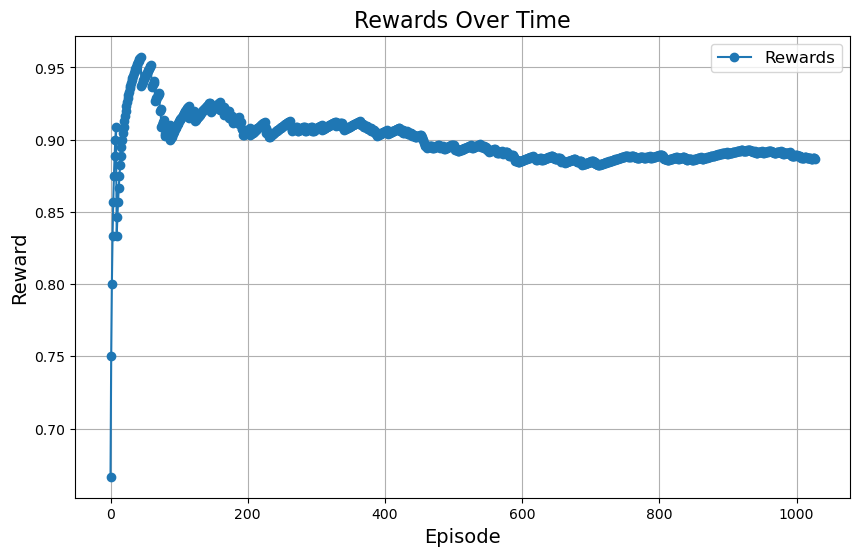

In [ ]:

import matplotlib.pyplot as plt

# Assuming env.visualization_manager.reward_list is a list of rewards
def plot_rewards(reward_list):
    plt.figure(figsize=(10, 6))
    plt.plot(reward_list, label="Rewards", marker='o', linestyle='-')
    plt.title("Rewards Over Time", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()

# Example usage:
if hasattr(env, 'visualization_manager') and hasattr(env.visualization_manager, 'reward_list'):
    plot_rewards(env.visualization_manager.reward_list)
else:
    print("reward_list not found in env.visualization_manager.")

Reward column:
0      0.003295
1      0.003833
2      0.006500
3      0.006500
4      0.011043
         ...   
253    0.023206
254    0.023206
255    0.023206
256    0.023206
257    0.023206
Name: total_energy_consumption, Length: 258, dtype: float64


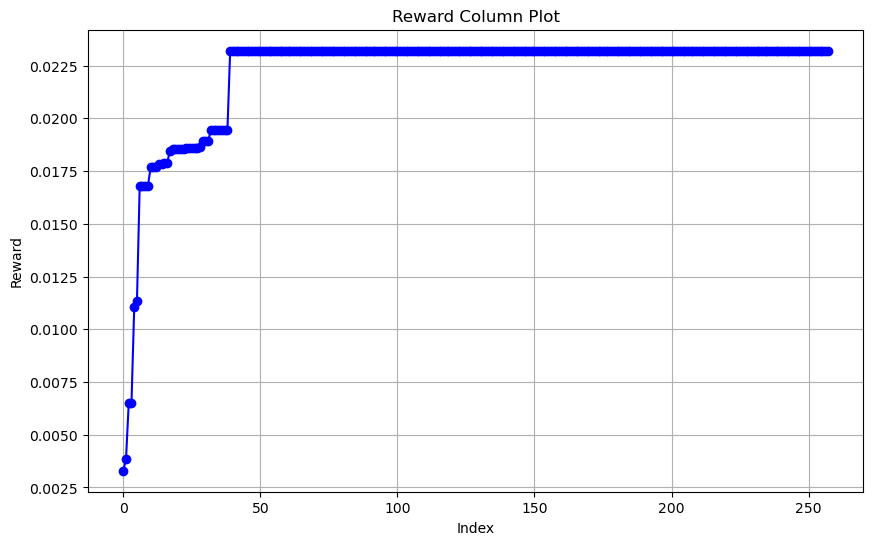

0      0.003295
1      0.003833
2      0.006500
3      0.006500
4      0.011043
         ...   
253    0.023206
254    0.023206
255    0.023206
256    0.023206
257    0.023206
Name: total_energy_consumption, Length: 258, dtype: float64

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def read_reward_column(csv_file_path):
    try:
        # Load the CSV file
        data = pd.read_csv(csv_file_path)

        # Check if 'reward' column exists
        if 'reward' in data.columns:
            # Read the 'reward' column
            reward_column = data['total_energy_consumption']
            print("Reward column:")
            print(reward_column)

            # Plot the reward column
            plt.figure(figsize=(10, 6))
            plt.plot(reward_column, marker='o', linestyle='-', color='b')
            plt.title('Reward Column Plot')
            plt.xlabel('Index')
            plt.ylabel('Reward')
            plt.grid(True)
            plt.show()

            return reward_column
        else:
            print("Error: 'reward' column not found in the CSV file.")
            return None
    except FileNotFoundError:
        print("Error: File not found. Please check the file path.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
csv_file_path = "results/reinforcement_learning.csv"  # Replace with your actual file path
read_reward_column(csv_file_path)